In [135]:
!sudo apt-get update -y
!sudo apt-get install python3-dev graphviz libgraphviz-dev pkg-config --quiet # Нужно для отрисовки графов
!pip install shap shapflow pygraphviz --quiet
from shapflow.flow import Node, GraphExplainer, build_feature_graph, CausalLinks, create_xgboost_f, edge_credits2edge_credit, node_dict2str_dict

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 https://cli.github.com/packages stable InRelease
Get:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,551 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,851 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [69.3 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,598 kB]
Get:14 http://archive.ub

In [136]:
!pip install -q catboost
from catboost import CatBoostRegressor

In [137]:
!pip install -q optuna
import optuna
from optuna.samplers import TPESampler

In [138]:
!pip install -q lime
from lime.lime_tabular import LimeTabularExplainer

In [139]:
import warnings
import os

import kagglehub
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost
import matplotlib.pyplot as plt
import shap
import statsmodels.api as sm
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.compose import ColumnTransformer
from sklearn.covariance import EllipticEnvelope
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression, chi2, RFECV
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.manifold import TSNE
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder, LabelEncoder
from sklearn.svm import OneClassSVM
from statsmodels.stats.outliers_influence import variance_inflation_factor
from umap import UMAP
from joblib import dump

warnings.filterwarnings("ignore")

In [140]:
path = kagglehub.dataset_download("dansbecker/melbourne-housing-snapshot")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'melbourne-housing-snapshot' dataset.
Path to dataset files: /kaggle/input/melbourne-housing-snapshot


In [141]:
df = pd.read_csv(f"{path}/melb_data.csv")
df.head(1)

Suburb       Address  Rooms Type      Price Method SellerG       Date  \
0  Abbotsford  85 Turner St      2    h  1480000.0      S  Biggin  3/12/2016   

   Distance  Postcode  ...  Bathroom  Car  Landsize  BuildingArea  YearBuilt  \
0       2.5    3067.0  ...       1.0  1.0     202.0           NaN        NaN   

   CouncilArea Lattitude  Longtitude             Regionname Propertycount  
0        Yarra  -37.7996    144.9984  Northern Metropolitan        4019.0  

[1 rows x 21 columns]

In [142]:
# Для сохранения моделей
os.makedirs('models', exist_ok=True)

Задача прогнозировать цену дома, за которую он будет продан с помощью регрессии.

#ЭТАП 1. EDA

In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13580 non-null  object 
 1   Address        13580 non-null  object 
 2   Rooms          13580 non-null  int64  
 3   Type           13580 non-null  object 
 4   Price          13580 non-null  float64
 5   Method         13580 non-null  object 
 6   SellerG        13580 non-null  object 
 7   Date           13580 non-null  object 
 8   Distance       13580 non-null  float64
 9   Postcode       13580 non-null  float64
 10  Bedroom2       13580 non-null  float64
 11  Bathroom       13580 non-null  float64
 12  Car            13518 non-null  float64
 13  Landsize       13580 non-null  float64
 14  BuildingArea   7130 non-null   float64
 15  YearBuilt      8205 non-null   float64
 16  CouncilArea    12211 non-null  object 
 17  Lattitude      13580 non-null  float64
 18  Longti

Описание полей данных:

* Suburb: Пригород/район, в котором находится объект недвижимости.

* Address: Точный адрес объекта.

* Rooms: Количество комнат в объекте недвижимости

* Type: Тип продаваемой недвижимости
    * br — количество спален;
    * h — дом, коттедж, вилла, полуотдельный дом, таунхаус в ряду;
    * u — квартира, дуплекс;
    * t — таунхаус;
    * dev site — участок под застройку;
    * o res — другая жилая недвижимость.  

* Price: Цена в долларах.

* Method: Метод продажи.
   * S — объект продан;
   * SP — объект продан заранее;
   * PI — объект не продан на аукционе (passed in);
   * PN — продан заранее, цена не раскрыта;
   * SN — продан, цена не раскрыта;
   * NB — отсутствовали ставки;
   * VB — ставка от продавца;
   * W — снят с торгов до аукциона;
   * SA — продан после аукциона;
   * SS — продан после аукциона, цена не раскрыта;
   * N/A — цена или максимальная ставка недоступны.  

* SellerG: Агентство недвижимости  

* Date: Дата продажи  

* Distance: Расстояние от центра города  

* Postcode: Почтовый индекс.

* Bedroom2: Количество спален (данные получены из другого источника)  

* Bathroom: Количество ванных комнат  

* Car: Количество парковочных мест  

* Landsize: Площадь земельного участка (в кв. метрах)

* BuildingArea: Площадь здания (в кв. метрах)

* YearBuilt: Год постройки здания.

* CouncilArea: Административный округ (управляющий совет района)

* Lattitude: Географическая широта объекта.

* Longtitude: Географическая долгота объекта.

* Regionname: Общий регион (Запад, Северо-Запад, Север, Северо-Восток и т.д.)

* Propertycount: Количество объектов недвижимости в данном пригороде

In [144]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
target = 'Price'

### Пропущенные значения

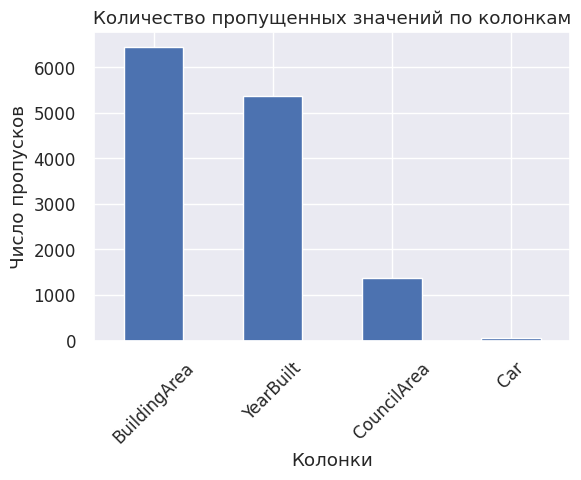

In [145]:
missing = df.isna().sum().sort_values(ascending=False)
missing = missing[missing > 0]

plt.figure(figsize=(6, 5))
missing.plot(kind='bar')
plt.title("Количество пропущенных значений по колонкам")
plt.xlabel("Колонки")
plt.ylabel("Число пропусков")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Из графика видно, что лишь 4 признака имеют пропуски: год постройки, сведения об административном округе и количестве парковочных мест.

In [146]:
def replace_missng_values(df):
    df = df.copy()
    for col in ['BuildingArea', 'YearBuilt']: # на медиану меняем, так как площадь и год постройки вряд ли нулевые
        if col in df.columns:
            df[col] = df[col].fillna(df[col].median())

    # Пропуски в числе парковочных мест заполним нулями
    df['Car'] = df['Car'].fillna(0)

    # Пропуски в административном округе заполним 'Unknown'
    df['CouncilArea'] = df['CouncilArea'].fillna("Unknown")
    return df

In [147]:
df = replace_missng_values(df)

### Анализ таргета и корреляций

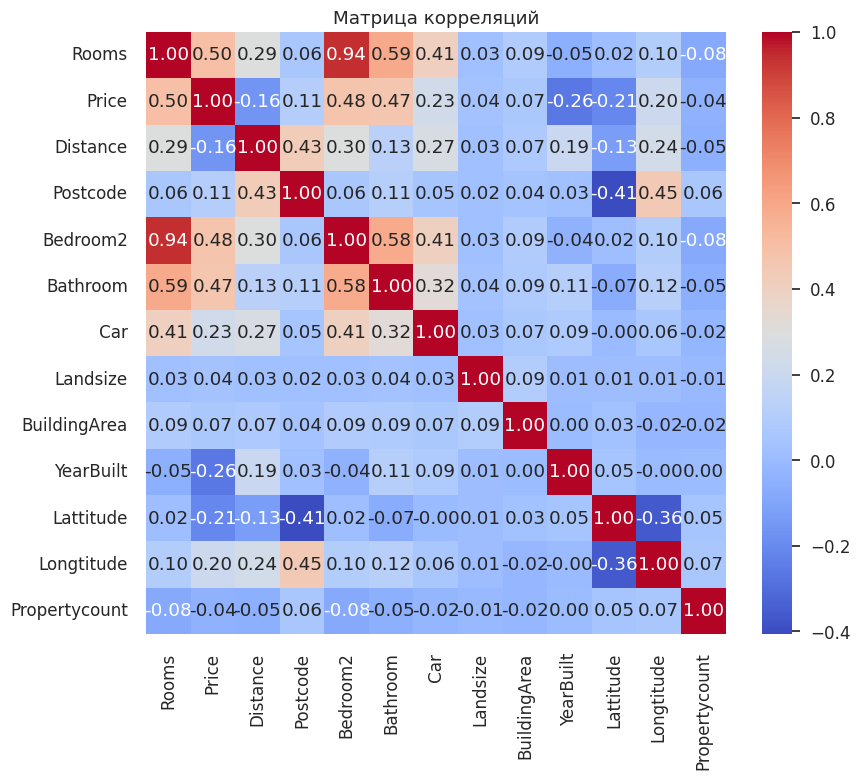

In [148]:
corr = df[numeric_cols].corr()
plt.figure(figsize=(9, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Матрица корреляций")
plt.tight_layout()
plt.show()

На основе данного графика можно выдвинуть ряд гипотез-замечаний:

- количество спален и комнат очень хорошо коррелируют, в свою очередь таргет коррелирует с количеством спален и ванных, комнат.

- наибольшая корееляция заметна у признаков, связанных с комнатами и их видами а также с местоположением(долгота, широта, почтовый индекс)

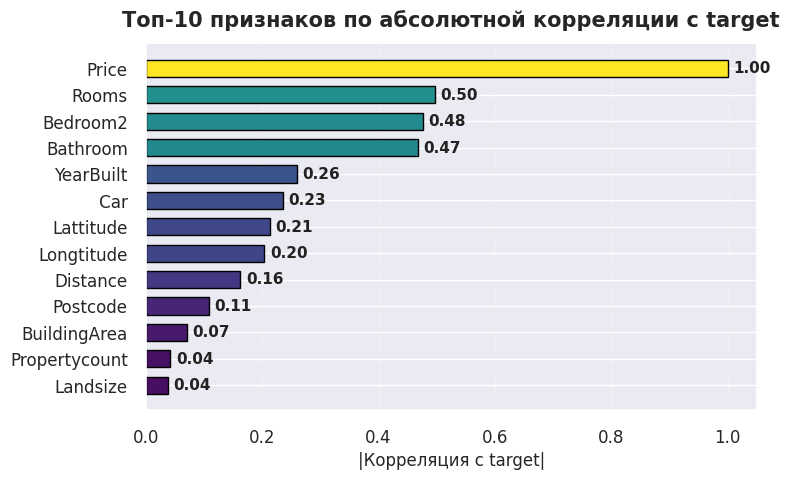

In [149]:
# Корреляции с таргетом
corr = df[numeric_cols].corr()[target].abs().sort_values(ascending=False)

features = corr.index
values = corr.values

plt.figure(figsize=(8, 5))
bars = plt.barh(features[::-1], values[::-1],
                color=plt.cm.viridis(values[::-1]), edgecolor='black', height=0.65)

# Подписи справа на концах баров
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
             f'{width:.2f}', va='center', fontsize=11, fontweight='bold', color="#222")

plt.xlabel('|Корреляция с target|', fontsize=12)
plt.title('Топ-10 признаков по абсолютной корреляции с target',
          fontsize=15, fontweight='bold', pad=12)
plt.grid(axis='x', linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()

Самые скоррелированые с таргетом признаки - это Rooms, Bedroom2, Bathroom.

Они имеют почти одинаковые коэффициенты корреляции, поэтому возможно тут присуствует мультикорреляция.

Regionname
Southern Metropolitan         1.372963e+06
Eastern Metropolitan          1.104080e+06
South-Eastern Metropolitan    9.229438e+05
Northern Metropolitan         8.981711e+05
Western Metropolitan          8.664205e+05
Eastern Victoria              6.999808e+05
Northern Victoria             5.948293e+05
Western Victoria              3.975234e+05
Name: Price, dtype: float64


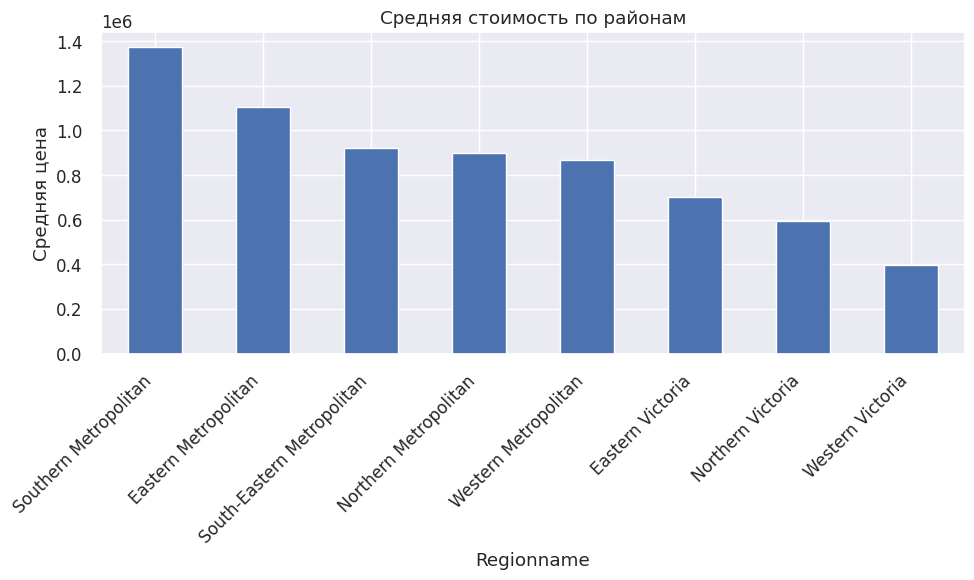

In [150]:
mean_price_by_area = df.groupby('Regionname')[target].mean().sort_values(ascending=False)
print(mean_price_by_area)

plt.figure(figsize=(10,6))
mean_price_by_area.plot(kind='bar')
plt.title("Средняя стоимость по районам")
plt.ylabel("Средняя цена")
plt.xlabel("Regionname")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Средняя стоимость сильно разнится в зависимости от региона: от 400 000 USD в самом дешевом до примерно 1 400 000$ в самом дорогом.

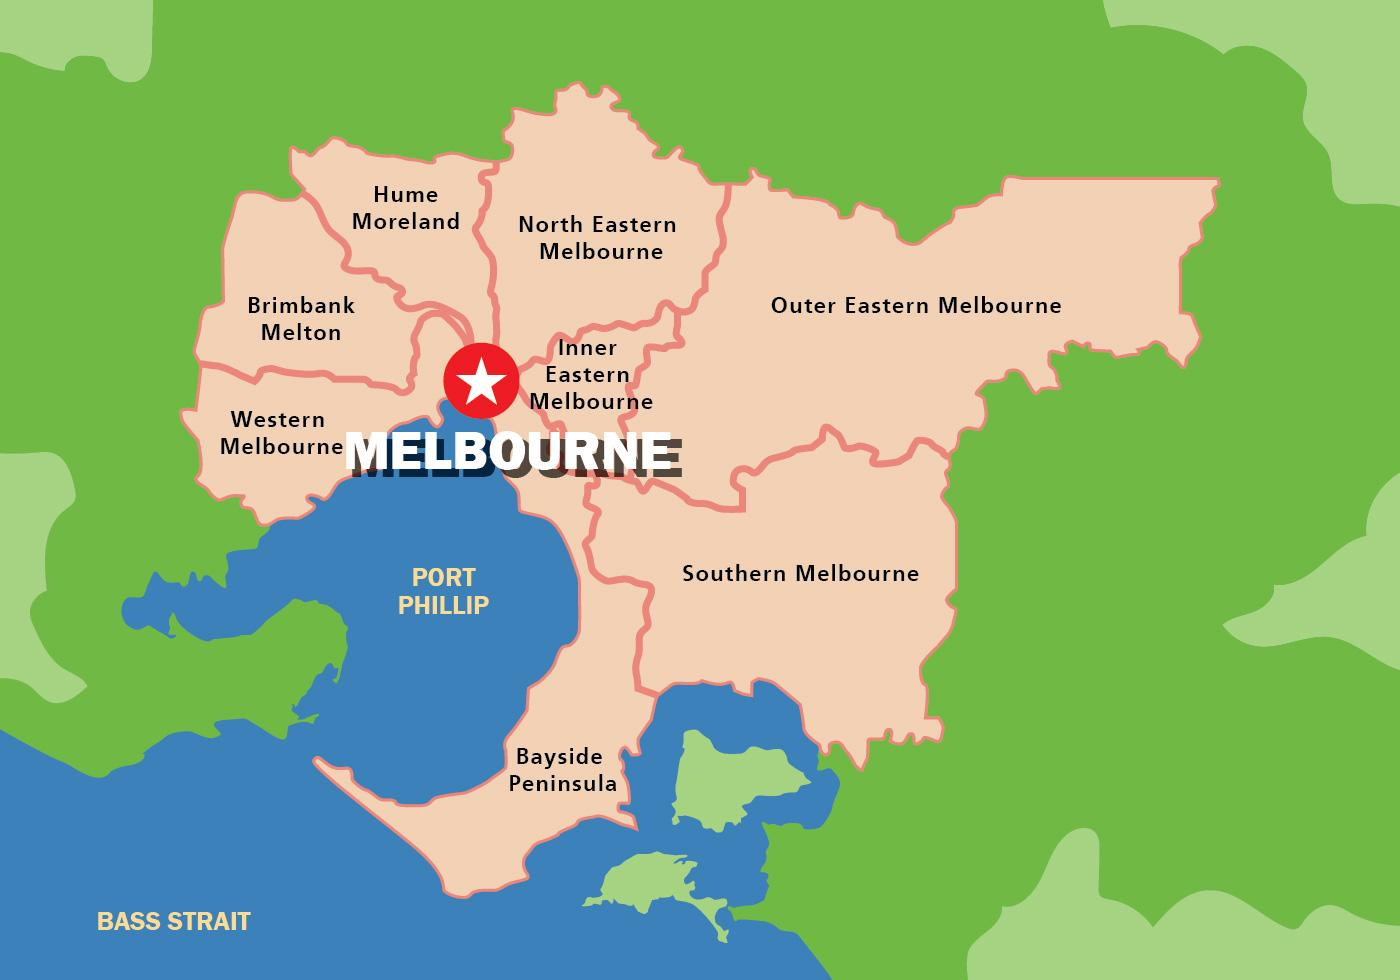

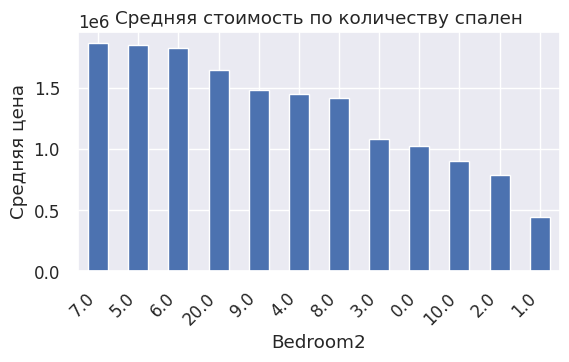

In [151]:
mean_price_by_area = df.groupby('Bedroom2')[target].mean().sort_values(ascending=False)
# print(mean_price_by_area)

plt.figure(figsize=(6,4))
mean_price_by_area.plot(kind='bar')
plt.title("Средняя стоимость по количеству спален")
plt.ylabel("Средняя цена")
plt.xlabel("Bedroom2")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Можно заметить, что зависимость средней стоимости дома от числа спален нелинейная, большое количество спален не гарантируют наибольшую цену

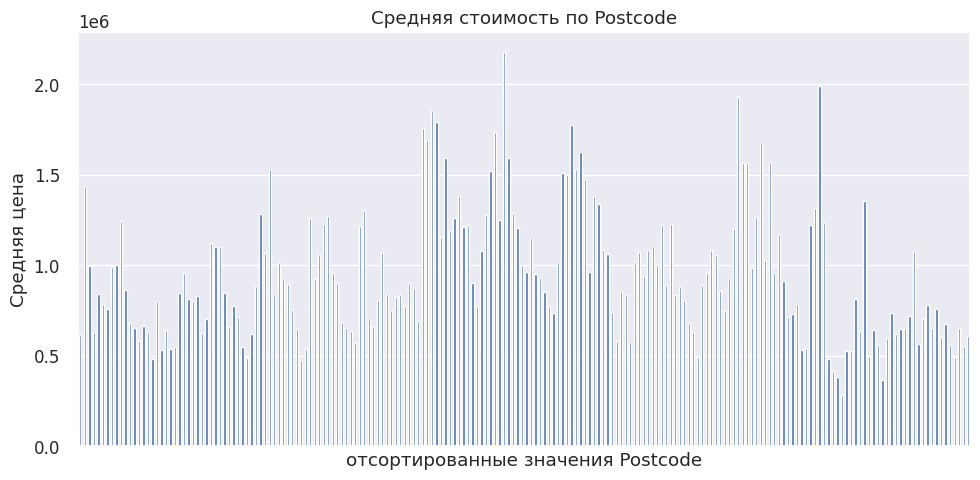

In [152]:
mean_price_by_area = df.groupby('Postcode')['Price'].mean()
mean_price_by_area = mean_price_by_area.sort_index()

plt.figure(figsize=(10,5))
mean_price_by_area.plot(kind='bar')
plt.title("Средняя стоимость по Postcode")
plt.ylabel("Средняя цена")
plt.xlabel("отсортированные значения Postcode")

plt.xticks([])
plt.tight_layout()
plt.show()


Видно, что есть какие-то группы почтовых индексов, у которых средняя цена выше/ниже чем у других

- Очевидно, это категориальный признак, каждый индекс - какой-то район города
- https://auspost.com.au/postcode/melbourne

In [153]:
print(df['Postcode'].unique().min(), '-', df['Postcode'].unique().max())

3000.0 - 3977.0


In [154]:
df['PostcodeParted'] = df['Postcode'].apply(lambda x : x // 10 * 10)
print('Было:', len(df['Postcode'].unique()))
print('Стало:', len(df['PostcodeParted'].unique()))
df.drop("Postcode", axis=1, inplace=True)
numeric_cols.remove("Postcode")

Было: 198
Стало: 34


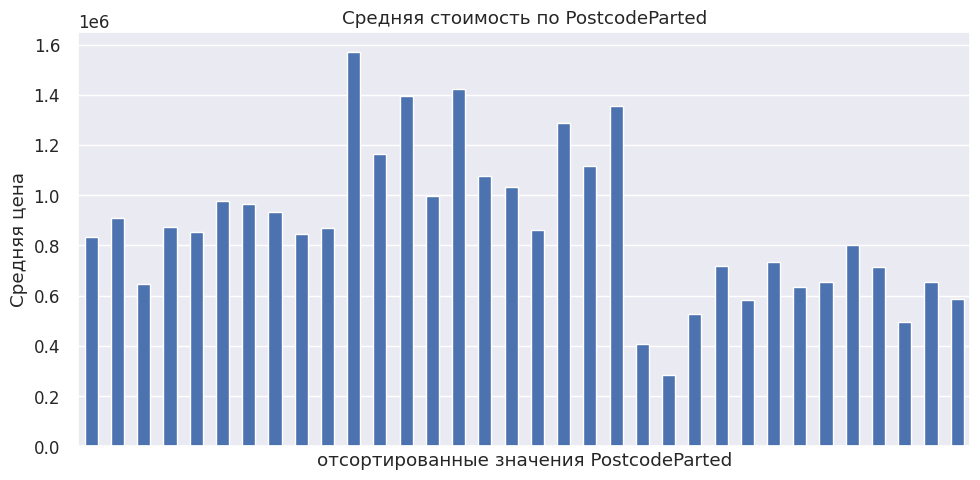

In [155]:
mean_price_by_area = df.groupby('PostcodeParted')['Price'].mean()
mean_price_by_area = mean_price_by_area.sort_index()

plt.figure(figsize=(10,5))
mean_price_by_area.plot(kind='bar')
plt.title("Средняя стоимость по PostcodeParted")
plt.ylabel("Средняя цена")
plt.xlabel("отсортированные значения PostcodeParted")

plt.xticks([])
plt.tight_layout()
plt.show()


Существенно сократили количество возможных значений категориальной переменной, оставив смысл примерно тем же

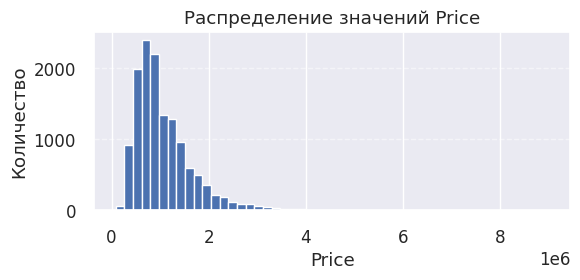

In [156]:
plt.figure(figsize=(6, 3))
plt.hist(df[target], bins=50)

plt.title("Распределение значений Price")
plt.xlabel("Price")
plt.ylabel("Количество")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

- медиана << среднее, то есть таргет скошен вправо.

Можно прологарифмировать таргет, чтобы линейные модели лучше работали (если мы будем использовать такой подход)

In [157]:
def log_transform(y):
    return np.log1p(y)

def inverse_log_transform(y_log):
    return np.expm1(y_log)

### Создаем выборки

Так как данные содержат временную компоненту, обычный train_test_split не подойдёт. Чтобы избежать утечки данных мы разбиваем датасет по индексам.

In [158]:
def time_train_test_split(df, need_val=True, test_size=0.2, val_size=0.2):
  test_split_index = int(len(df) * (1 - test_size))

  train_val_df = df.iloc[:test_split_index]
  test_df = df.iloc[test_split_index:]

  X_test = test_df.drop(target, axis=1)
  y_test = test_df[target]

  if not need_val:
    X_train = train_val_df.drop(target, axis=1)
    y_train = train_val_df[target]

    return X_train, y_train, X_test, y_test

  val_split_index = int(len(train_val_df) * (1 - val_size))

  train_df = train_val_df.iloc[:val_split_index]
  val_df = train_val_df.iloc[val_split_index:]

  X_train = train_df.drop(target, axis=1)
  y_train = train_df[target]

  X_val = val_df.drop(target, axis=1)
  y_val = val_df[target]

  X_train = train_df.drop(target, axis=1)
  y_train = train_df[target]

  return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = time_train_test_split(df)

print(f"Размер Train: {X_train.shape}")
print(f"Размер Val: {X_val.shape}")
print(f"Размер Test: {X_test.shape}")

Размер Train: (8691, 20)
Размер Val: (2173, 20)
Размер Test: (2716, 20)


## Baseline

In [159]:
res_intermidate_metrics = {} # словарь для сбора промежуточных результатов обучений
ALL_METRICS = ['rmse_train', 'rmse_val']

In [160]:
# В дальнейшем будем часто сохранять промежуточные модели и метрики
# Поэтому оформим это в виде функций

def count_all_metrics(y_train, preds_train, y_val, preds_val):
  rmse_train = root_mean_squared_error(y_train, preds_train)
  rmse_val = root_mean_squared_error(y_val, preds_val)

  return rmse_train, rmse_val

def predict_and_count_metrics(model, X_train, y_train, X_val, y_val, trained_on_log=True):
  if trained_on_log:
    preds_train = inverse_log_transform(model.predict(X_train))
    preds_val = inverse_log_transform(model.predict(X_val))
  else:
    preds_train = model.predict(X_train)
    preds_val = model.predict(X_val)

  return count_all_metrics(y_train, preds_train, y_val, preds_val)

def get_intermidate_metrics(X_train, y_train, X_val, y_val, categorical_features, stage_name, save_models=True):
  stage_results = {}

  y_train_log = log_transform(y_train)
  y_val_log = log_transform(y_val)

  cb_model = CatBoostRegressor(random_state=42)
  cb_model.fit(X_train, y_train_log,
                    eval_set=(X_val, y_val_log),
                    cat_features=categorical_features,
                    verbose=100)

  stage_results[f"Catboost_{stage_name}"] = predict_and_count_metrics(cb_model, X_train, y_train, X_val, y_val)

  for col in categorical_features:
    X_train[col] = X_train[col].astype(str)
    X_val[col] = X_val[col].astype(str)

  preprocessor = ColumnTransformer(
      transformers=[
          ('cat', OneHotEncoder(handle_unknown='ignore', drop="first"), categorical_features)
      ],
      remainder='passthrough' # не меняем числовые
  )

  lin_model = Pipeline(steps=[
      ('preprocessor', preprocessor),
      ('regressor', LinearRegression())
  ])

  lin_model.fit(X_train, y_train_log)

  stage_results[f"Linreg_{stage_name}"] = predict_and_count_metrics(lin_model, X_train, y_train, X_val, y_val)

  if save_models:
    catboost_file_name = f"models/catboost_{stage_name}.cbm"
    if not os.path.exists(catboost_file_name):
      cb_model.save_model(catboost_file_name)

    linreg_file_name = f"models/linreg_{stage_name}.joblib"
    if not os.path.exists(linreg_file_name):
      dump(lin_model, linreg_file_name)
  return stage_results

In [161]:
baseline_results = get_intermidate_metrics(X_train, y_train, X_val, y_val, categorical_cols, "baseline")
res_intermidate_metrics.update(baseline_results)
df_res = pd.DataFrame.from_dict(res_intermidate_metrics, orient='index',
                                columns=ALL_METRICS)
df_res

Learning rate set to 0.071504
0:	learn: 0.5152511	test: 0.4859510	best: 0.4859510 (0)	total: 234ms	remaining: 3m 53s
100:	learn: 0.2052675	test: 0.2496610	best: 0.2496610 (100)	total: 11s	remaining: 1m 38s
200:	learn: 0.1837964	test: 0.2313691	best: 0.2313691 (200)	total: 21.2s	remaining: 1m 24s
300:	learn: 0.1723852	test: 0.2248731	best: 0.2248731 (300)	total: 31s	remaining: 1m 11s
400:	learn: 0.1648251	test: 0.2223357	best: 0.2219535 (398)	total: 41.3s	remaining: 1m 1s
500:	learn: 0.1588462	test: 0.2219248	best: 0.2216688 (459)	total: 51.5s	remaining: 51.3s
600:	learn: 0.1542922	test: 0.2195535	best: 0.2192618 (577)	total: 57.8s	remaining: 38.4s
700:	learn: 0.1500257	test: 0.2181591	best: 0.2181418 (699)	total: 1m 3s	remaining: 27s
800:	learn: 0.1459338	test: 0.2185570	best: 0.2180221 (755)	total: 1m 9s	remaining: 17.1s
900:	learn: 0.1424447	test: 0.2177398	best: 0.2169172 (875)	total: 1m 13s	remaining: 8.09s
999:	learn: 0.1390577	test: 0.2167411	best: 0.2166557 (991)	total: 1m 19s	r

rmse_train       rmse_val
Catboost_baseline  203991.248249  269203.054416
Linreg_baseline    253387.388905  379754.136154

#ЭТАП 2. Работа с аномалиями и выбросами

### Анализ

=== Общая информация по таргету ===
Кол-во значений: 13580
Кол-во уникальных: 2204
Пропуски: 0


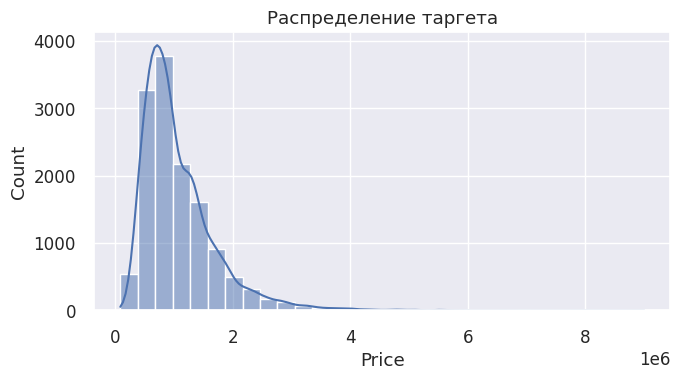

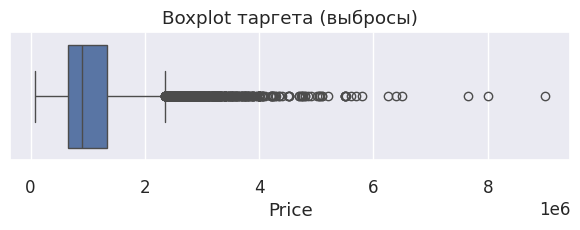


=== Выбросы по Z-score (>|3|) ===
Количество выбросов: 232

=== Выбросы по IQR (1.5 * IQR) ===
Q1: 650000.0 Q3: 1330000.0 IQR: 680000.0
Нижняя граница: -370000.0 Верхняя граница: 2350000.0
Количество выбросов: 612

Примеры выбросов:
80     2850000.0
92     2615000.0
97     2575000.0
102    3010000.0
103    2800000.0
Name: Price, dtype: float64


In [162]:
plt.style.use("seaborn-v0_8")
sns.set(font_scale=1.1)

# y = inverse_log_transform(df[target])
y = df[target]
print("=== Общая информация по таргету ===")
print("Кол-во значений:", y.shape[0])
print("Кол-во уникальных:", y.nunique())
print("Пропуски:", y.isna().sum())
plt.figure(figsize=(7, 4))
sns.histplot(y, kde=True, bins=30)
plt.title("Распределение таргета")
plt.tight_layout()
plt.show()
plt.figure(figsize=(6, 2.5))
sns.boxplot(x=y)
plt.title("Boxplot таргета (выбросы)")
plt.tight_layout()
plt.show()

z_scores = np.abs(stats.zscore(y.dropna()))
z_thr = 3
outliers_z_mask = z_scores > z_thr
print(f"\n=== Выбросы по Z-score (>|{z_thr}|) ===")
print("Количество выбросов:", outliers_z_mask.sum())

Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outliers_iqr_mask = (y < lower) | (y > upper)
print("\n=== Выбросы по IQR (1.5 * IQR) ===")
print("Q1:", Q1, "Q3:", Q3, "IQR:", IQR)
print("Нижняя граница:", lower, "Верхняя граница:", upper)
print("Количество выбросов:", outliers_iqr_mask.sum())

outlier_indices = y[outliers_iqr_mask].index
print("\nПримеры выбросов:")
print(y.loc[outlier_indices].head())


Мы знаем, что у нас цена измеряется в долларах. Оценим адекватность таких значений


In [163]:
outliers_z_rows = df[outliers_z_mask]
print("=== Объекты-выбросы по Z-score ===")
outliers_z_rows.head(2)

=== Объекты-выбросы по Z-score ===


Suburb      Address  Rooms Type      Price Method   SellerG  \
102  Albert Park   97 Page St      3    h  3010000.0      S      Greg   
108  Albert Park  115 Page St      4    h  4735000.0      S  Marshall   

           Date  Distance  Bedroom2  ...  Car  Landsize  BuildingArea  \
102  18/03/2017       3.3       3.0  ...  0.0     147.0         146.0   
108  25/02/2017       3.3       4.0  ...  1.0     330.0         207.0   

     YearBuilt   CouncilArea Lattitude  Longtitude             Regionname  \
102     1890.0  Port Phillip  -37.8473    144.9551  Southern Metropolitan   
108     1910.0  Port Phillip  -37.8477    144.9558  Southern Metropolitan   

    Propertycount  PostcodeParted  
102        3280.0          3200.0  
108        3280.0          3200.0  

[2 rows x 21 columns]

In [164]:
print("\n=== Описательная статистика по всему df ===")
df.describe()


=== Описательная статистика по всему df ===


Rooms         Price      Distance      Bedroom2      Bathroom  \
count  13580.000000  1.358000e+04  13580.000000  13580.000000  13580.000000   
mean       2.937997  1.075684e+06     10.137776      2.914728      1.534242   
std        0.955748  6.393107e+05      5.868725      0.965921      0.691712   
min        1.000000  8.500000e+04      0.000000      0.000000      0.000000   
25%        2.000000  6.500000e+05      6.100000      2.000000      1.000000   
50%        3.000000  9.030000e+05      9.200000      3.000000      1.000000   
75%        3.000000  1.330000e+06     13.000000      3.000000      2.000000   
max       10.000000  9.000000e+06     48.100000     20.000000      8.000000   

                Car       Landsize  BuildingArea     YearBuilt     Lattitude  \
count  13580.000000   13580.000000  13580.000000  13580.000000  13580.000000   
mean       1.602725     558.416127    139.633972   1966.788218    -37.809203   
std        0.966548    3990.669241    392.217403     29.088642      0.079260   
min        0.000000       0.000000      0.000000   1196.000000    -38.182550   
25%        1.000000     177.000000    122.000000   1960.000000    -37.856822   
50%        2.000000     440.000000    126.000000   1970.000000    -37.802355   
75%        2.000000     651.000000    129.940000   1975.000000    -37.756400   
max       10.000000  433014.000000  44515.000000   2018.000000    -37.408530   

         Longtitude  Propertycount  PostcodeParted  
count  13580.000000   13580.000000    13580.000000  
mean     144.995216    7454.417378     3101.304860  
std        0.103916    4378.581772       90.339011  
min      144.431810     249.000000     3000.000000  
25%      144.929600    4380.000000     3040.000000  
50%      145.000100    6555.000000     3080.000000  
75%      145.058305   10331.000000     3140.000000  
max      145.526350   21650.000000     3970.000000

In [165]:

print("\n=== Описательная статистика только по выбросам (outliers_z_rows) ===")
outliers_z_rows.describe()


=== Описательная статистика только по выбросам (outliers_z_rows) ===


Rooms         Price    Distance    Bedroom2    Bathroom  \
count  232.000000  2.320000e+02  232.000000  232.000000  232.000000   
mean     4.163793  3.757032e+06    7.507328    4.073276    2.849138   
std      0.794396  8.772626e+05    3.109723    0.794337    1.027163   
min      2.000000  3.000000e+06    1.500000    2.000000    1.000000   
25%      4.000000  3.200000e+06    5.400000    4.000000    2.000000   
50%      4.000000  3.470000e+06    7.500000    4.000000    3.000000   
75%      5.000000  4.000000e+06    9.700000    5.000000    3.000000   
max      7.000000  9.000000e+06   18.800000    7.000000    7.000000   

              Car     Landsize  BuildingArea    YearBuilt   Lattitude  \
count  232.000000   232.000000    232.000000   232.000000  232.000000   
mean     2.452586   778.336207    233.567883  1954.375000  -37.843898   
std      1.222938   357.122881    123.316547    38.664299    0.041755   
min      0.000000     0.000000      0.000000  1854.000000  -37.977750   
25%      2.000000   593.000000    126.000000  1920.000000  -37.860700   
50%      2.000000   747.500000    207.000000  1970.000000  -37.837550   
75%      3.000000   863.500000    325.250000  1970.000000  -37.813845   
max      8.000000  2187.000000    826.836700  2016.000000  -37.763700   

       Longtitude  Propertycount  PostcodeParted  
count  232.000000     232.000000       232.00000  
mean   145.030427    7693.590517      3129.87069  
std      0.043085    3252.263303        40.05927  
min    144.891090     394.000000      3000.00000  
25%    145.000800    4913.000000      3100.00000  
50%    145.030460    7467.000000      3120.00000  
75%    145.061815   10412.000000      3140.00000  
max    145.175440   15321.000000      3200.00000

Видно что по параметрам выбросов - они выглядят довольно адекватно, стоят они дороже, но там и комнат больше и машинных мест. Да и цена в 9_000_000$ не звучит абсурдно. Оставим эти данные

Проверим другие признаки

In [167]:
cols_to_check = [
    "Rooms", "Price", "Distance", "PostcodeParted",
    "Bedroom2", "Bathroom", "Car", "Landsize",
    "BuildingArea", "YearBuilt", "Lattitude", "Longtitude"]

def iqr_outlier_mask(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return (series < lower) | (series > upper)

outlier_masks = {}
for col in cols_to_check:
    mask = iqr_outlier_mask(df[col].dropna())
    full_mask = df[col].index.isin(mask[mask].index)
    outlier_masks[col] = full_mask
    print(f"{col}: выбросов {full_mask.sum()} из {len(df)}")


Rooms: выбросов 682 из 13580
Price: выбросов 612 из 13580
Distance: выбросов 411 из 13580
PostcodeParted: выбросов 208 из 13580
Bedroom2: выбросов 655 из 13580
Bathroom: выбросов 143 из 13580
Car: выбросов 644 из 13580
Landsize: выбросов 368 из 13580
BuildingArea: выбросов 5565 из 13580
YearBuilt: выбросов 3975 из 13580
Lattitude: выбросов 262 из 13580
Longtitude: выбросов 408 из 13580



================ Car ================
Тип: float64
Количество значений: 13580
Пропуски: 0

Описательная статистика:
count    13580.000000
mean         1.602725
std          0.966548
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         10.000000
Name: Car, dtype: float64


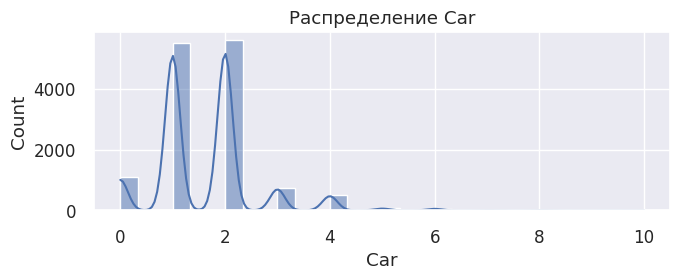

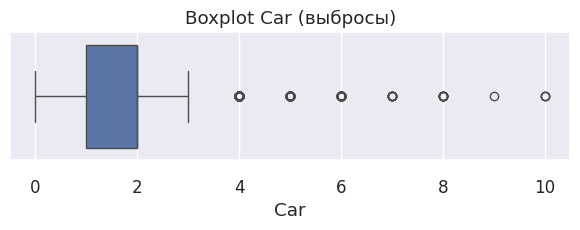


================ BuildingArea ================
Тип: float64
Количество значений: 13580
Пропуски: 0

Описательная статистика:
count    13580.000000
mean       139.633972
std        392.217403
min          0.000000
25%        122.000000
50%        126.000000
75%        129.940000
max      44515.000000
Name: BuildingArea, dtype: float64


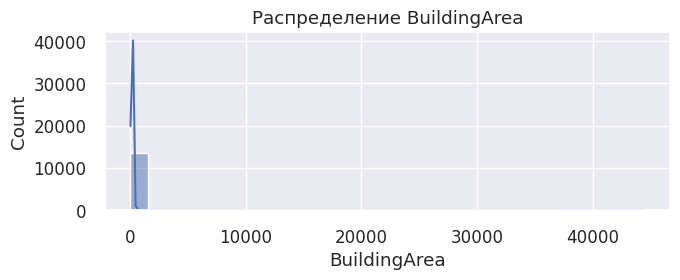

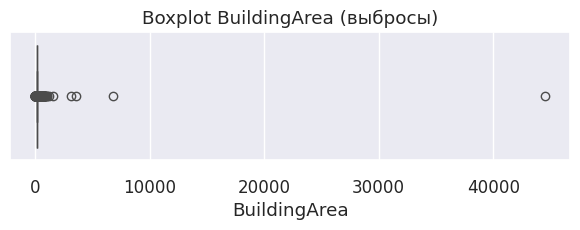

In [168]:
cols = ["Car", "BuildingArea"]
for col in cols:
    if col not in df.columns:
        print(f"\nКолонки {col} нет в df, пропускаем.")
        continue

    s = df[col].dropna()

    print(f"\n================ {col} ================")
    print("Тип:", s.dtype)
    print("Количество значений:", s.shape[0])
    print("Пропуски:", df[col].isna().sum())

    print("\nОписательная статистика:")
    print(s.describe())
    plt.figure(figsize=(7, 3))
    sns.histplot(s, kde=True, bins=30)
    plt.title(f"Распределение {col}")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 2.5))
    sns.boxplot(x=s)
    plt.title(f"Boxplot {col} (выбросы)")
    plt.tight_layout()
    plt.show()


Нашли осмысленный выброс! Площадь здания 44 515 м2

- https://www.realestate.com.au/property/71-hamilton-rd-new-gisborne-vic-3438/

Тут скорее всего перепутали с площадью земли, стандартное футбольное поле примерно 7 000м², значит 44 515 м2 - это около 6–7 футбольных полей

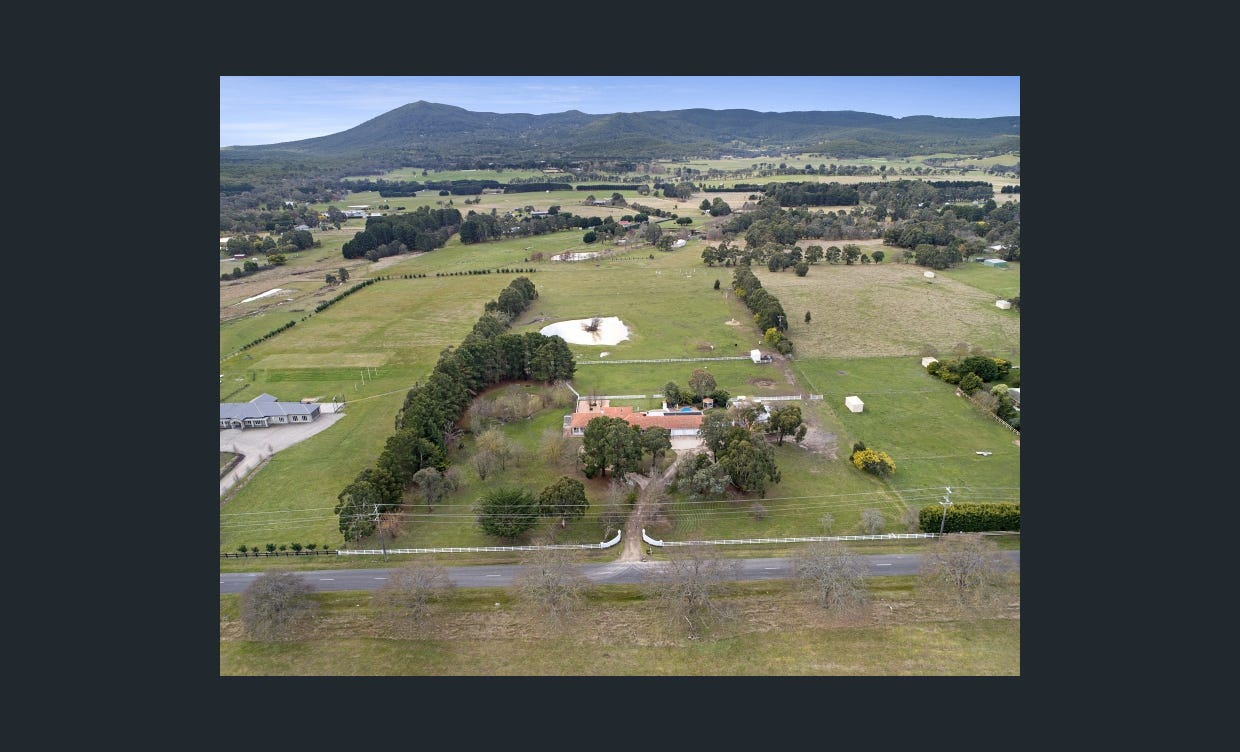

In [169]:
df[df['BuildingArea'] > 1000]

Suburb             Address  Rooms Type      Price Method  \
1368       Brunswick         7 Garnet St      3    h  1053000.0      S   
1484         Bulleen     19 Warringal St      4    h  1280000.0      S   
1588      Camberwell     46 Athelstan Rd      5    h  2608000.0      S   
2234     Elsternwick  5/16 St Georges Rd      2    u   741000.0      S   
2560   Fitzroy North      186 Queens Pde      2    t   930000.0      S   
2830       Glen Iris     1/58 Edgar St N      2    t   600000.0     VB   
3640             Kew   24 Fitzwilliam St      5    h  1975000.0      S   
13245   New Gisborne      71 Hamilton Rd      5    h  1355000.0      S   

        SellerG        Date  Distance  Bedroom2  ...  Car  Landsize  \
1368        Ray  27/06/2016       5.2       3.0  ...  1.0     343.0   
1484      Barry  11/03/2017      11.8       4.0  ...  2.0     732.0   
1588   Marshall  15/10/2016       7.8       5.0  ...  4.0     730.0   
2234     Biggin  16/04/2016       8.5       3.0  ...  1.0       0.0   
2560     Nelson   3/09/2016       3.5       2.0  ...  0.0    2778.0   
2830       Gary  22/08/2016       9.2       2.0  ...  1.0       0.0   
3640        Kay  18/06/2016       5.6       3.0  ...  1.0     531.0   
13245     Raine  23/09/2017      48.1       5.0  ...  5.0   44500.0   

       BuildingArea  YearBuilt  CouncilArea Lattitude  Longtitude  \
1368         1041.0     1925.0     Moreland -37.75890   144.95290   
1484         6791.0     1970.0   Manningham -37.76150   145.08970   
1588         3112.0     1920.0   Boroondara -37.84240   145.06390   
2234         1561.0     1966.0    Glen Eira -37.88290   145.00330   
2560         3558.0     1970.0        Yarra -37.79030   144.98590   
2830         1143.0     1970.0  Stonnington -37.85060   145.04650   
3640         1022.0     1890.0   Boroondara -37.81300   145.04110   
13245       44515.0     1970.0      Unknown -37.45392   144.58864   

                  Regionname Propertycount  PostcodeParted  
1368   Northern Metropolitan       11918.0          3050.0  
1484    Eastern Metropolitan        4480.0          3100.0  
1588   Southern Metropolitan        8920.0          3120.0  
2234   Southern Metropolitan        4898.0          3180.0  
2560   Northern Metropolitan        6244.0          3060.0  
2830   Southern Metropolitan       10412.0          3140.0  
3640   Southern Metropolitan       10331.0          3100.0  
13245      Northern Victoria         849.0          3430.0  

[8 rows x 21 columns]

Это выбросы, можно посмотреть эти дома в интернете, они точно не такой площади, заменим их площадь на медиану

In [170]:
mask_5_rooms = df["Rooms"] == 5
median_ba_5 = df.loc[mask_5_rooms, "BuildingArea"].median()
print("Медианная BuildingArea для домов с 5 комнатами:", median_ba_5)
mask_anomaly = df["BuildingArea"] > 1000
df.loc[mask_anomaly & mask_5_rooms, "BuildingArea"] = median_ba_5

Медианная BuildingArea для домов с 5 комнатами: 176.0


In [171]:
# Промежуточные метрики после ручного исправления выбросов
X_train, y_train, X_val, y_val, X_test, y_test = time_train_test_split(df)
manual_fix_outliers_results = get_intermidate_metrics(X_train, y_train, X_val, y_val, categorical_cols, "manual_fix_outliers")
res_intermidate_metrics.update(manual_fix_outliers_results)
df_res = pd.DataFrame.from_dict(res_intermidate_metrics, orient='index',
                                columns=ALL_METRICS)
df_res

Learning rate set to 0.071504
0:	learn: 0.5152536	test: 0.4859459	best: 0.4859459 (0)	total: 55.6ms	remaining: 55.5s
100:	learn: 0.2038010	test: 0.2513232	best: 0.2513131 (99)	total: 4.31s	remaining: 38.4s
200:	learn: 0.1827059	test: 0.2305847	best: 0.2305847 (200)	total: 8.53s	remaining: 33.9s
300:	learn: 0.1717877	test: 0.2250182	best: 0.2248638 (295)	total: 13.9s	remaining: 32.3s
400:	learn: 0.1638308	test: 0.2223668	best: 0.2223668 (400)	total: 18.4s	remaining: 27.5s
500:	learn: 0.1582975	test: 0.2198549	best: 0.2194938 (497)	total: 21.3s	remaining: 21.2s
600:	learn: 0.1537681	test: 0.2179152	best: 0.2179152 (600)	total: 25.3s	remaining: 16.8s
700:	learn: 0.1494582	test: 0.2172573	best: 0.2172568 (699)	total: 28.1s	remaining: 12s
800:	learn: 0.1456291	test: 0.2181207	best: 0.2168677 (759)	total: 30.3s	remaining: 7.52s
900:	learn: 0.1420291	test: 0.2174329	best: 0.2168677 (759)	total: 32.4s	remaining: 3.56s
999:	learn: 0.1386123	test: 0.2186155	best: 0.2168677 (759)	total: 34.6s	rem

rmse_train       rmse_val
Catboost_baseline             203991.248249  269203.054416
Linreg_baseline               253387.388905  379754.136154
Catboost_manual_fix_outliers  212824.648236  272432.119800
Linreg_manual_fix_outliers    246462.305144  373722.030303

### Добавим признаки связанные с аномалиями

In [172]:
cols_to_check = [
    "Rooms", "Distance", "PostcodeParted",
    "Bedroom2", "Bathroom", "Car", "Landsize",
    "BuildingArea", "YearBuilt"
]
outlier_masks = {}
for col in cols_to_check:
    s = df[col].dropna()
    mask = iqr_outlier_mask(s)
    full_mask = df[col].index.isin(mask[mask].index)
    outlier_masks[col] = full_mask
    outlier_col_name = f"is_outlier_{col}"
    df[outlier_col_name] = full_mask
    print(f"{col}: выбросов {full_mask.sum()} из {len(df)}, колонка '{outlier_col_name}' добавлена")

any_outlier_mask = np.zeros(len(df), dtype=bool)
for col in cols_to_check:
    if col in outlier_masks:
        any_outlier_mask |= outlier_masks[col]

df["is_outlier_any"] = any_outlier_mask
print("\nВсего объектов с любым выбросом:", df["is_outlier_any"].sum())


Rooms: выбросов 682 из 13580, колонка 'is_outlier_Rooms' добавлена
Distance: выбросов 411 из 13580, колонка 'is_outlier_Distance' добавлена
PostcodeParted: выбросов 208 из 13580, колонка 'is_outlier_PostcodeParted' добавлена
Bedroom2: выбросов 655 из 13580, колонка 'is_outlier_Bedroom2' добавлена
Bathroom: выбросов 143 из 13580, колонка 'is_outlier_Bathroom' добавлена
Car: выбросов 644 из 13580, колонка 'is_outlier_Car' добавлена
Landsize: выбросов 368 из 13580, колонка 'is_outlier_Landsize' добавлена
BuildingArea: выбросов 5565 из 13580, колонка 'is_outlier_BuildingArea' добавлена
YearBuilt: выбросов 3975 из 13580, колонка 'is_outlier_YearBuilt' добавлена

Всего объектов с любым выбросом: 7802


- Так нам если что будет удобно убрать выбросы по каким-либо параметрам

- Так же это может быть просто полезным признаком

In [173]:
# Промежуточные метрики после добавления признаков-флагов для выбросов
# К сожалению, эти признаки ломают SHAP-анализ (он падает с ошибкой), поэтому их не получится добавить
X_train_of, y_train_of, X_val_of, y_val_of, X_test_of, y_test_of = time_train_test_split(df)
outliers_flags_results = get_intermidate_metrics(X_train_of, y_train_of, X_val_of, y_val_of, categorical_cols, "outliers_flags")
res_intermidate_metrics.update(outliers_flags_results)
df_res = pd.DataFrame.from_dict(res_intermidate_metrics, orient='index',
                                columns=ALL_METRICS)
df_res

Learning rate set to 0.071504
0:	learn: 0.5156680	test: 0.4798242	best: 0.4798242 (0)	total: 23.7ms	remaining: 23.7s
100:	learn: 0.2038715	test: 0.2494525	best: 0.2494525 (100)	total: 3.45s	remaining: 30.7s
200:	learn: 0.1831420	test: 0.2282852	best: 0.2282852 (200)	total: 5.57s	remaining: 22.2s
300:	learn: 0.1721292	test: 0.2225148	best: 0.2221769 (297)	total: 7.72s	remaining: 17.9s
400:	learn: 0.1645305	test: 0.2212579	best: 0.2209605 (389)	total: 9.91s	remaining: 14.8s
500:	learn: 0.1589410	test: 0.2182120	best: 0.2178243 (482)	total: 12.1s	remaining: 12s
600:	learn: 0.1540068	test: 0.2174575	best: 0.2168514 (589)	total: 15.6s	remaining: 10.4s
700:	learn: 0.1500851	test: 0.2186172	best: 0.2168514 (589)	total: 17.8s	remaining: 7.6s
800:	learn: 0.1458358	test: 0.2175019	best: 0.2168514 (589)	total: 20.1s	remaining: 4.99s
900:	learn: 0.1426952	test: 0.2174282	best: 0.2165793 (844)	total: 22.3s	remaining: 2.45s
999:	learn: 0.1392555	test: 0.2178079	best: 0.2165793 (844)	total: 24.5s	rem

rmse_train       rmse_val
Catboost_baseline             203991.248249  269203.054416
Linreg_baseline               253387.388905  379754.136154
Catboost_manual_fix_outliers  212824.648236  272432.119800
Linreg_manual_fix_outliers    246462.305144  373722.030303
Catboost_outliers_flags       207734.879360  271619.956505
Linreg_outliers_flags         257496.720964  373138.399268

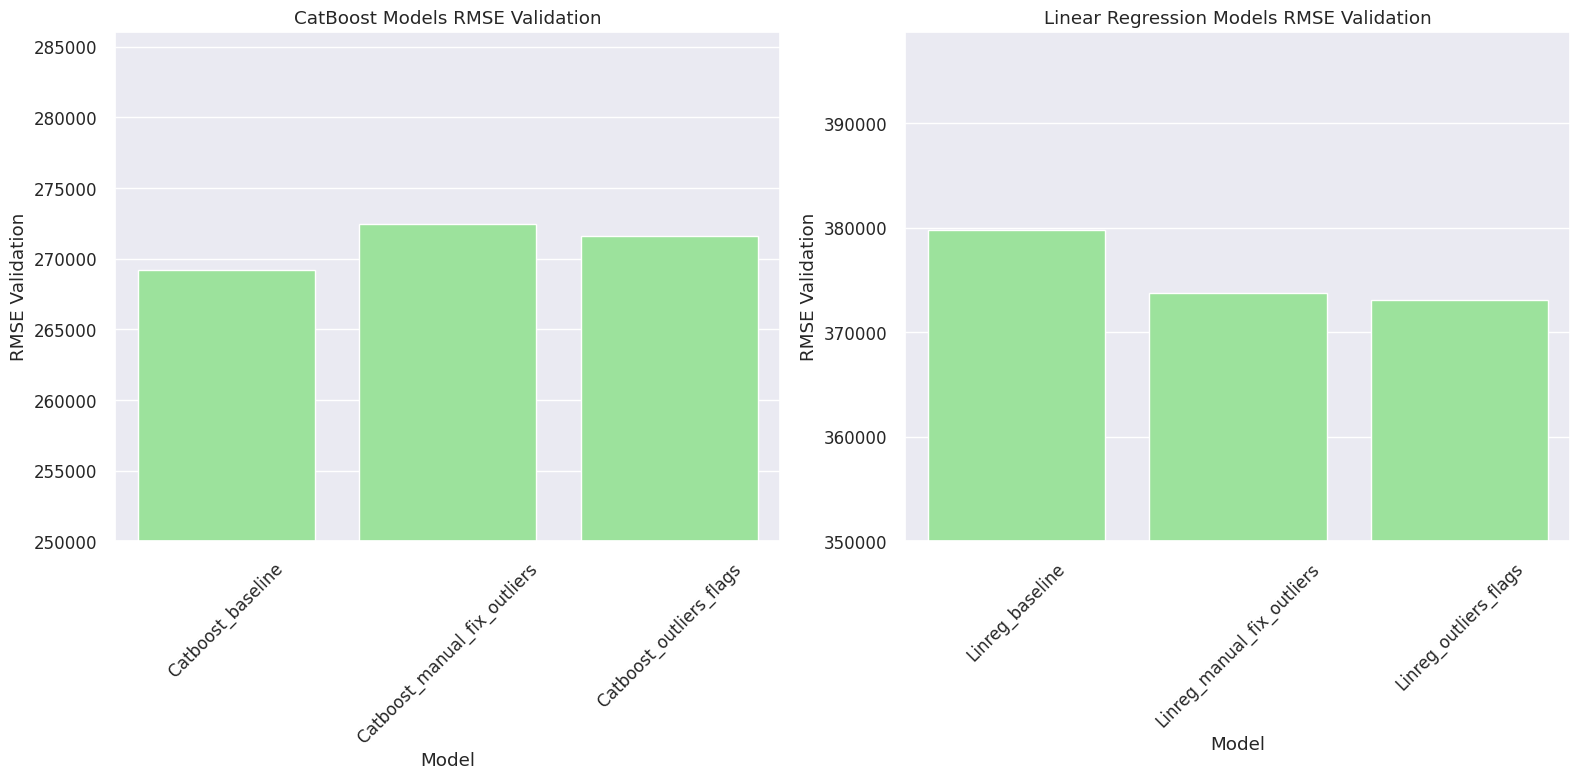

In [174]:
catboost_metrics = df_res[df_res.index.str.contains('Catboost')][['rmse_val']]
linreg_metrics = df_res[df_res.index.str.contains('Linreg')][['rmse_val']]

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

sns.barplot(x=catboost_metrics.index, y='rmse_val', data=catboost_metrics, ax=axes[0], color="lightgreen")
axes[0].set_title('CatBoost Models RMSE Validation')
axes[0].set_ylabel('RMSE Validation')
axes[0].set_xlabel('Model')
axes[0].set_ylim(250000)
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(x=linreg_metrics.index, y='rmse_val', data=linreg_metrics, ax=axes[1], color="lightgreen")
axes[1].set_title('Linear Regression Models RMSE Validation')
axes[1].set_ylabel('RMSE Validation')
axes[1].set_xlabel('Model')
axes[1].set_ylim(350000)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

стало чуть хуже

### ML-методы для поиска сложных выбросов

In [175]:
def run_isolation_forest(X, contamination=0.05, n_estimators=200):
  model = IsolationForest(contamination=contamination, n_estimators=n_estimators, random_state=42)
  preds = model.fit_predict(X)
  return (preds == -1).astype(int), model

In [176]:
def run_lof(X, contamination=0.05, n_neighbors=20):
  model = LocalOutlierFactor(contamination=contamination, n_neighbors=n_neighbors)
  preds = model.fit_predict(X)
  return (preds == -1).astype(int), model

In [177]:
def run_oneclass_svm(X, nu=0.05, kernel="rbf", gamma="scale"):
  model = OneClassSVM(nu=nu, kernel=kernel, gamma=gamma)
  preds = model.fit_predict(X)
  return (preds == -1).astype(int), model

In [178]:
def run_elliptic_envelope(X, contamination=0.05):
  model = EllipticEnvelope(contamination=contamination, random_state=42)
  preds = model.fit_predict(X)
  return (preds == -1).astype(int), model

In [179]:
def plot_outliers_2d(df, x_col, y_col, outlier_mask, title="Outliers Visualization"):
  plt.figure(figsize=(8,6))
  sns.scatterplot(x=df[x_col], y=df[y_col], hue=outlier_mask, palette="coolwarm_r")
  plt.title(title)
  plt.show()

In [180]:
def evaluate(y_true, y_pred):
  metrics = {
    "precision": precision_score(y_true, y_pred),
    "recall": recall_score(y_true, y_pred),
    "f1": f1_score(y_true, y_pred),
  }
  try:
    metrics["roc_auc"] = roc_auc_score(y_true, y_pred)
  except:
    metrics["roc_auc"] = None
  return metrics

In [181]:
def run_all_outlier_methods(X, y_true=None):
  results = {}

  methods = {
    "IsolationForest": run_isolation_forest,
    "LOF": run_lof,
    "OneClassSVM": run_oneclass_svm,
    "EllipticEnvelope": run_elliptic_envelope,
  }

  for name, method in methods.items():
    preds, model = method(X)
    results[name] = {
      "preds": preds,
      "model": model,
    }
    if y_true is not None:
      results[name]["metrics"] = evaluate(y_true, preds)


  return results

In [182]:
def compute_intersections(results):
  df_preds = pd.DataFrame({name: res["preds"] for name, res in results.items()})
  df_preds["all_models"] = df_preds.sum(axis=1) == len(results)
  return df_preds

In [183]:
def find_suspicious_features(df, results, numeric_cols, top_n=5):

    # Собираем предсказания всех моделей
    preds_df = pd.DataFrame({name: r["preds"] for name, r in results.items()})
    preds_df["sum"] = preds_df.sum(axis=1)

    scores = {}

    # Оцениваем, насколько признак связан с выбросами
    for col in numeric_cols:
        scores[col] = np.abs(np.corrcoef(df[col], preds_df["sum"])[0, 1])

    # Возвращаем топ признаков
    return sorted(scores, key=scores.get, reverse=True)[:top_n]


In [184]:
X = df[numeric_cols].values
y_true = df["is_outlier_any"] # если есть истинные метки выбросов

results = run_all_outlier_methods(X, y_true)
print(results["IsolationForest"]["metrics"])

{'precision': 0.9985272459499264, 'recall': 0.08690079466803384, 'f1': 0.15988680580120268, 'roc_auc': np.float64(0.5433638622007527)}


In [185]:
top_cols = find_suspicious_features(df, results, numeric_cols, top_n=2)
x_col, y_col = top_cols[0], top_cols[1]

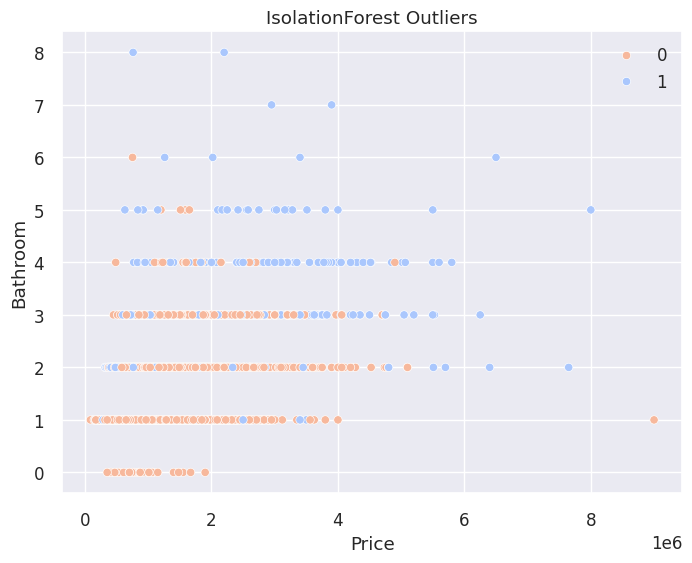

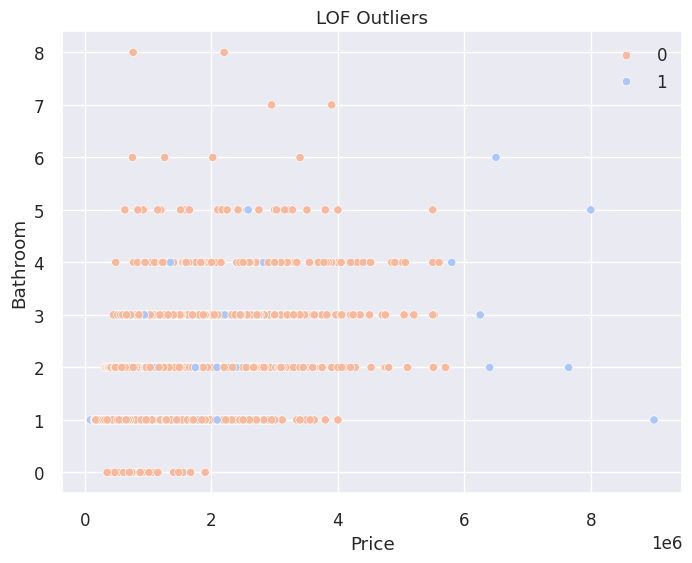

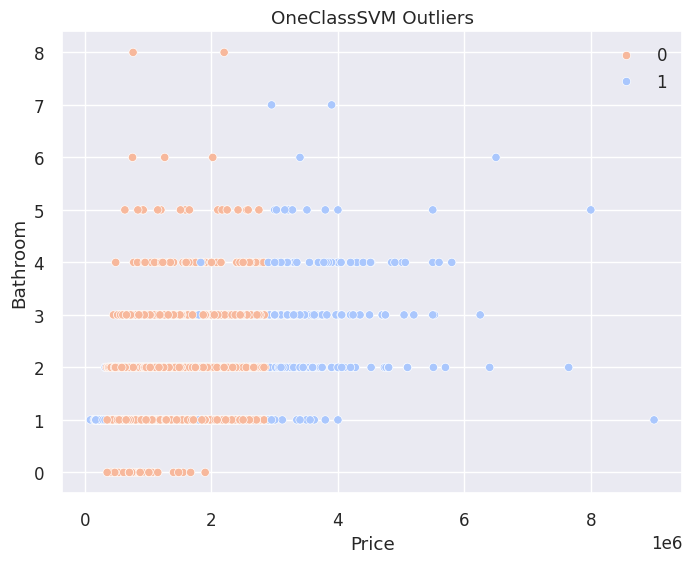

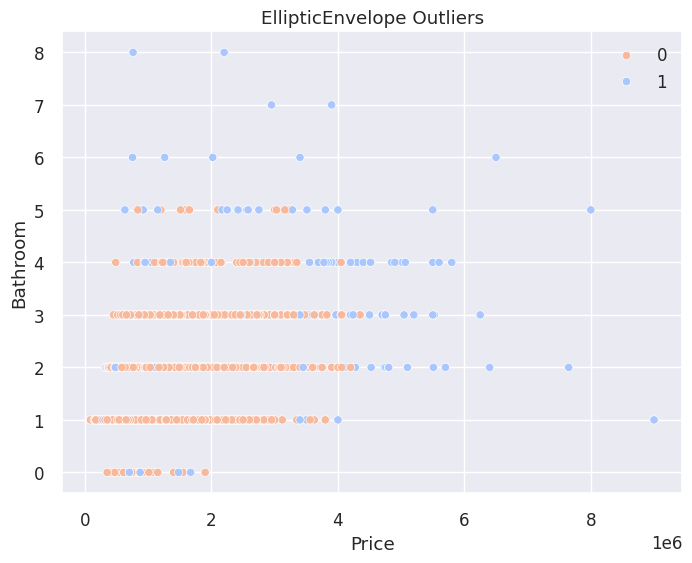

In [186]:
for model in results:
    plot_outliers_2d(df, x_col, y_col, results[model]["preds"],
                     title=f"{model} Outliers")

In [187]:
intersection_mask = (results["IsolationForest"]["preds"] +
                     results["LOF"]["preds"] +
                     results["OneClassSVM"]["preds"] +
                     results["EllipticEnvelope"]["preds"]) > 2

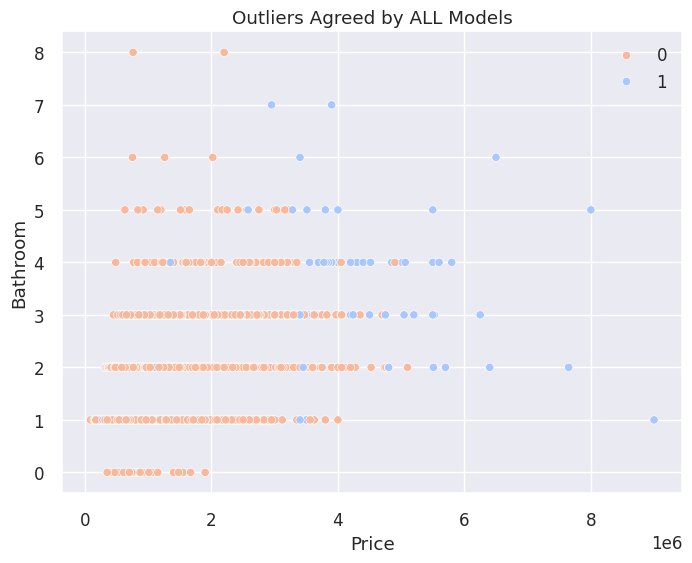

In [188]:
plot_outliers_2d(df, x_col, y_col, intersection_mask.astype(int),
                 title="Outliers Agreed by ALL Models")

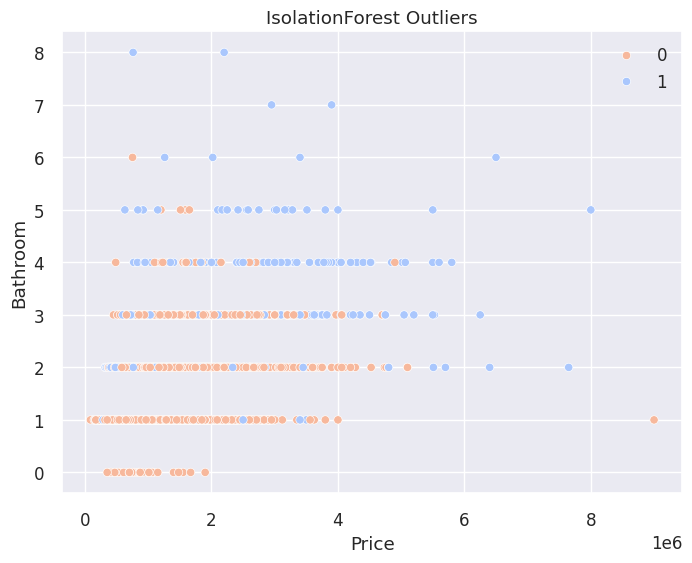

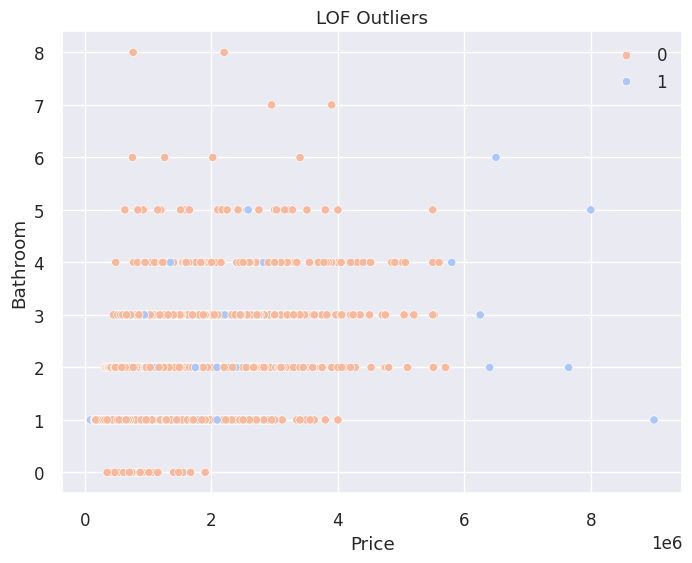

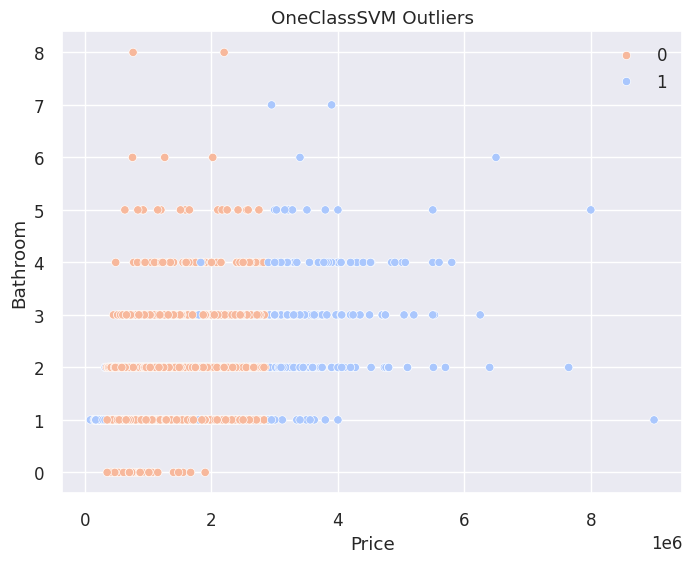

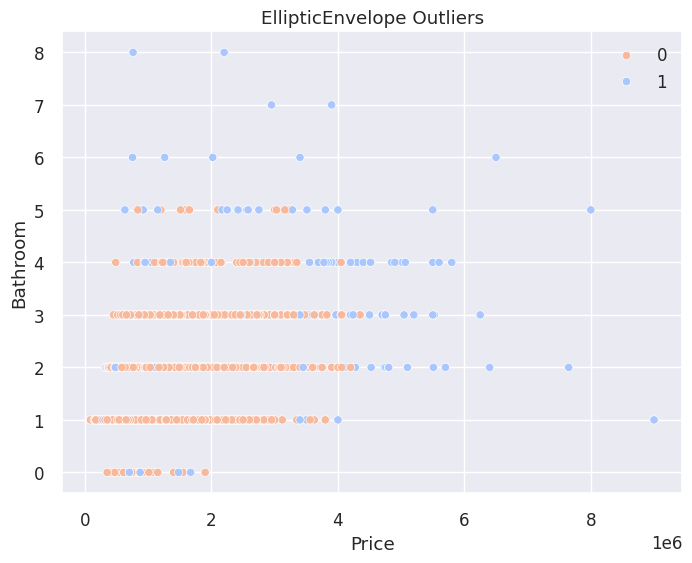

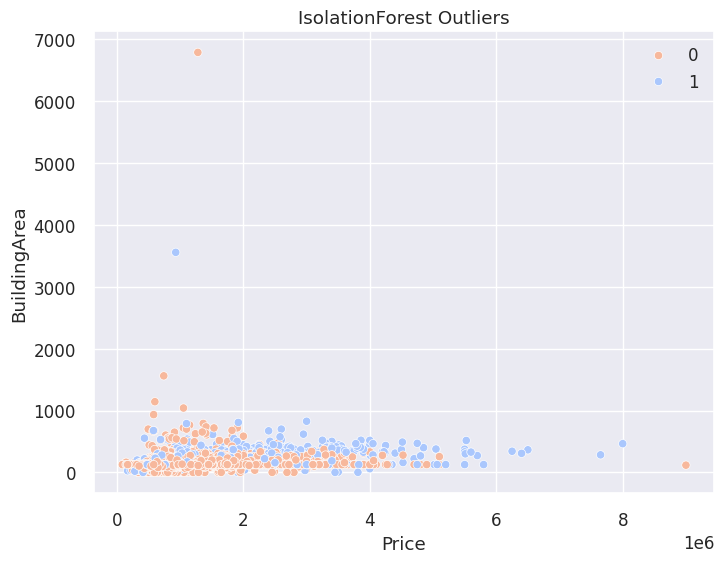

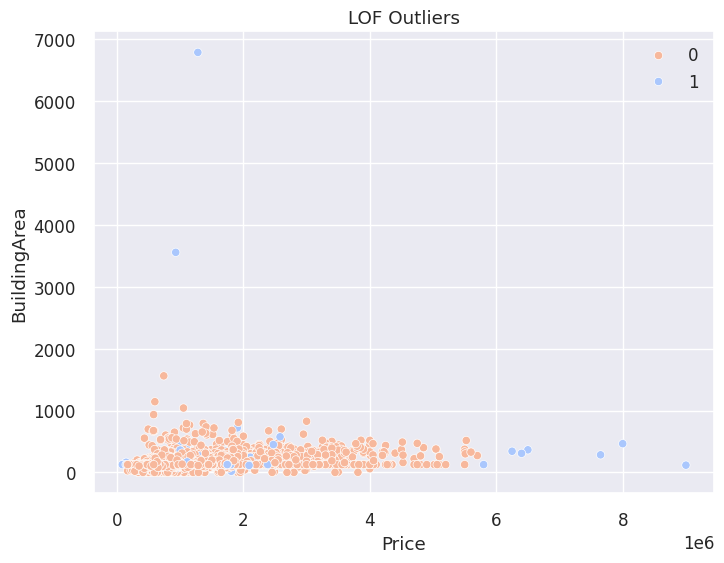

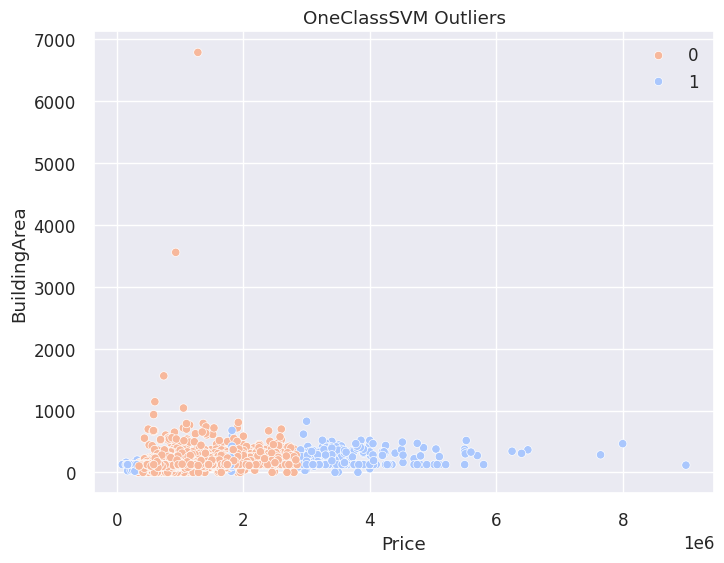

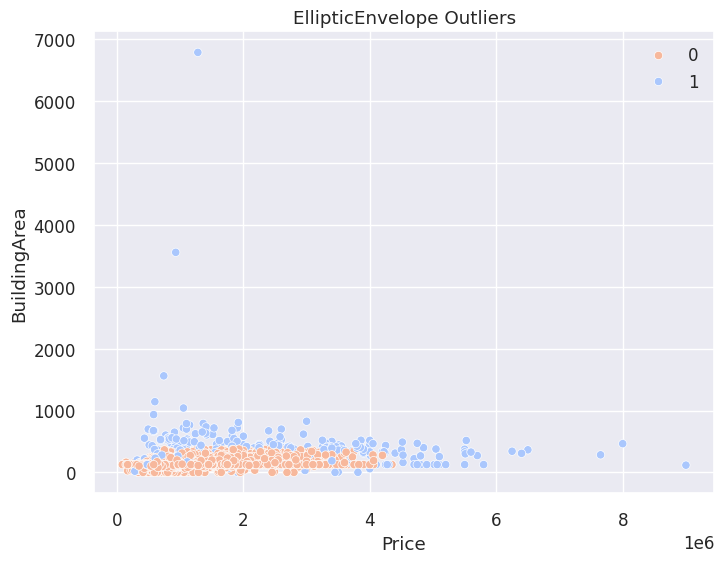

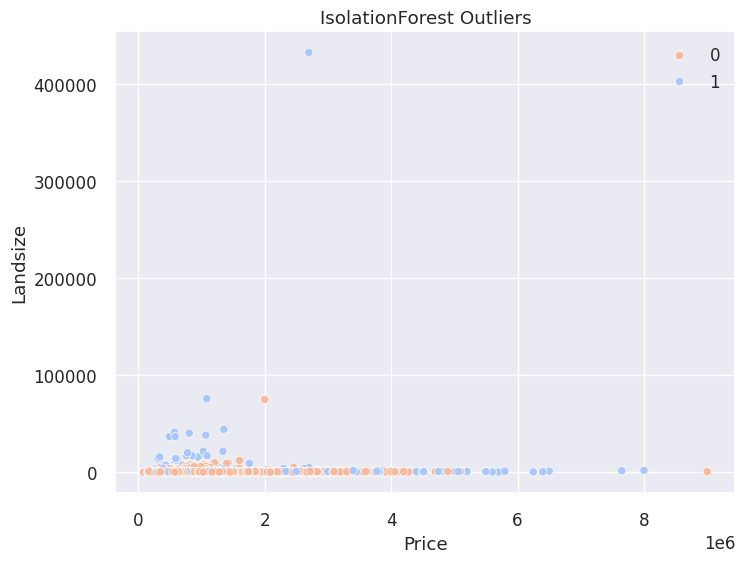

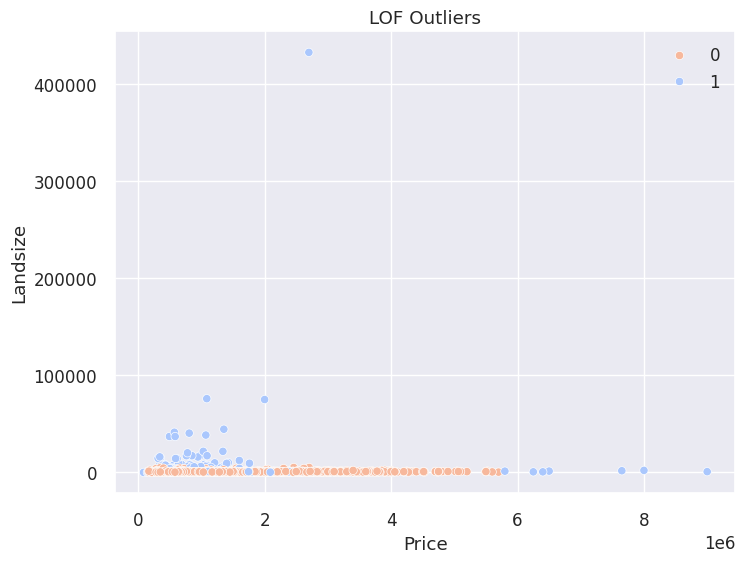

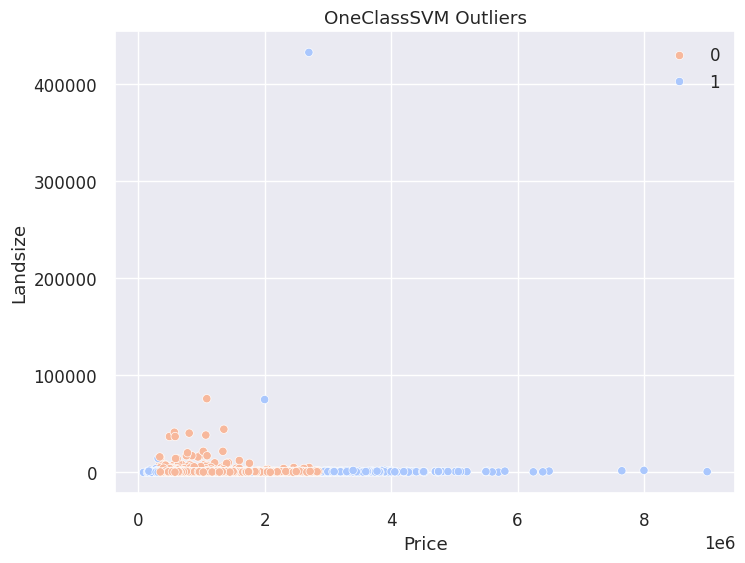

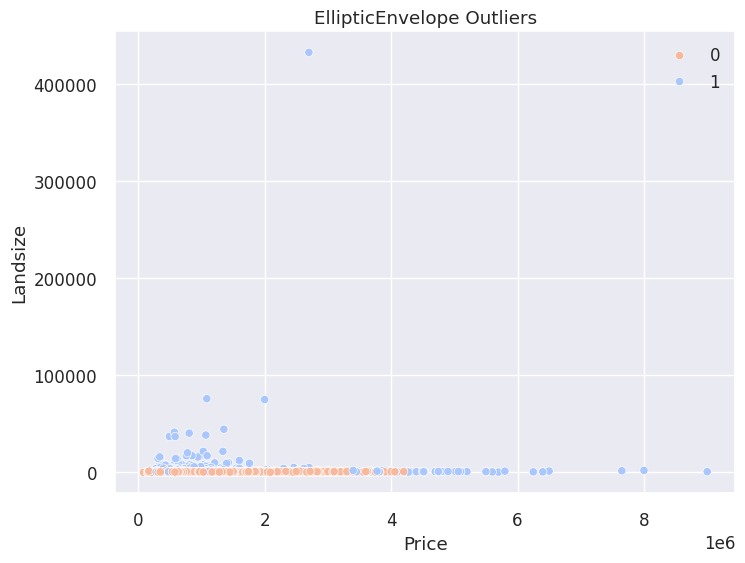

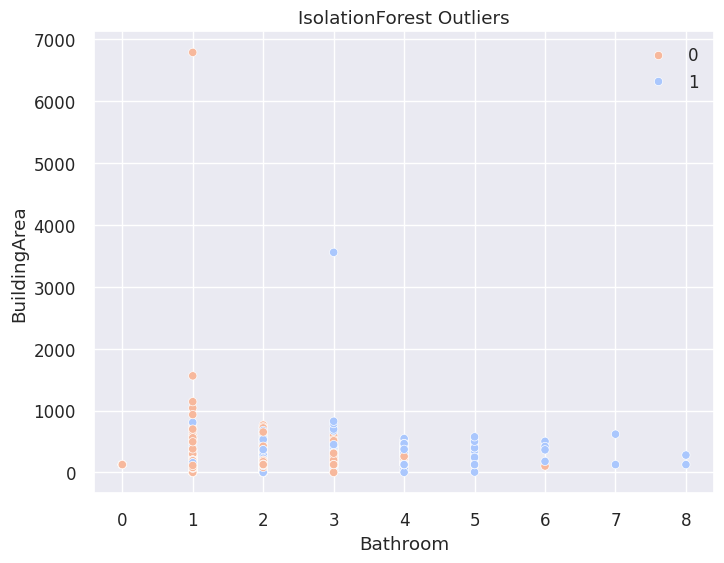

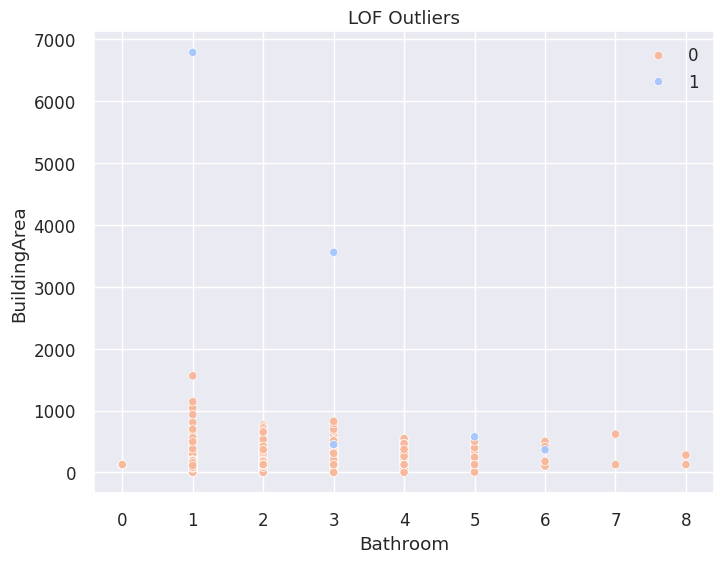

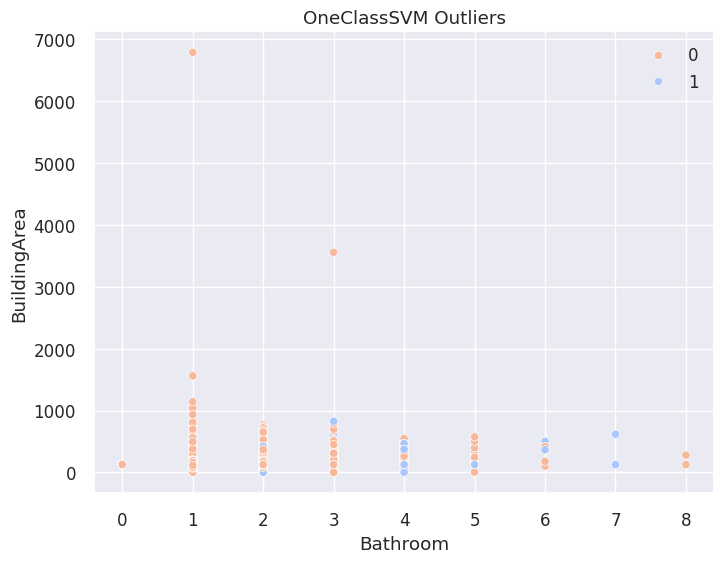

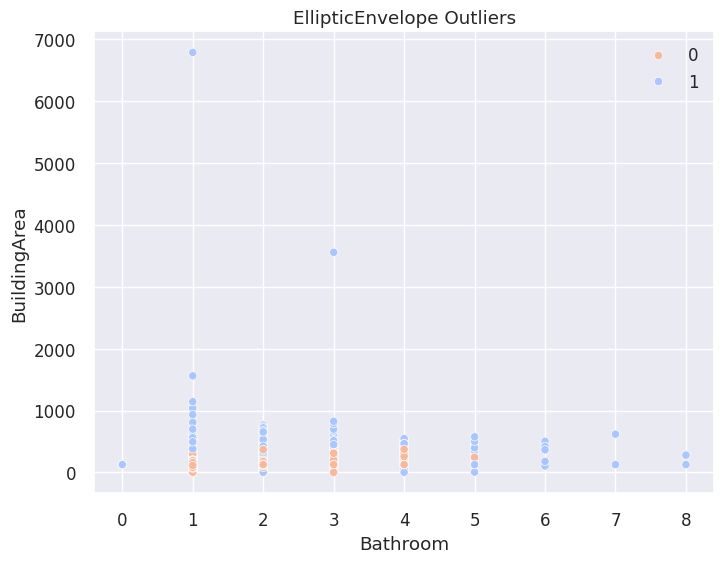

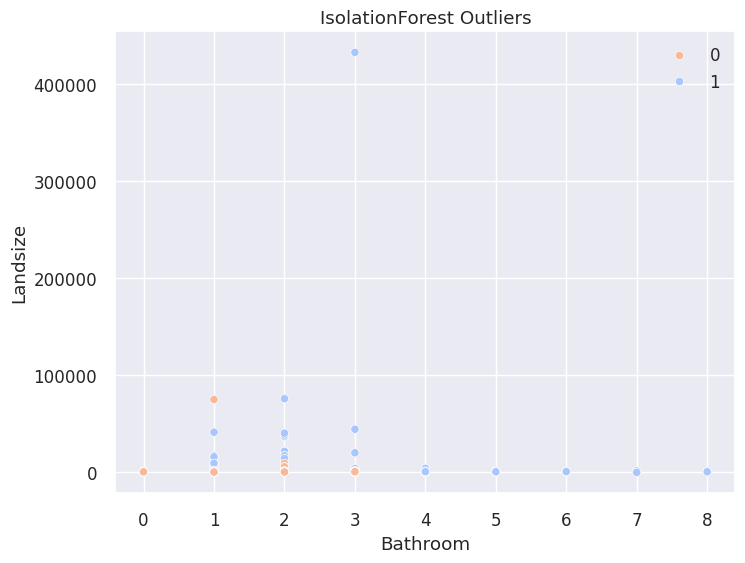

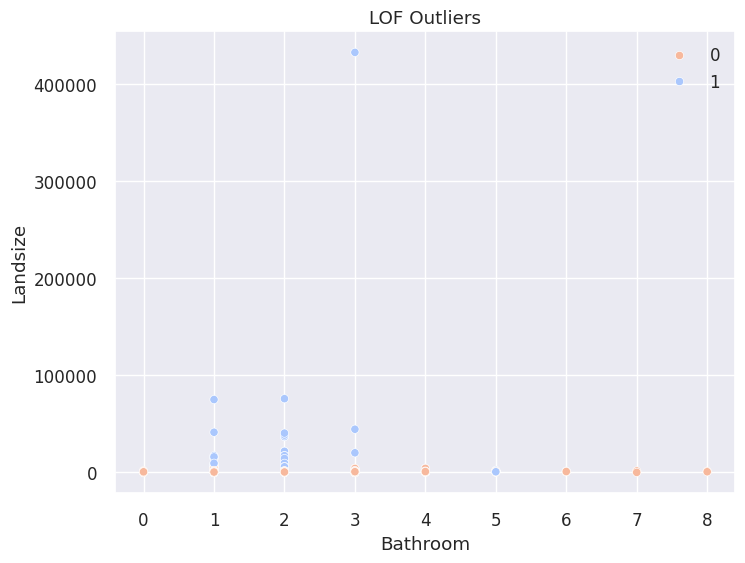

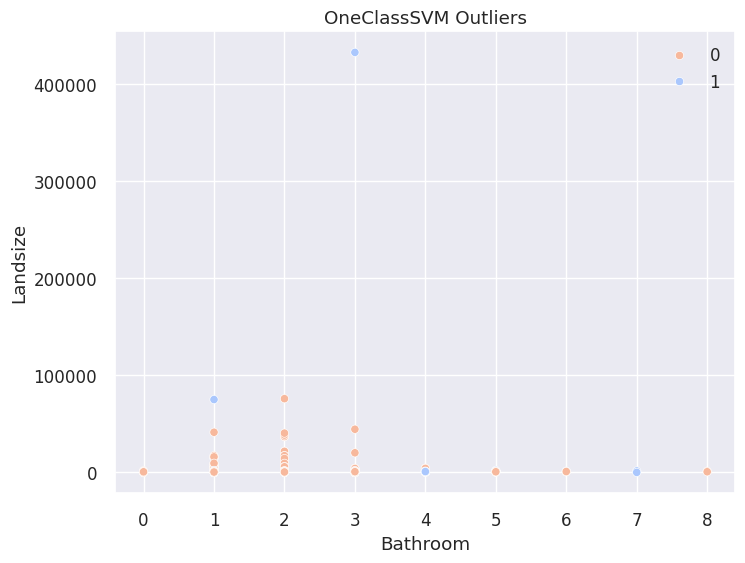

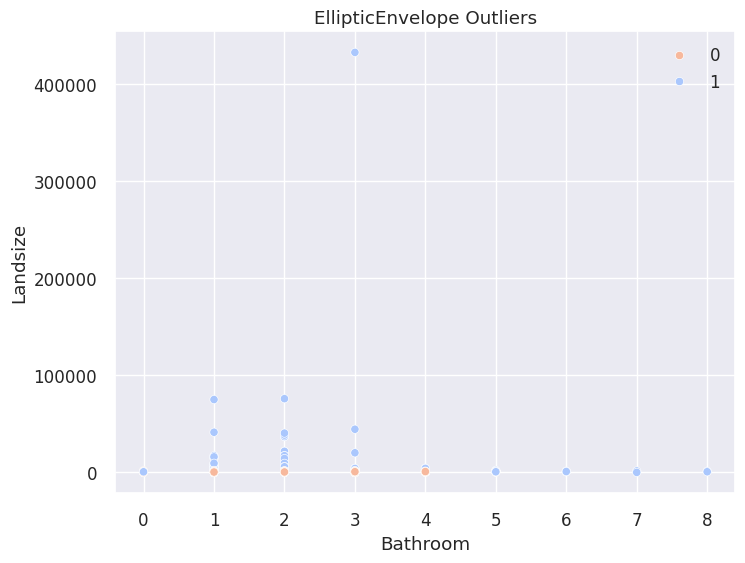

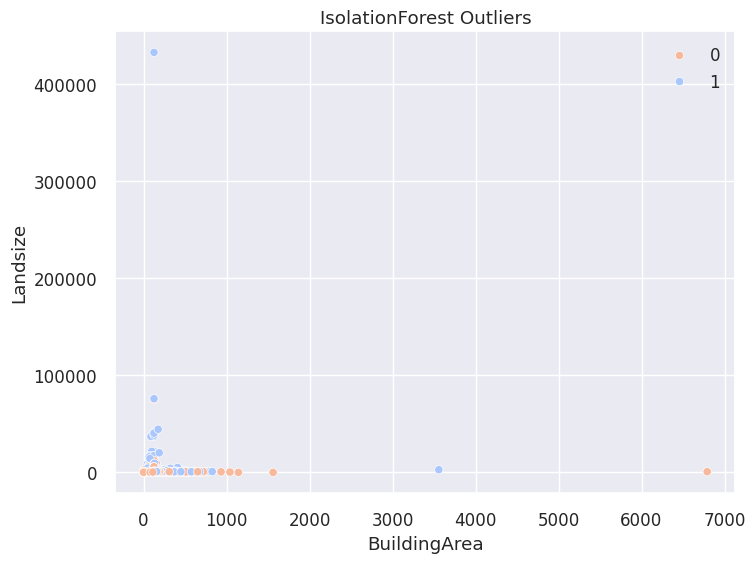

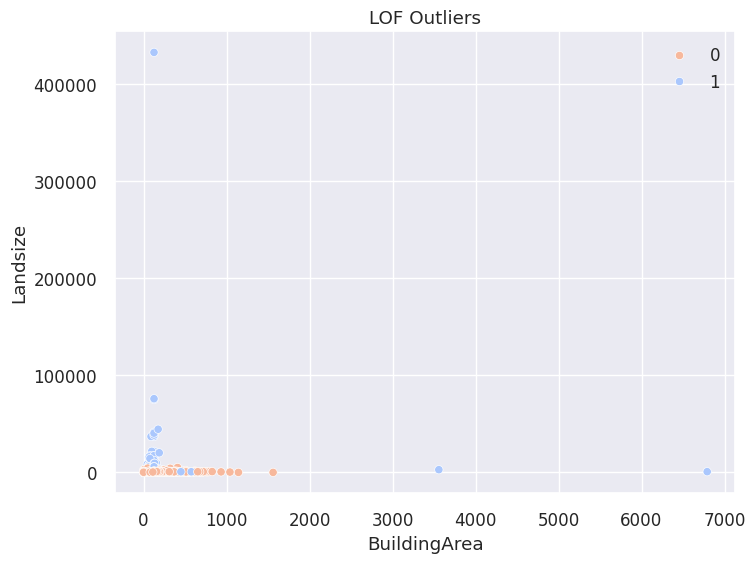

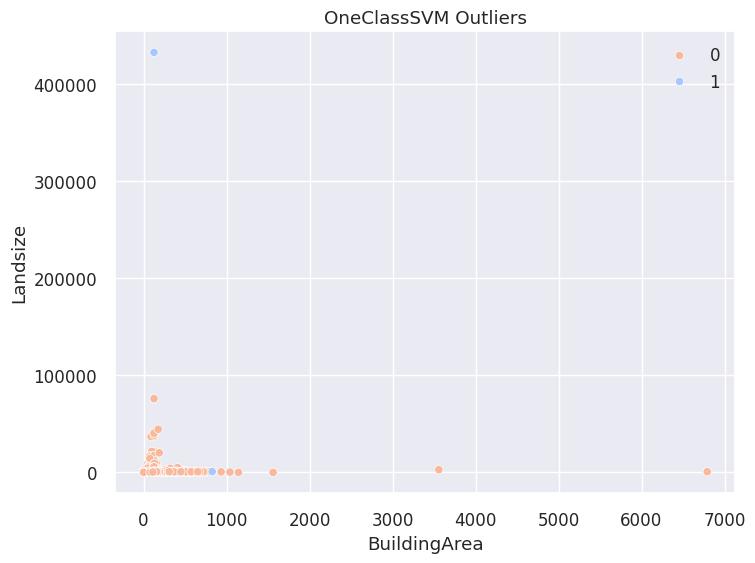

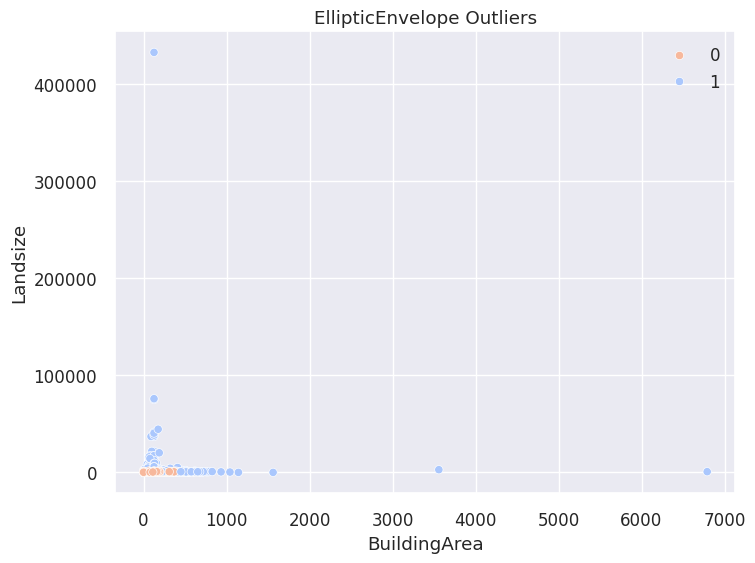

In [189]:
top_cols = find_suspicious_features(df, results, numeric_cols, top_n=4)
for i in range(4):
  for j in range(i+1,4):
    x_col, y_col = top_cols[i], top_cols[j]
    for model in results:
      plot_outliers_2d(df, x_col, y_col, results[model]["preds"],
                      title=f"{model} Outliers")

Тут хорошо видно, что энвилоуп и лес определили выбросы по району, возможно, действительно, стоит отнести эти данные к выбросам, ведь, их сильно меньше, чем остальных. В остальном же, выбросы по цене, что не так уж и удивительно

## Генерация признаков

### Обработка временного признака

In [190]:
# Обработка признака Date
def preprocessing_date_column(df_):
  df_copy = df_.copy()
  df_copy['Date'] = pd.to_datetime(df_copy['Date'], dayfirst=True)

  df_copy['year'] = df_copy['Date'].dt.year
  df_copy['month'] = df_copy['Date'].dt.month
  df_copy['day'] = df_copy['Date'].dt.day
  df_copy['day_of_week'] = df_copy['Date'].dt.dayofweek
  df_copy['is_weekend'] = df_copy['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

  day_of_week_period = 7
  df_copy['day_of_week_sin'] = np.sin(2 * np.pi * df_copy['day_of_week'] / day_of_week_period)
  df_copy['day_of_week_cos'] = np.cos(2 * np.pi * df_copy['day_of_week'] / day_of_week_period)
  df_copy = df_copy.drop("day_of_week", axis=1)

  month_period = 12
  df_copy['month_sin'] = np.sin(2 * np.pi * df_copy['month'] / month_period)
  df_copy['month_cos'] = np.cos(2 * np.pi * df_copy['month'] / month_period)
  df_copy = df_copy.drop("month", axis=1)

  df_copy = df_copy.drop("Date", axis=1)

  return df_copy

# Применяем кодирование признака Date ко всем выборкам
X_train = preprocessing_date_column(X_train)
X_val = preprocessing_date_column(X_val)
X_test = preprocessing_date_column(X_test)

Нет смысла добавлять признак праздника `is_holiday`, потому что при его добавлении все наблюдения получают значение 0 для этого признака.

Это можно логически объяснить, ведь данные в датасете - это продажи недвижимости на аукционе. И скорее всего, в официальные праздничные дни такие продажи не происходят.

In [191]:
# Промежуточные метрики после обработки временного признака
categorical_cols = [i for i in categorical_cols if i != "Date"]
date_feature_encoding_results = get_intermidate_metrics(X_train, y_train, X_val, y_val, categorical_cols, "date_feature_encoding")
res_intermidate_metrics.update(date_feature_encoding_results)
df_res = pd.DataFrame.from_dict(res_intermidate_metrics, orient='index',
                                columns=ALL_METRICS)
df_res

Learning rate set to 0.071504
0:	learn: 0.5163093	test: 0.4852968	best: 0.4852968 (0)	total: 20.9ms	remaining: 20.9s
100:	learn: 0.2025865	test: 0.2620499	best: 0.2620499 (100)	total: 1.92s	remaining: 17.1s
200:	learn: 0.1814795	test: 0.2305273	best: 0.2305273 (200)	total: 5.17s	remaining: 20.5s
300:	learn: 0.1698849	test: 0.2230825	best: 0.2230708 (298)	total: 7.05s	remaining: 16.4s
400:	learn: 0.1624473	test: 0.2197882	best: 0.2197882 (400)	total: 9.01s	remaining: 13.5s
500:	learn: 0.1565487	test: 0.2176367	best: 0.2165674 (467)	total: 10.9s	remaining: 10.9s
600:	learn: 0.1514915	test: 0.2145580	best: 0.2144936 (599)	total: 12.9s	remaining: 8.54s
700:	learn: 0.1470478	test: 0.2135887	best: 0.2135537 (695)	total: 15s	remaining: 6.39s
800:	learn: 0.1429554	test: 0.2122937	best: 0.2122579 (793)	total: 18.4s	remaining: 4.57s
900:	learn: 0.1391156	test: 0.2109335	best: 0.2106217 (873)	total: 20.5s	remaining: 2.25s
999:	learn: 0.1356328	test: 0.2105337	best: 0.2104945 (998)	total: 22.5s	re

rmse_train       rmse_val
Catboost_baseline               203991.248249  269203.054416
Linreg_baseline                 253387.388905  379754.136154
Catboost_manual_fix_outliers    212824.648236  272432.119800
Linreg_manual_fix_outliers      246462.305144  373722.030303
Catboost_outliers_flags         207734.879360  271619.956505
Linreg_outliers_flags           257496.720964  373138.399268
Catboost_date_feature_encoding  196189.111491  258913.067210
Linreg_date_feature_encoding    259535.346993  368703.648107

### Обработка категориальных признаков

In [192]:
# Посмотрим ещё раз на категориальные признаки
categorical_cols

['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'CouncilArea', 'Regionname']

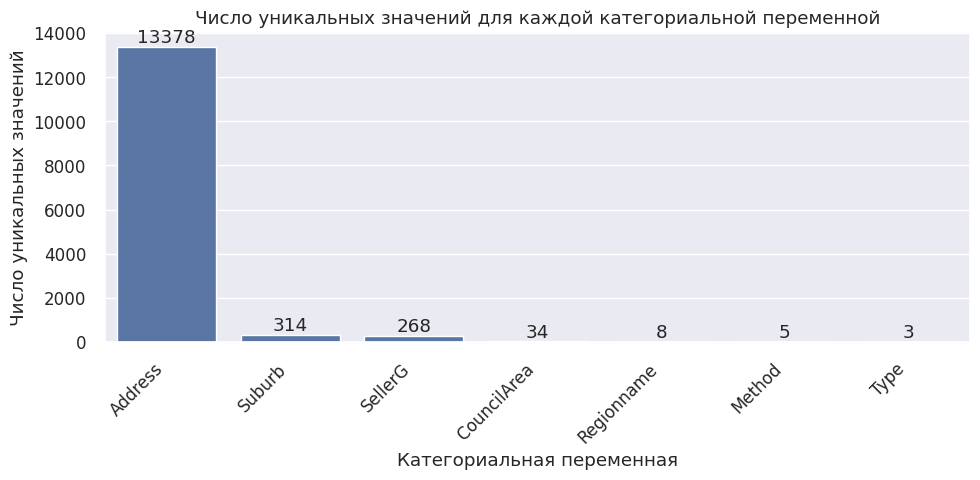

In [193]:
# Для начала поймем, сколько уникальных значений у каждого категориального признака
unique_counts = df[categorical_cols].nunique().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=unique_counts.index, y=unique_counts.values)
plt.title('Число уникальных значений для каждой категориальной переменной')
plt.xlabel('Категориальная переменная')
plt.ylabel('Число уникальных значений')
plt.xticks(rotation=45, ha='right')

# Подписи с числом уникальных значений
for index, value in enumerate(unique_counts.values):
    plt.text(index, value + 0.5, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()

Признак `Address` очень бесполезен, поскольку для каждого наблюдения в датасете он принимает уникальное значение.

Географические данные и так содержатся в других переменных (напимер `Suburb`, `Lattitude` и `Longtitude`).

Если бы датасет был больше, то из `Address` можно было бы извлечь информацию об улице, что могло бы добавить информативности. Но так как датасет всего на 14 тысяч строк, это скорее добавит только шума в данные.

Признак не вносит никакой информативности для модели, поэтому правильным решением будет удалить её, и заново посмотреть на число уникальных значений для всех оставшихся категориальный переменных.

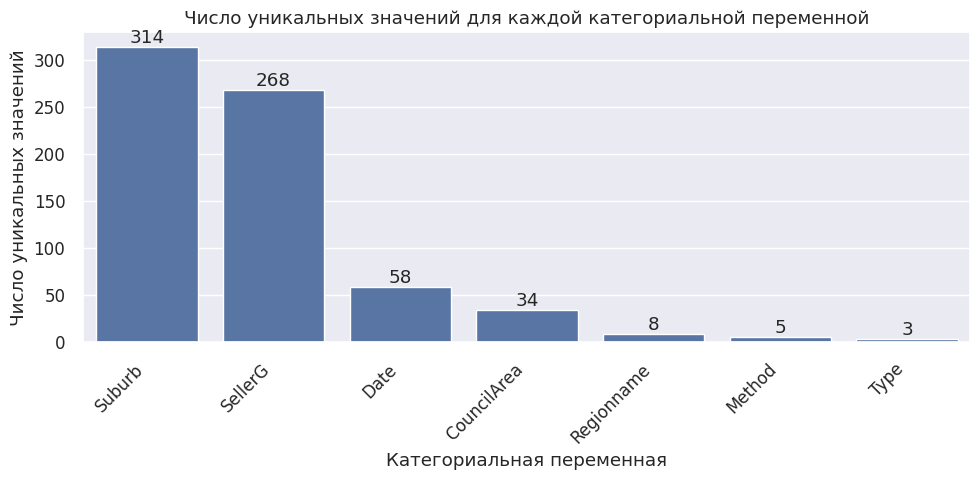

In [194]:
# Удаляем переменную Address и заново смотрим на график
df = df.drop("Address", axis=1, errors="ignore")
X_train = X_train.drop("Address", axis=1, errors="ignore")
X_val = X_val.drop("Address", axis=1, errors="ignore")
X_test = X_test.drop("Address", axis=1, errors="ignore")
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

unique_counts = df[categorical_cols].nunique().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=unique_counts.index, y=unique_counts.values)
plt.title('Число уникальных значений для каждой категориальной переменной')
plt.xlabel('Категориальная переменная')
plt.ylabel('Число уникальных значений')
plt.xticks(rotation=45, ha='right')

# Подписи с числом уникальных значений
for index, value in enumerate(unique_counts.values):
    plt.text(index, value + 0.5, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()

Признаки `Regionname`, `Method` и `Type` закодируем с помощью One Hot Encoding, так как они принимают очень мало уникальных значений.

Признаки `Suburb`, `SellerG` и `CouncilArea` закодируем с помощью TargetEncoding, так как они принимают довольно много уникальных значений.

Label Encoding тут не применим, так как нет переменных с естественным порядком.



In [195]:
# Признаки, которые будут закодированы с помощью OHE
cat_to_ohe = ["Regionname", "Method", "Type"]

# Признаки, которые будут закодированы с помощью TargetEncoding
cat_to_target_encoder = ["Suburb", "SellerG", "CouncilArea"]

cat_preprocessor = ColumnTransformer(
    transformers=[
        ('cat_to_ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'), cat_to_ohe),
        # shuffle = False, так как данные с временной меткой
        ('cat_to_target_encoder', TargetEncoder(target_type="continuous", shuffle=False), cat_to_target_encoder)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

cat_preprocessor.set_output(transform="pandas")
cat_preprocessor.fit(X_train, y_train)
feature_names_out = cat_preprocessor.get_feature_names_out()

# Применяем кодирование ко всем выборкам
X_train = cat_preprocessor.transform(X_train)
X_val = cat_preprocessor.transform(X_val)
X_test = cat_preprocessor.transform(X_test)

In [196]:
# Промежуточные метрики после обработки категориальных признаков
categorical_cols = []
cat_features_encoding_results = get_intermidate_metrics(X_train, y_train, X_val, y_val, categorical_cols, "cat_features_encoding")
res_intermidate_metrics.update(cat_features_encoding_results)
df_res = pd.DataFrame.from_dict(res_intermidate_metrics, orient='index',
                                columns=ALL_METRICS)
df_res

Learning rate set to 0.071504
0:	learn: 0.5154201	test: 0.4871590	best: 0.4871590 (0)	total: 4.35ms	remaining: 4.34s
100:	learn: 0.1936121	test: 0.3341691	best: 0.3341691 (100)	total: 405ms	remaining: 3.61s
200:	learn: 0.1745691	test: 0.3159458	best: 0.3156366 (195)	total: 795ms	remaining: 3.16s
300:	learn: 0.1627721	test: 0.3018400	best: 0.3018400 (300)	total: 1.15s	remaining: 2.66s
400:	learn: 0.1536659	test: 0.2948915	best: 0.2946996 (398)	total: 1.53s	remaining: 2.28s
500:	learn: 0.1467760	test: 0.2899855	best: 0.2899855 (500)	total: 1.88s	remaining: 1.87s
600:	learn: 0.1407154	test: 0.2852808	best: 0.2851275 (599)	total: 2.24s	remaining: 1.49s
700:	learn: 0.1353664	test: 0.2829299	best: 0.2826555 (694)	total: 2.62s	remaining: 1.12s
800:	learn: 0.1305201	test: 0.2809634	best: 0.2809634 (800)	total: 2.99s	remaining: 743ms
900:	learn: 0.1264756	test: 0.2798695	best: 0.2796442 (860)	total: 3.38s	remaining: 371ms
999:	learn: 0.1226749	test: 0.2780045	best: 0.2779077 (997)	total: 3.89s	

rmse_train       rmse_val
Catboost_baseline               203991.248249  269203.054416
Linreg_baseline                 253387.388905  379754.136154
Catboost_manual_fix_outliers    212824.648236  272432.119800
Linreg_manual_fix_outliers      246462.305144  373722.030303
Catboost_outliers_flags         207734.879360  271619.956505
Linreg_outliers_flags           257496.720964  373138.399268
Catboost_date_feature_encoding  196189.111491  258913.067210
Linreg_date_feature_encoding    259535.346993  368703.648107
Catboost_cat_features_encoding  167803.184637  303859.863377
Linreg_cat_features_encoding    343995.530098  352151.699100

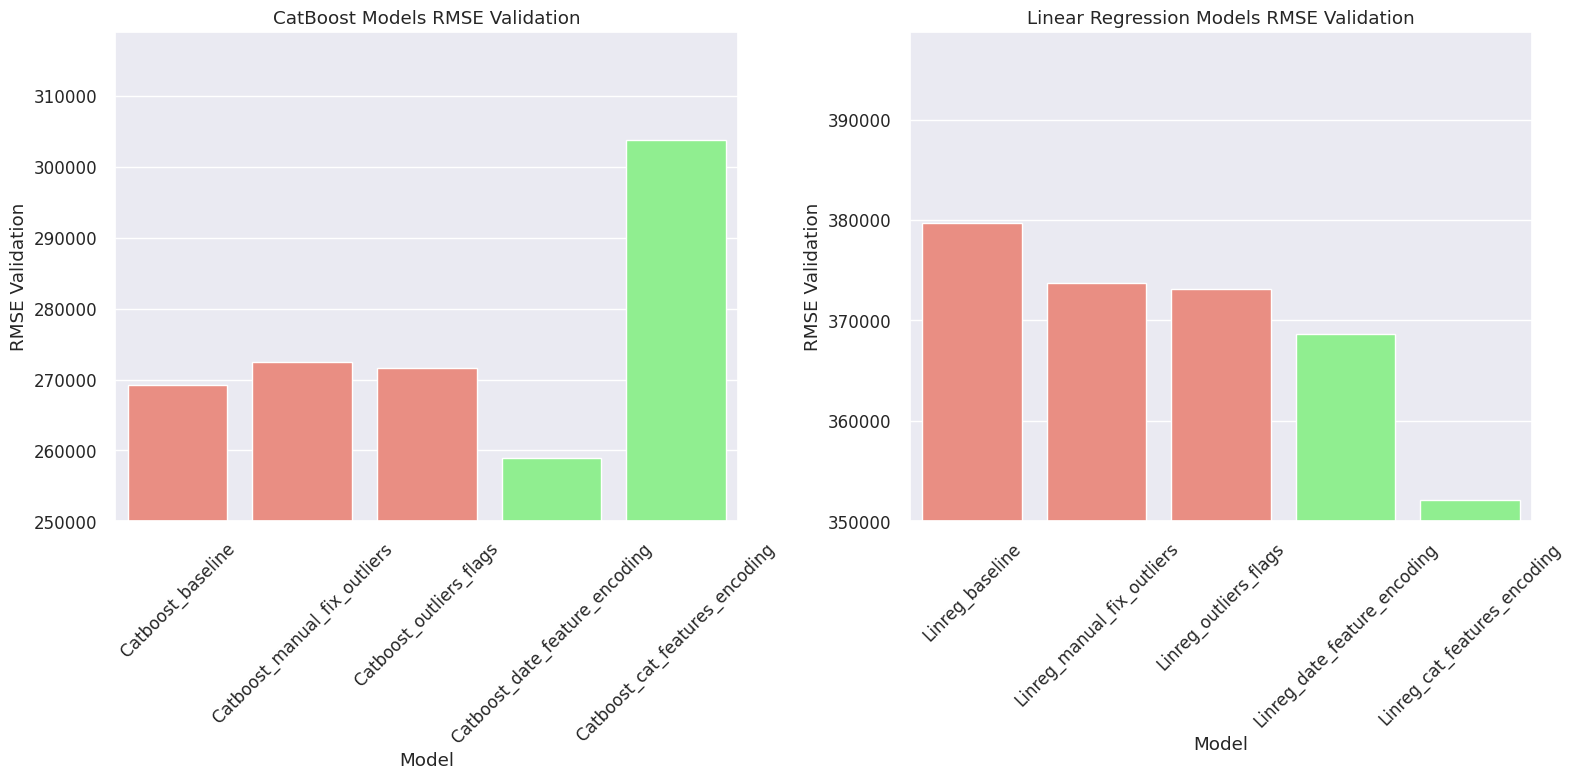

In [197]:
catboost_metrics = df_res[df_res.index.str.contains('Catboost')][['rmse_val']]
linreg_metrics = df_res[df_res.index.str.contains('Linreg')][['rmse_val']]

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

sns.barplot(x=catboost_metrics.index, y='rmse_val', data=catboost_metrics, ax=axes[0], color="salmon")
axes[0].set_title('CatBoost Models RMSE Validation')
axes[0].set_ylabel('RMSE Validation')
axes[0].set_xlabel('Model')
axes[0].set_ylim(250000)
axes[0].tick_params(axis='x', rotation=45)
for bar in axes[0].patches[-2:]:
        bar.set_facecolor('lightgreen')

sns.barplot(x=linreg_metrics.index, y='rmse_val', data=linreg_metrics, ax=axes[1], color="salmon")
axes[1].set_title('Linear Regression Models RMSE Validation')
axes[1].set_ylabel('RMSE Validation')
axes[1].set_xlabel('Model')
axes[1].set_ylim(350000)
axes[1].tick_params(axis='x', rotation=45)
for bar in axes[1].patches[-2:]:
        bar.set_facecolor('lightgreen')

plt.tight_layout()
plt.show()

После кодирования категориальных признаков качество для кэтбуста стало хуже, а для линейной регрессии - лучше.

Очень ожидаемый результат, так как CatBoost по умолчанию "из коробки" очень хорошо кодирует категориальные признаки.

Линейная регрессия же, напротив, не умеет работать с категориальными признаками. Поэтому то, что мы их обрабатываем ручками, а не просто выбрасываем - дает прирост метрик.

### Признаки, основанные на ближайших соседях

In [198]:
# Для удобства создадим полные датафреймы
train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

In [199]:
N_NEIGHBORS = 5

coords_train = train_df[['Lattitude', 'Longtitude']].values
knn = NearestNeighbors(n_neighbors=N_NEIGHBORS + 1, metric='euclidean')
knn.fit(coords_train)

NearestNeighbors(metric='euclidean', n_neighbors=6)

In [200]:
def generate_neighbor_features(target_df, reference_df, knn_model, k):
    coords_target = target_df[['Lattitude', 'Longtitude']].values
    distances, indices = knn_model.kneighbors(coords_target)

    is_train = target_df.equals(reference_df)

    if is_train:
        distances = distances[:, 1:]
        indices = indices[:, 1:]
    else:
        distances = distances[:, :k]
        indices = indices[:, :k]

    neighbor_prices = reference_df['Price'].values[indices]
    mean_neighbor_price = neighbor_prices.mean(axis=1)
    dist_to_nearest = distances[:, 0]
    density_feature = distances.mean(axis=1)

    new_features = pd.DataFrame({
        'mean_neighbor_price': mean_neighbor_price,
        'dist_to_nearest': dist_to_nearest,
        'density_k_neighbors': density_feature
    }, index=target_df.index)

    return new_features

In [201]:
# Генерация фичей, основанных на соседях
train_neighbor_features = generate_neighbor_features(train_df, train_df, knn, N_NEIGHBORS)
val_neighbor_features = generate_neighbor_features(val_df, train_df, knn, N_NEIGHBORS)
test_neighbor_features = generate_neighbor_features(test_df, train_df, knn, N_NEIGHBORS)

# Добавляем их к остальным фичам
X_train = pd.concat([X_train, train_neighbor_features], axis=1)
X_val = pd.concat([X_val, val_neighbor_features], axis=1)
X_test = pd.concat([X_test, test_neighbor_features], axis=1)

In [202]:
neighbor_features_results = get_intermidate_metrics(X_train, y_train, X_val, y_val, categorical_cols, "neighbor_features")
res_intermidate_metrics.update(neighbor_features_results)
df_res = pd.DataFrame.from_dict(res_intermidate_metrics, orient='index',
                                columns=ALL_METRICS)
df_res

Learning rate set to 0.071504
0:	learn: 0.5150673	test: 0.4868489	best: 0.4868489 (0)	total: 15ms	remaining: 15s
100:	learn: 0.1910849	test: 0.3036067	best: 0.3036067 (100)	total: 1.13s	remaining: 10s
200:	learn: 0.1714122	test: 0.2814756	best: 0.2814756 (200)	total: 1.83s	remaining: 7.29s
300:	learn: 0.1586948	test: 0.2713793	best: 0.2710981 (298)	total: 2.3s	remaining: 5.35s
400:	learn: 0.1495027	test: 0.2663641	best: 0.2661638 (396)	total: 2.79s	remaining: 4.17s
500:	learn: 0.1416114	test: 0.2604898	best: 0.2603544 (487)	total: 3.24s	remaining: 3.23s
600:	learn: 0.1352141	test: 0.2559777	best: 0.2559777 (600)	total: 3.72s	remaining: 2.47s
700:	learn: 0.1300966	test: 0.2539425	best: 0.2536655 (691)	total: 4.16s	remaining: 1.77s
800:	learn: 0.1247149	test: 0.2534252	best: 0.2529065 (752)	total: 4.62s	remaining: 1.15s
900:	learn: 0.1204927	test: 0.2543990	best: 0.2528294 (811)	total: 5.06s	remaining: 556ms
999:	learn: 0.1162508	test: 0.2526291	best: 0.2526138 (998)	total: 5.54s	remaini

rmse_train       rmse_val
Catboost_baseline               203991.248249  269203.054416
Linreg_baseline                 253387.388905  379754.136154
Catboost_manual_fix_outliers    212824.648236  272432.119800
Linreg_manual_fix_outliers      246462.305144  373722.030303
Catboost_outliers_flags         207734.879360  271619.956505
Linreg_outliers_flags           257496.720964  373138.399268
Catboost_date_feature_encoding  196189.111491  258913.067210
Linreg_date_feature_encoding    259535.346993  368703.648107
Catboost_cat_features_encoding  167803.184637  303859.863377
Linreg_cat_features_encoding    343995.530098  352151.699100
Catboost_neighbor_features      157030.189746  279689.623268
Linreg_neighbor_features        339465.621881  370690.026131

## Контекстные признаки, отражающие специфику задачи

In [203]:
# Так как с помощью TargetEncoding мы уже достаточно обогатили наш датасет
# Фичами, связанными с ценой, сейчас можем заняться другими контекстными признаками

def generate_context_features(df_):
  df_copy = df_.copy()

  df_copy["BathroomsPerRoom"] = np.where(df_copy['Rooms'] > 0, df_copy['Bathroom'] / df_copy['Rooms'], 0).astype(float)
  df_copy['LandUseRatio'] = np.where(df_copy["Landsize"] > 0, df_copy["BuildingArea"] / (df_copy["Landsize"] + 1), 0).astype(float)

  return df_copy

X_train = generate_context_features(X_train)
X_val = generate_context_features(X_val)
X_test = generate_context_features(X_test)

Гипотезы связанные с этими контекстными признаками.

1. `BathroomsPerRoom` (отношение числа ванных комнат к числу спальных комнат) - большое число ванных комнат на обычные комнаты может свидетельствовать о премиальности дома

2. `LandUseRatio` (отношение жилой площади к площади земельного участка) - роскошные дома зачастую имеют большие придворовые участки, во много раз превышающие жилую площадь

In [204]:
# Промежуточные метрики после добавления контекстных признаков
context_features_results = get_intermidate_metrics(X_train, y_train, X_val, y_val, categorical_cols, "context_features")
res_intermidate_metrics.update(context_features_results)
df_res = pd.DataFrame.from_dict(res_intermidate_metrics, orient='index',
                                columns=ALL_METRICS)
df_res

Learning rate set to 0.071504
0:	learn: 0.5147425	test: 0.4824534	best: 0.4824534 (0)	total: 9.05ms	remaining: 9.04s
100:	learn: 0.1896980	test: 0.3103582	best: 0.3103582 (100)	total: 470ms	remaining: 4.19s
200:	learn: 0.1699482	test: 0.2876942	best: 0.2876942 (200)	total: 930ms	remaining: 3.7s
300:	learn: 0.1566728	test: 0.2758947	best: 0.2758947 (300)	total: 1.47s	remaining: 3.42s
400:	learn: 0.1475337	test: 0.2723166	best: 0.2723166 (400)	total: 1.98s	remaining: 2.95s
500:	learn: 0.1397544	test: 0.2696725	best: 0.2695854 (469)	total: 2.49s	remaining: 2.48s
600:	learn: 0.1328863	test: 0.2662157	best: 0.2655506 (579)	total: 2.95s	remaining: 1.96s
700:	learn: 0.1270245	test: 0.2630674	best: 0.2630293 (690)	total: 3.47s	remaining: 1.48s
800:	learn: 0.1218936	test: 0.2621538	best: 0.2618714 (791)	total: 3.94s	remaining: 979ms
900:	learn: 0.1171072	test: 0.2592519	best: 0.2591820 (899)	total: 4.43s	remaining: 486ms
999:	learn: 0.1125767	test: 0.2575915	best: 0.2575821 (998)	total: 4.89s	r

rmse_train       rmse_val
Catboost_baseline               203991.248249  269203.054416
Linreg_baseline                 253387.388905  379754.136154
Catboost_manual_fix_outliers    212824.648236  272432.119800
Linreg_manual_fix_outliers      246462.305144  373722.030303
Catboost_outliers_flags         207734.879360  271619.956505
Linreg_outliers_flags           257496.720964  373138.399268
Catboost_date_feature_encoding  196189.111491  258913.067210
Linreg_date_feature_encoding    259535.346993  368703.648107
Catboost_cat_features_encoding  167803.184637  303859.863377
Linreg_cat_features_encoding    343995.530098  352151.699100
Catboost_neighbor_features      157030.189746  279689.623268
Linreg_neighbor_features        339465.621881  370690.026131
Catboost_context_features       152277.648230  282714.119124
Linreg_context_features         339467.272548  374933.596882

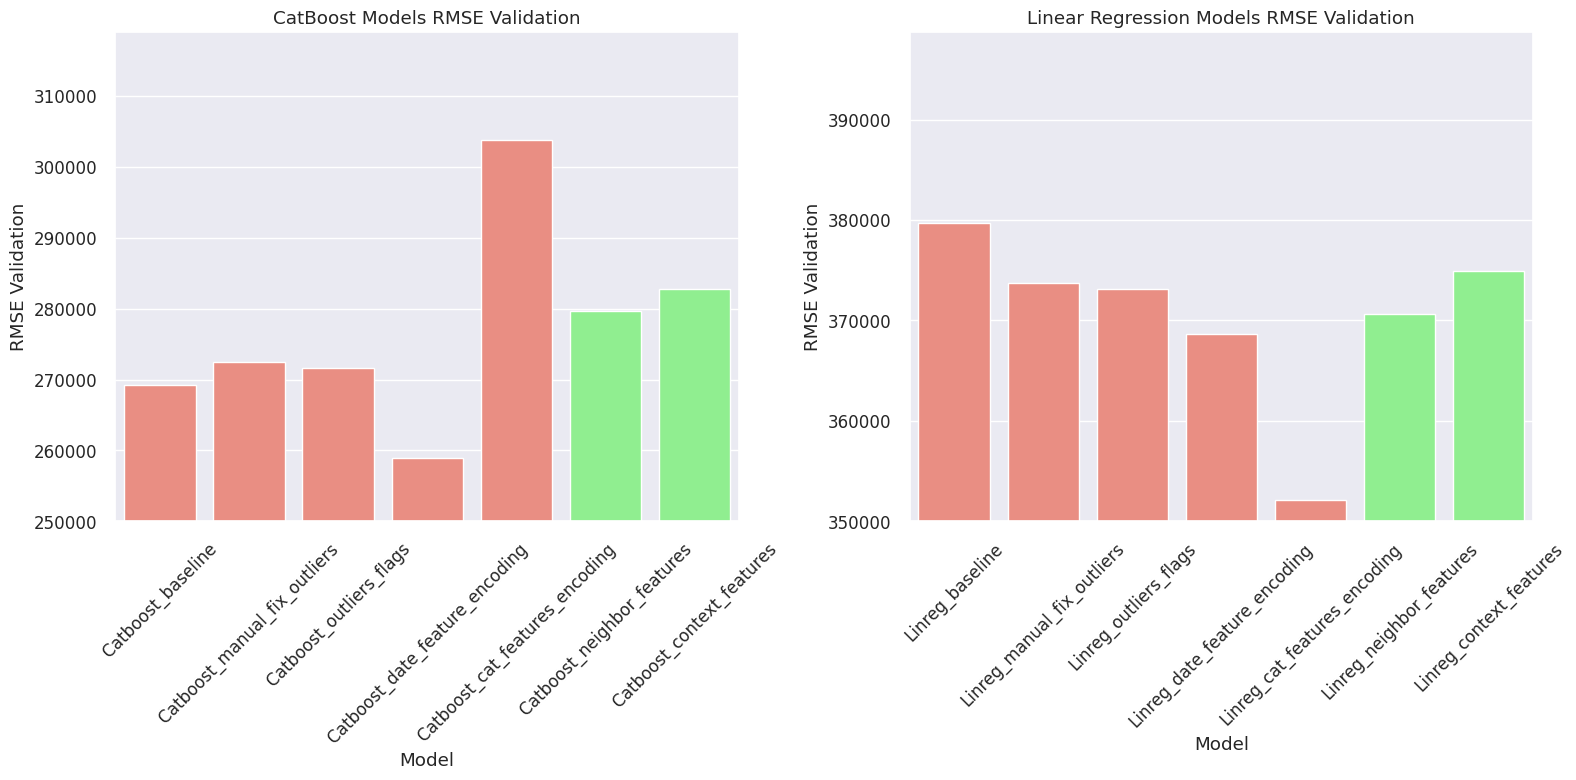

In [205]:
catboost_metrics = df_res[df_res.index.str.contains('Catboost')][['rmse_val']]
linreg_metrics = df_res[df_res.index.str.contains('Linreg')][['rmse_val']]

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

sns.barplot(x=catboost_metrics.index, y='rmse_val', data=catboost_metrics, ax=axes[0], color="salmon")
axes[0].set_title('CatBoost Models RMSE Validation')
axes[0].set_ylabel('RMSE Validation')
axes[0].set_xlabel('Model')
axes[0].set_ylim(250000)
axes[0].tick_params(axis='x', rotation=45)
for bar in axes[0].patches[-2:]:
        bar.set_facecolor('lightgreen')

sns.barplot(x=linreg_metrics.index, y='rmse_val', data=linreg_metrics, ax=axes[1], color="salmon")
axes[1].set_title('Linear Regression Models RMSE Validation')
axes[1].set_ylabel('RMSE Validation')
axes[1].set_xlabel('Model')
axes[1].set_ylim(350000)
axes[1].tick_params(axis='x', rotation=45)
for bar in axes[1].patches[-2:]:
        bar.set_facecolor('lightgreen')

plt.tight_layout()
plt.show()

## Отбор признаков

In [206]:
# ФИЛЬТРЫ
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
num_cols_no_dummy = [col for col in num_cols if
                     "Regionname_" not in col and
                     "Method_" not in col and
                     "Type_" not in col]

print("Числовых признаков:", len(num_cols))
print("Числовых признаков без дамми-переменных:", len(num_cols_no_dummy))

# Корреляция с таргетом
corr_with_target = X_train[num_cols].corrwith(y_train).abs().sort_values(ascending=False)
corr_thresh = 0.4
selected_by_corr = corr_with_target[corr_with_target > corr_thresh].index.tolist()
print(f"Отфильтровано по corr > {corr_thresh}: {len(selected_by_corr)} признаков")

corr_with_target.head(len(selected_by_corr) + 3)

Числовых признаков: 37
Числовых признаков без дамми-переменных: 27
Отфильтровано по corr > 0.4: 8 признаков


Rooms                               0.562091
mean_neighbor_price                 0.533757
Bedroom2                            0.531926
Suburb                              0.526192
Bathroom                            0.516538
SellerG                             0.454358
Type_u                              0.444784
CouncilArea                         0.432844
Regionname_Southern Metropolitan    0.306165
BuildingArea                        0.287935
Car                                 0.287533
dtype: float64

In [208]:
# ANOVA, f_regression
k = min(30, X_train.shape[1])
selector_anova = SelectKBest(score_func=f_regression, k=k)
selector_anova.fit(X_train, y_train)
scores_anova = pd.Series(selector_anova.scores_, index=X_train.columns).sort_values(ascending=False)
scores_anova.head(40)

Rooms                                    4013.214536
mean_neighbor_price                      3461.693834
Bedroom2                                 3428.618600
Suburb                                   3326.953092
Bathroom                                 3161.970274
SellerG                                  2260.408183
Type_u                                   2142.908467
CouncilArea                              2003.233386
Regionname_Southern Metropolitan          898.723902
BuildingArea                              785.500549
Car                                       783.106694
YearBuilt                                 638.979657
PostcodeParted                            616.698698
Longtitude                                614.508657
Lattitude                                 553.641624
Regionname_Northern Metropolitan          271.677773
Regionname_Western Metropolitan           242.010632
dist_to_nearest                           139.381179
Method_SP                                 117.658739
density_k_neighbors                        71.295129
Type_t                                     50.153483
Landsize                                   44.420179
Distance                                   38.238569
Method_S                                   35.600089
is_weekend                                 21.167241
day_of_week_sin                            18.258151
month_cos                                  16.228902
year                                       10.319038
Propertycount                               9.739832
LandUseRatio                                7.699350
day_of_week_cos                             5.551307
day                                         2.071514
Method_VB                                   1.941189
Regionname_South-Eastern Metropolitan       1.684158
Method_SA                                   0.663652
BathroomsPerRoom                            0.481191
month_sin                                   0.470824
dtype: float64

In [209]:
# RFECV (используем RandomForest)
# Берём кандидатов: top по corr + top по anova
candidates = list(pd.Index(selected_by_corr).append(scores_anova.head(50).index).unique())
print("Кандидатов для RFECV:", len(candidates))

rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
tscv = TimeSeriesSplit(n_splits=5)

# Подготовка X_for_rfecv
#X_for_rfecv = X_train[candidates]

#rfecv = RFECV(estimator=rf, step=1, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1, min_features_to_select=5)
#rfecv.fit(X_for_rfecv, y_train)
#print("RFECV optimal n_features:", rfecv.n_features_)
#selected_rfecv = X_for_rfecv.columns[rfecv.support_].tolist()

selected_rfecv = [
    'mean_neighbor_price',
    'Rooms',
    'Suburb',
    'Bathroom',
    'SellerG',
    'Type_u',
    'CouncilArea',
    'BuildingArea',
    'PropertyAge',
    'Longtitude',
    'Lattitude',
    'Landsize',
    'Distance'
]#оно обучалось 1.30 я записал итоговый результат для удобства
print("RFECV selected:", selected_rfecv)

Кандидатов для RFECV: 37
RFECV selected: ['mean_neighbor_price', 'Rooms', 'Suburb', 'Bathroom', 'SellerG', 'Type_u', 'CouncilArea', 'BuildingArea', 'PropertyAge', 'Longtitude', 'Lattitude', 'Landsize', 'Distance']


In [210]:
# Optuna
# def optuna_objective(trial):
#     chosen_features = []
#     for feature in candidates:
#         if trial.suggest_categorical(f'{feature}', [True, False]):
#             chosen_features.append(feature)

#     if not chosen_features:
#         raise optuna.exceptions.TrialPruned()

#     model = CatBoostRegressor(random_state=42, verbose=0)
#     scores = cross_val_score(model, X_train[chosen_features], y_train, cv=tscv, scoring='neg_root_mean_squared_error')
#     return -np.mean(scores)

# sampler = TPESampler(seed=42)
# study = optuna.create_study(direction='minimize', sampler=sampler)
# study.optimize(optuna_objective, n_trials=25)
# best_params = study.best_trial.params
# selected_optuna = [param_name for param_name, param_value in best_params.items() if param_value]

# Тоже долго обучается, вот финальный резлуьтат
selected_optuna = ['Rooms', 'Suburb', 'Bathroom', 'Type_u', 'CouncilArea', 'Regionname_Southern Metropolitan', 'BuildingArea', 'Car', 'YearBuilt', 'PostcodeParted', 'Lattitude', 'Regionname_Northern Metropolitan', 'Regionname_Western Metropolitan', 'Method_SP', 'Type_t', 'Landsize', 'is_weekend', 'year', 'LandUseRatio', 'Method_VB', 'BathroomsPerRoom', 'month_sin']

In [211]:
# Lasso (L1)
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
pipe = make_pipeline(StandardScaler(), LassoCV(cv=tscv, random_state=42, n_jobs=-1))
pipe.fit(X_train[num_cols], y_train)
coefs = pd.Series(pipe.named_steps['lassocv'].coef_, index=num_cols).sort_values(key=lambda x: x.abs(), ascending=False)
selected_l1 = coefs[coefs.abs() > 1e-6].index.tolist()
print("L1 selected (count):", len(selected_l1))
coefs.head(50)

L1 selected (count): 23


Type_u                                  -160856.238560
Rooms                                    146298.595357
Bathroom                                 123768.425140
Suburb                                   120878.986984
Distance                                -100713.189284
mean_neighbor_price                       85276.660738
SellerG                                   77071.494300
Type_t                                   -68119.326752
Car                                       51433.638073
YearBuilt                                -50686.487395
BuildingArea                              33090.089451
Regionname_Southern Metropolitan          29586.857363
Method_S                                  29319.906701
Lattitude                                -29192.978635
year                                      28753.511698
month_cos                                 12657.446058
Regionname_Western Metropolitan          -11543.422451
Landsize                                   9336.025815
Bedroom2                                   8410.688620
PostcodeParted                             6835.264918
Propertycount                              1418.908822
dist_to_nearest                             851.074394
LandUseRatio                               -680.717088
Regionname_South-Eastern Metropolitan        -0.000000
Regionname_Northern Metropolitan             -0.000000
Method_VB                                    -0.000000
Method_SP                                     0.000000
Method_SA                                     0.000000
CouncilArea                                   0.000000
day_of_week_sin                               0.000000
is_weekend                                    0.000000
day                                          -0.000000
Longtitude                                    0.000000
day_of_week_cos                              -0.000000
month_sin                                    -0.000000
density_k_neighbors                          -0.000000
BathroomsPerRoom                             -0.000000
dtype: float64

In [212]:
# CatBoost feature importances
model_cb = CatBoostRegressor(iterations=1000, learning_rate=0.05, depth=6, verbose=0, random_state=42)
model_cb.fit(X_train, y_train)
fi = pd.Series(model_cb.get_feature_importance(), index=X_train.columns).sort_values(ascending=False)
selected_by_tree = fi.head(40).index.tolist()
fi.head(40)

Type_u                                   11.989307
Rooms                                     9.741930
Suburb                                    9.581816
Distance                                  9.446894
Landsize                                  8.584643
mean_neighbor_price                       6.145015
Bathroom                                  5.661212
BuildingArea                              5.520051
SellerG                                   4.007470
Bedroom2                                  3.325108
YearBuilt                                 3.284945
CouncilArea                               3.048334
Lattitude                                 2.699178
LandUseRatio                              2.321425
Longtitude                                2.127146
Car                                       1.876173
Regionname_Southern Metropolitan          1.795392
Type_t                                    1.186001
PostcodeParted                            0.994039
year                                      0.977000
Method_S                                  0.956085
density_k_neighbors                       0.941853
BathroomsPerRoom                          0.906090
Propertycount                             0.728129
dist_to_nearest                           0.719139
month_cos                                 0.527225
day                                       0.370812
month_sin                                 0.241612
Method_SP                                 0.143755
Method_VB                                 0.070826
day_of_week_sin                           0.033788
day_of_week_cos                           0.025446
Regionname_Northern Metropolitan          0.011887
Regionname_Western Metropolitan           0.008109
is_weekend                                0.002168
Regionname_South-Eastern Metropolitan     0.000000
Method_SA                                 0.000000
dtype: float64

In [213]:
# Permutation importance (на валидации)
perm = permutation_importance(model_cb, X_val, y_val, n_repeats=10, random_state=42, n_jobs=-1)
perm_ser = pd.Series(perm.importances_mean, index=X_val.columns).sort_values(ascending=False)
selected_perm = perm_ser[perm_ser > 0].index.tolist()
print("Permutation positive importances:", len(selected_perm))
perm_ser.head(40)

Permutation positive importances: 28


Distance                                 0.256692
Type_u                                   0.125582
Landsize                                 0.085497
Suburb                                   0.077395
Longtitude                               0.074761
Lattitude                                0.066694
Rooms                                    0.061717
mean_neighbor_price                      0.051439
BuildingArea                             0.046775
Bathroom                                 0.036291
SellerG                                  0.028352
density_k_neighbors                      0.020229
CouncilArea                              0.019169
YearBuilt                                0.016347
Car                                      0.014565
Bedroom2                                 0.012723
PostcodeParted                           0.010467
Regionname_Southern Metropolitan         0.010216
Method_S                                 0.007549
Type_t                                   0.006587
LandUseRatio                             0.005580
dist_to_nearest                          0.002236
day                                      0.000185
month_sin                                0.000157
Method_SP                                0.000143
Method_VB                                0.000084
Regionname_Western Metropolitan          0.000038
BathroomsPerRoom                         0.000012
Regionname_South-Eastern Metropolitan    0.000000
day_of_week_cos                          0.000000
Method_SA                                0.000000
year                                     0.000000
is_weekend                               0.000000
day_of_week_sin                          0.000000
Regionname_Northern Metropolitan        -0.000018
month_cos                               -0.000132
Propertycount                           -0.001231
dtype: float64

In [214]:
# Умное голосование за важность признаков с учетом сложности метода и позиции признака в топе
weights = {
    'Permutation': 4.0,
    'CatBoost_FI': 2.0,
    'Lasso_L1': 1.5,
    'ANOVA': 1.0,
    'Correlation': 1.0,
    'RFECV': 3.0,
    'Optuna': 1.5,
}

def get_rank_score(feature_series, method_weight):
    """
    Превращает позицию в списке в балл.
    1-е место = 1.0 * weight
    Последнее место = ~0.0
    """
    features = feature_series.index.tolist()
    n = len(features)
    scores = {}

    for rank, feat in enumerate(features):
        norm_score = (n - rank) / n
        scores[feat] = norm_score * method_weight

    return scores

scores_perm = get_rank_score(perm_ser, weights['Permutation'])
scores_cb = get_rank_score(fi, weights['CatBoost_FI'])
scores_lasso = get_rank_score(coefs.abs(), weights['Lasso_L1'])
scores_anova_rank = get_rank_score(scores_anova, weights['ANOVA'])
scores_corr_rank = get_rank_score(corr_with_target.abs(), weights['Correlation'])

final_scores = {}
all_features = set(list(scores_perm.keys()) + list(scores_cb.keys()) +
                   list(scores_lasso.keys()) + list(scores_anova_rank.keys()))

for feat in all_features:
    total = 0

    total += scores_perm.get(feat, 0)
    total += scores_cb.get(feat, 0)
    total += scores_lasso.get(feat, 0)
    total += scores_anova_rank.get(feat, 0)
    total += scores_corr_rank.get(feat, 0)

    if feat in selected_rfecv:
        total += weights['RFECV']

    if feat in selected_optuna:
        total += weights['Optuna']

    final_scores[feat] = total

vote_df = pd.DataFrame(list(final_scores.items()), columns=['Feature', 'Score'])
vote_df = vote_df.sort_values(by='Score', ascending=False).reset_index(drop=True)

max_score = vote_df['Score'].max()

print(f"Всего рассмотрено признаков: {len(vote_df)}")
vote_df

Всего рассмотрено признаков: 37


Feature      Score
0                                  Type_u  13.567568
1                                  Suburb  13.283784
2                                   Rooms  13.256757
3                                Bathroom  12.405405
4                            BuildingArea  11.864865
5                                Landsize  11.743243
6                               Lattitude  11.527027
7                     mean_neighbor_price  11.216216
8                                Distance  10.986486
9                             CouncilArea  10.594595
10                                SellerG  10.472973
11                             Longtitude   9.310811
12                              YearBuilt   8.094595
13                                    Car   7.810811
14       Regionname_Southern Metropolitan   7.418919
15                         PostcodeParted   6.878378
16                                 Type_t   6.662162
17                               Bedroom2   6.554054
18                           LandUseRatio   5.675676
19        Regionname_Western Metropolitan   4.891892
20                              Method_SP   4.864865
21                               Method_S   4.743243
22                    density_k_neighbors   4.729730
23                                   year   4.594595
24                        dist_to_nearest   4.162162
25                              Method_VB   3.986486
26       Regionname_Northern Metropolitan   3.810811
27                              month_sin   3.729730
28                       BathroomsPerRoom   3.540541
29                             is_weekend   3.189189
30                                    day   2.783784
31                              month_cos   2.351351
32                          Propertycount   2.040541
33  Regionname_South-Eastern Metropolitan   1.864865
34                        day_of_week_sin   1.783784
35                        day_of_week_cos   1.729730
36                              Method_SA   1.378378

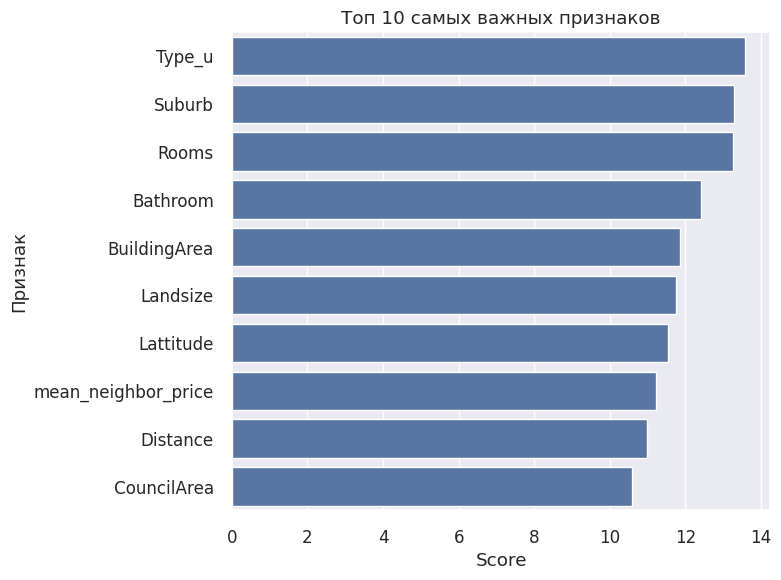

In [265]:
top_10_features = vote_df.head(10)

plt.figure(figsize=(8, 6))
sns.barplot(x='Score', y='Feature', data=top_10_features)
plt.title('Топ 10 самых важных признаков')
plt.xlabel('Score')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

In [215]:
# Разделим на ранний и поздний периоды
X_early, y_early, X_late, y_late = time_train_test_split(pd.concat([X_train, y_train], axis=1), need_val=False, test_size=0.3)
print("Early / Late sizes:", X_early.shape, X_late.shape)

# Важности на двух периодах
m_e = CatBoostRegressor(iterations=600, learning_rate=0.05, depth=6, verbose=0, random_state=42)
m_l = CatBoostRegressor(iterations=600, learning_rate=0.05, depth=6, verbose=0, random_state=42)
m_e.fit(X_early, y_early)
m_l.fit(X_late, y_late)

fi_e = pd.Series(m_e.get_feature_importance(), index=X_train.columns)
fi_l = pd.Series(m_l.get_feature_importance(), index=X_train.columns)

# Сравниваем, насколько сильно изменилась важность относительно других признаков
df_fi_rank = pd.DataFrame({
    'early_rank': fi_e.rank(ascending=False),
    'late_rank': fi_l.rank(ascending=False)
})
df_fi_rank['rank_change'] = (df_fi_rank['early_rank'] - df_fi_rank['late_rank']).abs()
df_fi_rank = df_fi_rank.sort_values('rank_change', ascending=False)

df_fi_rank.head(30)

Early / Late sizes: (6083, 37) (2608, 37)


early_rank  late_rank  rank_change
Regionname_Northern Metropolitan        35.0       29.0          6.0
LandUseRatio                            17.0       11.0          6.0
BathroomsPerRoom                        22.0       16.0          6.0
Rooms                                    2.0        8.0          6.0
YearBuilt                                9.0       14.0          5.0
year                                    28.0       24.0          4.0
Longtitude                              16.0       12.0          4.0
Car                                     13.0       17.0          4.0
Method_S                                19.0       23.0          4.0
month_cos                               23.0       27.0          4.0
is_weekend                              33.0       36.5          3.5
Regionname_Southern Metropolitan        15.0       18.0          3.0
dist_to_nearest                         25.0       22.0          3.0
PostcodeParted                          18.0       21.0          3.0
BuildingArea                             8.0        6.0          2.0
day_of_week_cos                         31.0       33.0          2.0
Method_VB                               30.0       32.0          2.0
Distance                                 5.0        3.0          2.0
Suburb                                   3.0        1.0          2.0
CouncilArea                             11.0       13.0          2.0
Bathroom                                 7.0        5.0          2.0
Bedroom2                                12.0       10.0          2.0
Method_SA                               36.5       35.0          1.5
mean_neighbor_price                      6.0        7.0          1.0
day_of_week_sin                         32.0       31.0          1.0
Type_t                                  20.0       19.0          1.0
Method_SP                               29.0       30.0          1.0
Type_u                                   1.0        2.0          1.0
SellerG                                 10.0        9.0          1.0
density_k_neighbors                     21.0       20.0          1.0

In [216]:
# Пробуем модели на top-k самых важных признаков и записываем промежуточные метрики
for k_features in [10, 15, 20, 25, 30]:
  print(f"Обучаем модель на {k_features} самых важных признаках")
  features = vote_df.head(k_features)['Feature'].tolist()
  top_k_features_results = get_intermidate_metrics(X_train[features], y_train, X_val[features], y_val, categorical_cols, f"top_{k_features}_features")
  res_intermidate_metrics.update(top_k_features_results)

df_res = pd.DataFrame.from_dict(res_intermidate_metrics, orient='index',
                                columns=ALL_METRICS)
df_res

Обучаем модель на 10 самых важных признаках
Learning rate set to 0.071504
0:	learn: 0.5154315	test: 0.4853796	best: 0.4853796 (0)	total: 3.42ms	remaining: 3.42s
100:	learn: 0.2043225	test: 0.3158588	best: 0.3157205 (99)	total: 271ms	remaining: 2.41s
200:	learn: 0.1902745	test: 0.3012308	best: 0.3012259 (199)	total: 525ms	remaining: 2.08s
300:	learn: 0.1805452	test: 0.2978932	best: 0.2978932 (300)	total: 788ms	remaining: 1.83s
400:	learn: 0.1734611	test: 0.2921256	best: 0.2920767 (381)	total: 1.07s	remaining: 1.6s
500:	learn: 0.1678866	test: 0.2893765	best: 0.2893765 (500)	total: 1.34s	remaining: 1.33s
600:	learn: 0.1627775	test: 0.2884927	best: 0.2882387 (584)	total: 1.6s	remaining: 1.06s
700:	learn: 0.1584242	test: 0.2871240	best: 0.2871240 (700)	total: 1.89s	remaining: 804ms
800:	learn: 0.1542641	test: 0.2859887	best: 0.2859067 (792)	total: 2.15s	remaining: 534ms
900:	learn: 0.1506075	test: 0.2857169	best: 0.2857169 (900)	total: 2.42s	remaining: 266ms
999:	learn: 0.1472065	test: 0.28

rmse_train       rmse_val
Catboost_baseline               203991.248249  269203.054416
Linreg_baseline                 253387.388905  379754.136154
Catboost_manual_fix_outliers    212824.648236  272432.119800
Linreg_manual_fix_outliers      246462.305144  373722.030303
Catboost_outliers_flags         207734.879360  271619.956505
Linreg_outliers_flags           257496.720964  373138.399268
Catboost_date_feature_encoding  196189.111491  258913.067210
Linreg_date_feature_encoding    259535.346993  368703.648107
Catboost_cat_features_encoding  167803.184637  303859.863377
Linreg_cat_features_encoding    343995.530098  352151.699100
Catboost_neighbor_features      157030.189746  279689.623268
Linreg_neighbor_features        339465.621881  370690.026131
Catboost_context_features       152277.648230  282714.119124
Linreg_context_features         339467.272548  374933.596882
Catboost_top_10_features        200462.481181  322770.908576
Linreg_top_10_features          379442.673735  369881.828484
Catboost_top_15_features        180442.877074  288730.647708
Linreg_top_15_features          355980.311090  350249.998272
Catboost_top_20_features        176092.506760  292178.202419
Linreg_top_20_features          347378.787358  348283.192136
Catboost_top_25_features        162308.210426  287642.626350
Linreg_top_25_features          340856.431019  360978.422976
Catboost_top_30_features        159365.588583  295185.882070
Linreg_top_30_features          340998.815075  365564.099693

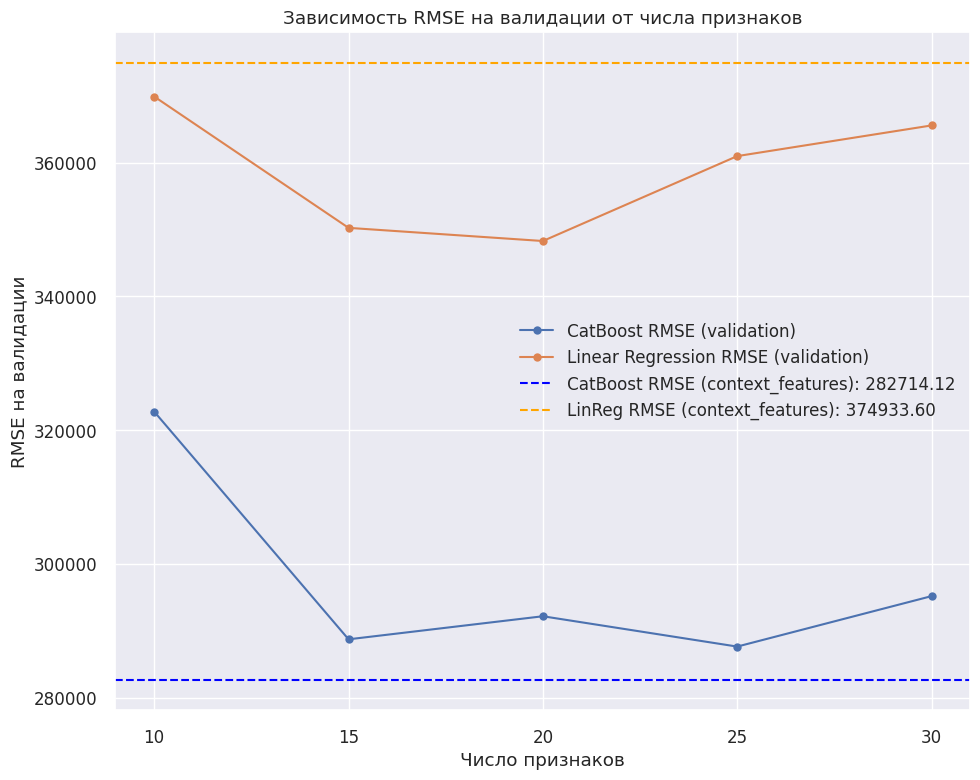

In [266]:
feature_counts = [10, 15, 20, 25, 30]
catboost_rmse_val = []
linreg_rmse_val = []

for k in feature_counts:
    catboost_rmse_val.append(df_res.loc[f'Catboost_top_{k}_features', 'rmse_val'])
    linreg_rmse_val.append(df_res.loc[f'Linreg_top_{k}_features', 'rmse_val'])

plt.figure(figsize=(10, 8))
plt.plot(feature_counts, catboost_rmse_val, marker='o', label='CatBoost RMSE (validation)')
plt.plot(feature_counts, linreg_rmse_val, marker='o', label='Linear Regression RMSE (validation)')

# Добавление горизонтальных отсечек для context_features
catboost_context_rmse = df_res.loc['Catboost_context_features', 'rmse_val']
linreg_context_rmse = df_res.loc['Linreg_context_features', 'rmse_val']

plt.axhline(y=catboost_context_rmse, color='blue', linestyle='--', label=f'CatBoost RMSE (context_features): {catboost_context_rmse:.2f}')
plt.axhline(y=linreg_context_rmse, color='orange', linestyle='--', label=f'LinReg RMSE (context_features): {linreg_context_rmse:.2f}')

plt.title('Зависимость RMSE на валидации от числа признаков')
plt.xlabel('Число признаков')
plt.ylabel('RMSE на валидации')
plt.xticks(feature_counts)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#ЭТАП 3. Интерпретация и диагностика моделей

Задачи этапа — интерпретировать модели, диагностировать сдвиги, подготовить презентацию по итогам всего проекта.


Цель — понять, какие признаки влияют на решения модели, где возникают смещения и можно ли улучшить качество. При этом здесь важнее корректно провести эксперименты и сделать осмысленные выводы, чем добиться прироста качества.


## Интерпретация моделей
### **Шаг 1. Проинтерпретируйте модели**

1. Постройте глобальные интерпретации минимум для двух разных классов моделей с помощью LIME и SHAP. Например, для линейной и ансамблевой модели. Если необходимо — заполните пропуски в данных, чтобы все методы корректно отработали.
2. Сравните, совпадают ли ключевые признаки и направления влияния между моделями.
3. Постройте локальные интерпретации LIME и SHAP для одного выбранного наблюдения. Опишите, какие признаки оказались определяющими, и сравните результаты разных методов.

Ещё раз обучим линейную регрессию, но на этот раз без логарифмирования таргета, чтобы можно было корректно интерпретировать SHAP-значения.

In [217]:
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

In [218]:
categorical_features = categorical_cols

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)
    ],
    remainder='passthrough' # не меняем числовые
)

lin_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

lin_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  [])])),
                ('regressor', LinearRegression())])

In [219]:
lin_preprocessor = lin_model.named_steps['preprocessor']
lin_regressor = lin_model.named_steps['regressor']

In [220]:
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

if not isinstance(X_train_transformed, np.ndarray):
  X_train_transformed_dense = X_train_transformed.toarray()
else:
  X_train_transformed_dense = X_train_transformed.copy()

In [221]:
explainer_lin = shap.LinearExplainer(
    lin_regressor,
    X_train_transformed_dense,
    feature_perturbation="interventional"
)

shap_vals_lin = explainer_lin.shap_values(X_train_transformed_dense)

feature_names = lin_preprocessor.get_feature_names_out()
feature_names = [name.replace('remainder__', '') for name in feature_names]

X_train_transformed_df = pd.DataFrame(
    X_train_transformed_dense,
    columns=feature_names
)

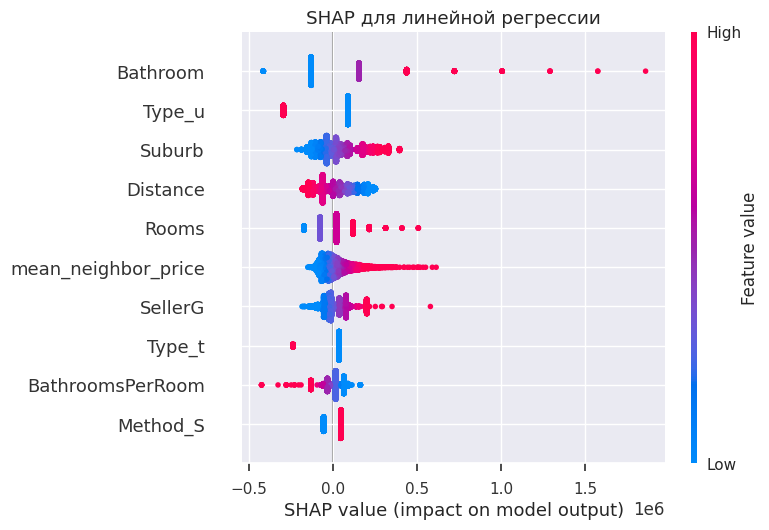

In [222]:
plt.figure(figsize=(14, 8))
shap.summary_plot(shap_vals_lin, X_train_transformed_df, show=False, max_display=10)
plt.title("SHAP для линейной регрессии")
plt.tight_layout()
plt.show()

In [223]:
print(f"Базовое значение (средняя предсказанная цена): {explainer_lin.expected_value:.4f}")

Базовое значение (средняя предсказанная цена): 981663.8128


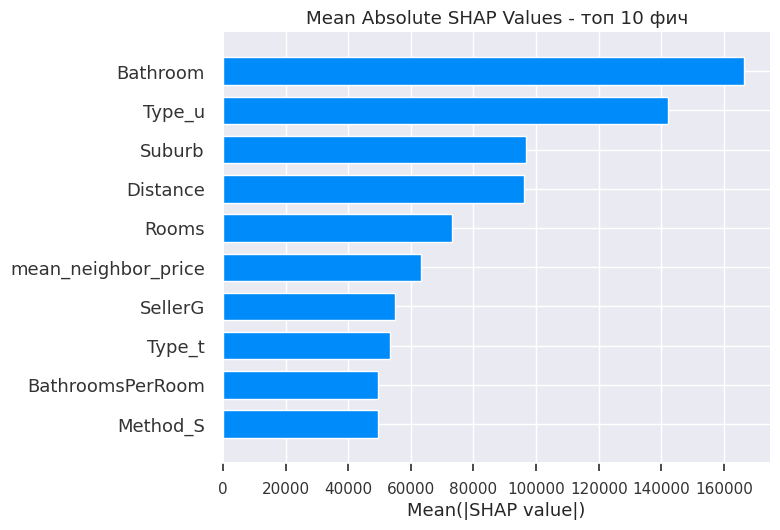

In [224]:
plt.figure(figsize=(14, 8))
shap.summary_plot(shap_vals_lin, X_train_transformed_df, plot_type="bar", show=False, max_display=10)
plt.title("Mean Absolute SHAP Values - топ 10 фич")
plt.xlabel("Mean(|SHAP value|)")
plt.tight_layout()
plt.show()

SHAP-анализ линейной регрессии показывает прямолинейное и устойчивое влияние признаков на предсказание.

Направление влияния соответствует знаку коэффициентов модели:

- положительные SHAP -> увеличение целевой переменной,

 - отрицательные SHAP -> снижение.


Выводы:

- Модель ведёт себя прозрачно и интерпретируемо, однако не учитывает нелинейные эффекты и не может моделировать сложные взаимодействия.


In [225]:
X_train_processed = X_train.copy()
X_val_processed = X_val.copy()

baseline_model = CatBoostRegressor(random_state=42)
baseline_model.fit(
    X_train_processed,
    y_train,
    eval_set=(X_val_processed, y_val),
    cat_features=categorical_cols,
    verbose=100
)

preds_train = baseline_model.predict(X_train_processed)
preds_val = baseline_model.predict(X_val_processed)

rmse_train = root_mean_squared_error(y_train, preds_train)
rmse_val = root_mean_squared_error(y_val, preds_val)

Learning rate set to 0.071504
0:	learn: 626401.0135971	test: 579557.4253761	best: 579557.4253761 (0)	total: 5.88ms	remaining: 5.87s
100:	learn: 253320.2111773	test: 340603.2262207	best: 340603.2262207 (100)	total: 492ms	remaining: 4.38s
200:	learn: 219918.4166659	test: 322758.0218428	best: 322758.0218428 (200)	total: 955ms	remaining: 3.8s
300:	learn: 199077.2399290	test: 314394.4637667	best: 314276.1234980 (299)	total: 1.44s	remaining: 3.35s
400:	learn: 184874.5409210	test: 309505.1487682	best: 309070.1146708 (392)	total: 1.92s	remaining: 2.86s
500:	learn: 173783.0625517	test: 303224.9879435	best: 303199.6478764 (499)	total: 2.41s	remaining: 2.4s
600:	learn: 164446.6696575	test: 300408.0607822	best: 300408.0607822 (600)	total: 2.88s	remaining: 1.92s
700:	learn: 156335.5686200	test: 301094.3027631	best: 300112.4201720 (606)	total: 3.36s	remaining: 1.43s
800:	learn: 148369.7061490	test: 301247.5347806	best: 300112.4201720 (606)	total: 3.83s	remaining: 951ms
900:	learn: 141440.8107318	tes

In [226]:
explainer_cat = shap.TreeExplainer(baseline_model)

shap_values_cat = explainer_cat.shap_values(X_train_processed)

print(f"Размер SHAP: {np.array(shap_values_cat).shape}")
print(f"Базовое значение (средняя предсказанная цена): {explainer_cat.expected_value:.4f}")

Размер SHAP: (8691, 37)
Базовое значение (средняя предсказанная цена): 1086641.0943


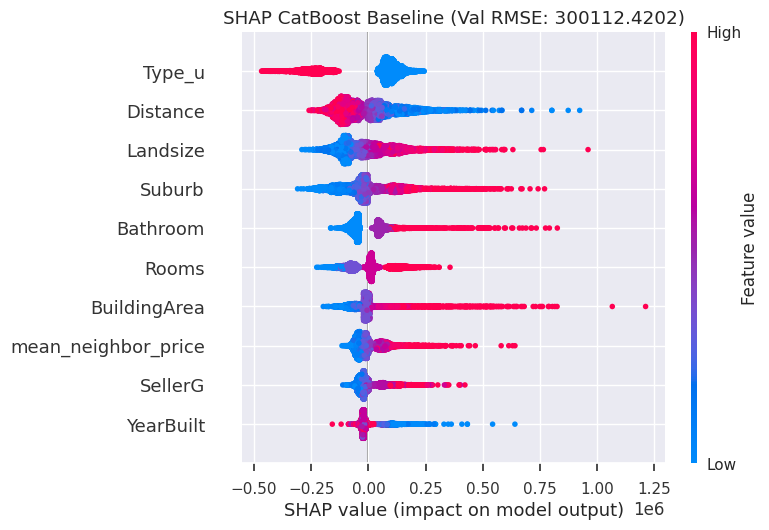

In [227]:
plt.figure(figsize=(14, 8))
shap.summary_plot(shap_values_cat, X_train_processed, show=False, max_display=10)
plt.title(f"SHAP CatBoost Baseline (Val RMSE: {rmse_val:.4f})")
plt.tight_layout()
plt.show()

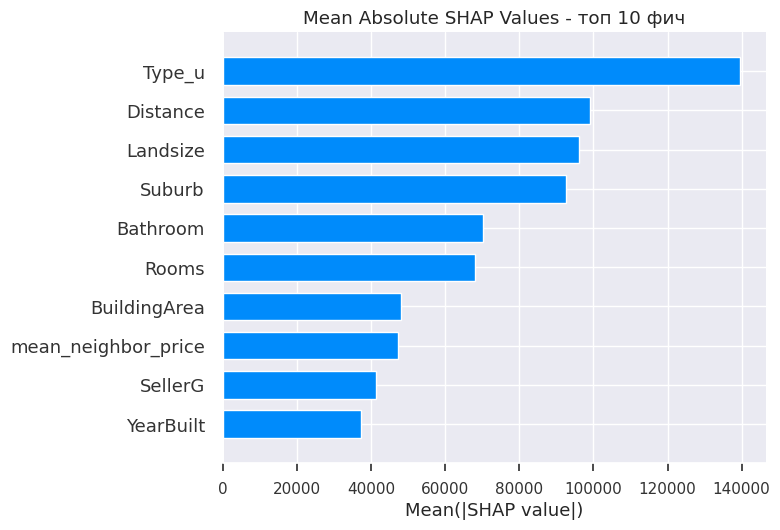

In [228]:
plt.figure(figsize=(14, 8))
shap.summary_plot(shap_values_cat, X_train_processed, plot_type="bar", show=False, max_display=10)
plt.title("Mean Absolute SHAP Values - топ 10 фич")
plt.xlabel("Mean(|SHAP value|)")
plt.tight_layout()
plt.show()

Модель использует

категориальные признаки, нелинейные зависимости, взаимодействия между признаками.

Выводы:

 - Катбуст лучше описывает реальные данные, в то же время сложнее интерпретируется без SHAP;

 - Модель демонстрирует более высокое качество.


In [229]:
def simple_lime_for_catboost(model, X_processed, y_true, categorical_cols, sample_indices=None, num_features=10):
    X_for_lime = X_processed.copy()

    for col in categorical_cols:
        if col in X_for_lime.columns:
            le = LabelEncoder()
            X_for_lime[col] = le.fit_transform(X_for_lime[col].fillna('missing').astype(str))

    X_array = X_for_lime.values
    feature_names = X_for_lime.columns.tolist()

    explainer = LimeTabularExplainer(
        training_data=X_array,
        feature_names=feature_names,
        categorical_features=[i for i, col in enumerate(feature_names) if col in categorical_cols],
        mode="regression",
        discretize_continuous=True,
        random_state=42
    )
    def predict_wrapper(data_array):
        if len(data_array.shape) == 1:
            data_array = data_array.reshape(1, -1)

        df = pd.DataFrame(data_array, columns=feature_names)

        for col in categorical_cols:
            if col in df.columns:
                df[col] = df[col].apply(lambda x: str(int(round(x))) if not pd.isna(x) else 'missing')

        return model.predict(df).reshape(-1, 1)

    if sample_indices is None:
        sample_indices = [0, 10, 50, 100]

    results = []
    for idx in sample_indices:
        if idx < len(X_array):
            exp = explainer.explain_instance(
                X_array[idx],
                predict_wrapper,
                num_features=num_features
            )

            results.append({
                'index': idx,
                'explanation': exp,
                'actual': y_true.iloc[idx] if hasattr(y_true, 'iloc') else y_true[idx],
                'predicted': model.predict(X_processed.iloc[idx:idx+1])[0]
            })

            print(f"\nSample #{idx}:")
            print(f"Actual: {results[-1]['actual']:.4f}, Predicted: {results[-1]['predicted']:.4f}")
            print("Top features:")
            for feature, weight in exp.as_list():
                print(f"  {feature}: {weight:.4f}")

    return explainer, results

In [230]:
lime_explainer, lime_results_simple = simple_lime_for_catboost(
    baseline_model,
    X_train_processed,
    y_train,
    categorical_cols,
    sample_indices=[0, 10, 50],
    num_features=8
)


Sample #0:
Actual: 1480000.0000, Predicted: 1160837.3183
Top features:
  Type_u <= 0.00: 324239.8890
  Distance <= 5.80: 297823.2449
  Rooms <= 2.00: -165943.1944
  Type_t <= 0.00: 154870.6204
  Bathroom <= 1.00: -153711.6350
  136.00 < Landsize <= 342.00: -114194.1990
  115.00 < BuildingArea <= 126.00: -89825.6406
  Car <= 1.00: -82412.6098

Sample #10:
Actual: 700000.0000, Predicted: 771991.0812
Top features:
  0.00 < Type_u <= 1.00: -338808.8226
  Distance <= 5.80: 321879.7509
  Landsize <= 136.00: -204937.0525
  Rooms <= 2.00: -166817.6309
  Type_t <= 0.00: 123109.4169
  1.00 < Bathroom <= 2.00: 106986.3120
  SellerG > 1223157.81: 84334.1776
  Regionname_South-Eastern Metropolitan <= 0.00: 59732.2139

Sample #50:
Actual: 530000.0000, Predicted: 495934.9085
Top features:
  0.00 < Type_u <= 1.00: -316853.6240
  Distance > 11.20: -201144.7140
  Landsize <= 136.00: -199096.2392
  Suburb <= 855189.98: -196351.2694
  Rooms <= 2.00: -183737.2493
  Bathroom <= 1.00: -156232.5148
  Buildin

In [231]:
def quick_lime_visualization_single_sample(model, X_processed, y_true, categorical_cols,
                                          sample_idx=0, num_features=10):
    lime_explainer, lime_results = simple_lime_for_catboost(
        model, X_processed, y_true, categorical_cols,
        sample_indices=[sample_idx], num_features=num_features
    )

    if not lime_results:
        print(f"Sample index {sample_idx} is out of bounds")
        return

    result = lime_results[0]
    exp = result['explanation']

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    feature_weights = exp.as_list()
    features = [fw[0] for fw in feature_weights]
    weights = [fw[1] for fw in feature_weights]

    colors = ['#2E8B57' if w > 0 else '#DC143C' for w in weights]
    axes[0, 0].barh(features, weights, color=colors, alpha=0.8)
    axes[0, 0].axvline(x=0, color='black', linestyle='-', linewidth=1)
    axes[0, 0].set_xlabel('Feature Weight')
    axes[0, 0].set_title(f'LIME Feature Importance - Sample #{sample_idx}')
    axes[0, 0].grid(axis='x', alpha=0.3)

    predictions = ['Actual', 'Model', 'LIME Local']
    values = [result['actual'], result['predicted'], exp.local_pred[0]]
    colors_pred = ['blue', 'green', 'orange']

    bars = axes[0, 1].bar(predictions, values, color=colors_pred, alpha=0.7)
    axes[0, 1].set_ylabel('Value')
    axes[0, 1].set_title('Prediction Comparison')
    axes[0, 1].grid(axis='y', alpha=0.3)

    for bar, value in zip(bars, values):
        axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                       f'{value:.4f}', ha='center', va='bottom')

    pos_weights = [(f, w) for f, w in feature_weights if w > 0]
    neg_weights = [(f, w) for f, w in feature_weights if w < 0]

    if pos_weights:
        pos_features, pos_values = zip(*pos_weights[:5])
        axes[1, 0].bar(pos_features, pos_values, color='green', alpha=0.7)
        axes[1, 0].set_title('Топ 5 + фич')
        axes[1, 0].tick_params(axis='x', rotation=45)
        axes[1, 0].grid(axis='y', alpha=0.3)

    if neg_weights:
        neg_features, neg_values = zip(*neg_weights[:5])
        axes[1, 1].bar(neg_features, neg_values, color='red', alpha=0.7)
        axes[1, 1].set_title('Топ 5 - фич')
        axes[1, 1].tick_params(axis='x', rotation=45)
        axes[1, 1].grid(axis='y', alpha=0.3)

    plt.suptitle(f'LIME Аналитика буста - номер #{sample_idx}\n'
                f'реальная: {result["actual"]:.4f}, предикт: {result["predicted"]:.4f}, '
                f'ошибка: {abs(result["actual"] - result["predicted"]):.4f}',
                fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

    print(f"LIME Аналитика буста - номер #{sample_idx}:")
    print(f"реальная: {result['actual']:.4f}")
    print(f"предикт: {result['predicted']:.4f}")
    print(f"локальный предикт LIME: {exp.local_pred[0]:.4f}")
    print(f"ошибка предикта: {abs(result['actual'] - result['predicted']):.4f}")
    print(f"локальная LIME ошибка : {abs(result['actual'] - exp.local_pred[0]):.4f}")
    print("\nважность признака:")
    for feature, weight in feature_weights:
        print(f"  {feature}: {weight:+.4f}")

    return exp


Sample #36:
Actual: 1012500.0000, Predicted: 1001700.3826
Top features:
  Type_u <= 0.00: 323161.4563
  Distance <= 5.80: 301644.6392
  Rooms <= 2.00: -161240.6681
  Bathroom <= 1.00: -151020.9453
  Type_t <= 0.00: 149367.4373
  BuildingArea <= 115.00: -147411.2320
  136.00 < Landsize <= 342.00: -114946.4835
  YearBuilt <= 1959.50: 90061.8007
  Car <= 1.00: -82936.9701
  0.00 < Method_S <= 1.00: 79991.2738
  year <= 2016.00: -76879.5796
  3040.00 < PostcodeParted <= 3070.00: -53172.3019


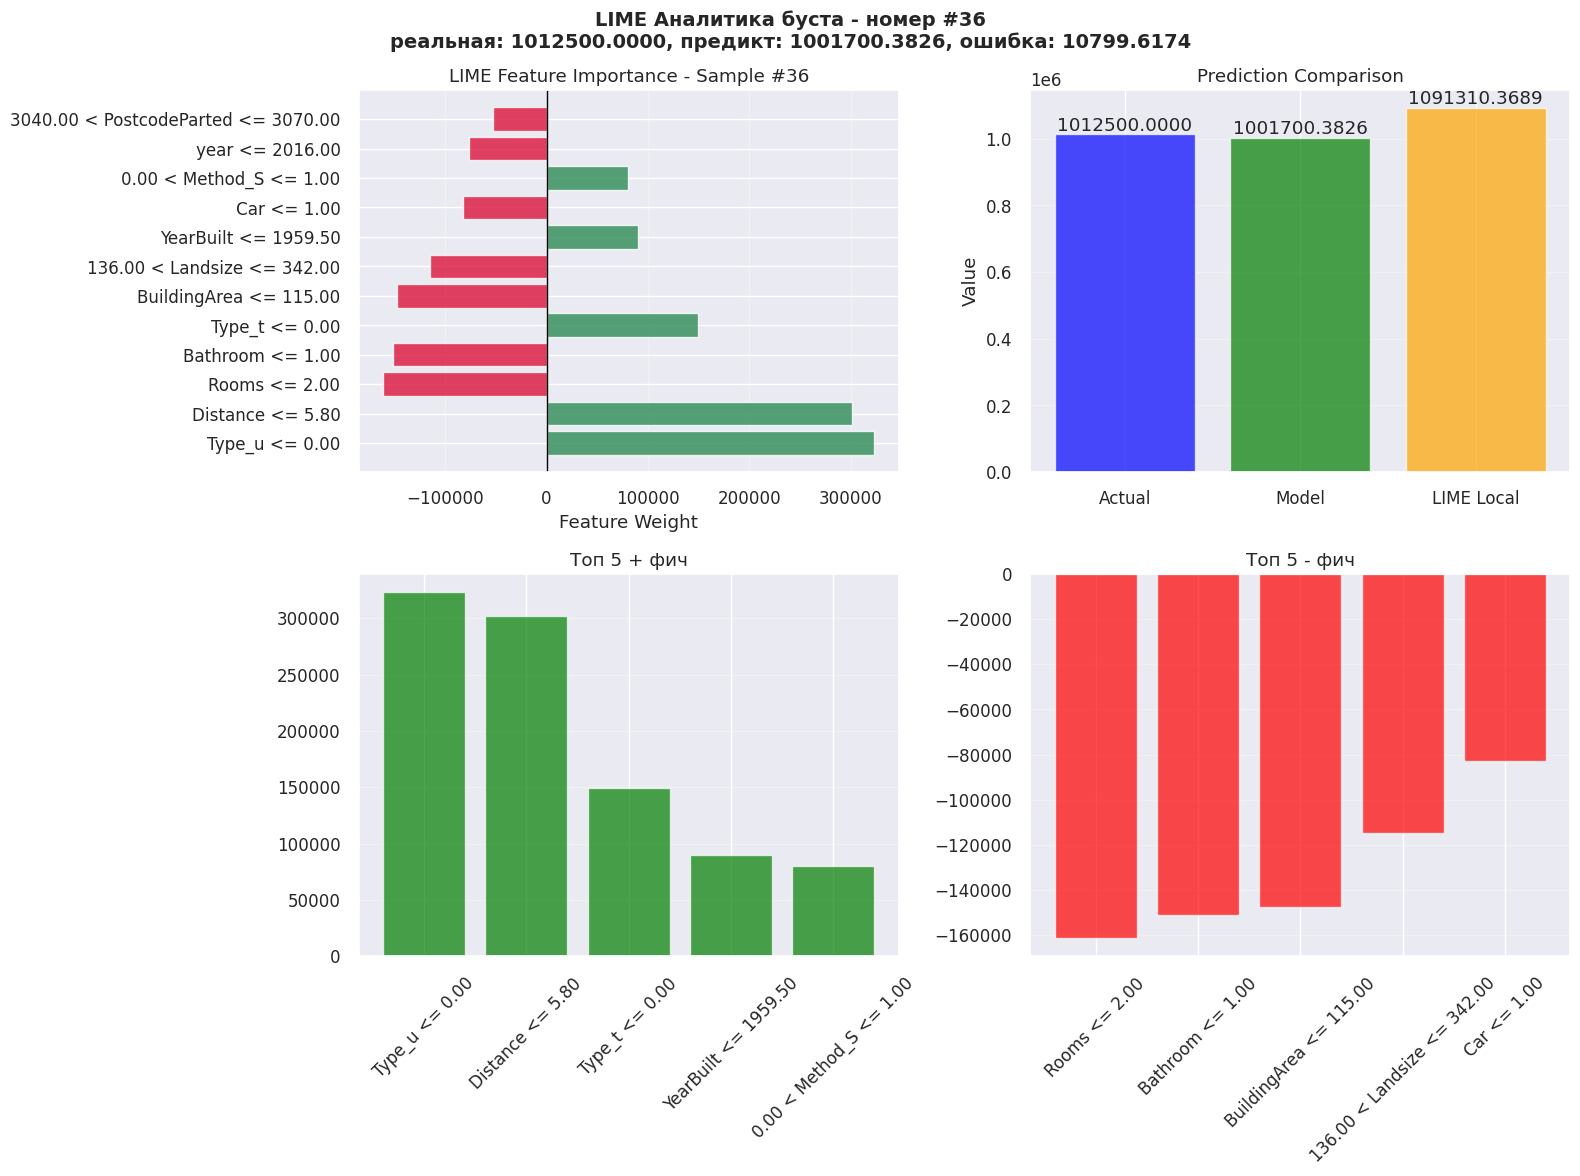

LIME Аналитика буста - номер #36:
реальная: 1012500.0000
предикт: 1001700.3826
локальный предикт LIME: 1091310.3689
ошибка предикта: 10799.6174
локальная LIME ошибка : 78810.3689

важность признака:
  Type_u <= 0.00: +323161.4563
  Distance <= 5.80: +301644.6392
  Rooms <= 2.00: -161240.6681
  Bathroom <= 1.00: -151020.9453
  Type_t <= 0.00: +149367.4373
  BuildingArea <= 115.00: -147411.2320
  136.00 < Landsize <= 342.00: -114946.4835
  YearBuilt <= 1959.50: +90061.8007
  Car <= 1.00: -82936.9701
  0.00 < Method_S <= 1.00: +79991.2738
  year <= 2016.00: -76879.5796
  3040.00 < PostcodeParted <= 3070.00: -53172.3019


In [232]:
quick_exp = quick_lime_visualization_single_sample(
    baseline_model,
    X_train_processed,
    y_train,
    categorical_cols,
    sample_idx=36,
    num_features=12
)

In [233]:
shap_values_sample = shap_values_cat[57]
base_value = explainer_cat.expected_value

print(f"Базовое значение (среднее предсказание): {base_value:.4f}")
print(f"Сумма SHAP значений: {shap_values_sample.sum():.4f}")
print(f"Объясненное предсказание: {base_value + shap_values_sample.sum():.4f}")
print(f"Фактическое предсказание модели: {baseline_model.predict(X_train_processed.iloc[57:58])[0]:.4f}")

Базовое значение (среднее предсказание): 1086641.0943
Сумма SHAP значений: -198208.4322
Объясненное предсказание: 888432.6621
Фактическое предсказание модели: 888432.6621


In [234]:
lime_explainer, lime_results_57 = simple_lime_for_catboost(
    baseline_model,
    X_train_processed,
    y_train,
    categorical_cols,
    sample_indices=[57],
    num_features=15
)

lime_exp = lime_results_57[0]['explanation']
lime_weights = lime_exp.as_list()

print(f"Локальное предсказание LIME: {lime_exp.local_pred[0]:.4f}")
print(f"Фактическое предсказание модели: {baseline_model.predict(X_train_processed.iloc[57:58])[0]:.4f}")
print(f"Разница: {abs(lime_exp.local_pred[0] - baseline_model.predict(X_train_processed.iloc[57:58])[0]):.4f}")


Sample #57:
Actual: 830000.0000, Predicted: 888432.6621
Top features:
  Type_u <= 0.00: 316846.7233
  Landsize > 618.00: 277476.7972
  Distance > 11.20: -198278.7219
  Suburb <= 855189.98: -182063.9404
  Type_t <= 0.00: 149298.0647
  Bathroom <= 1.00: -147231.0999
  BuildingArea <= 115.00: -136047.5773
  Lattitude > -37.76: -99469.0965
  0.00 < Method_S <= 1.00: 90681.8918
  year <= 2016.00: -87948.3448
  SellerG <= 855295.07: -62976.5395
  Regionname_South-Eastern Metropolitan <= 0.00: -52648.7974
  Regionname_Southern Metropolitan <= 0.00: -47720.8237
  753500.00 < mean_neighbor_price <= 976600.00: -46260.0699
  1.00 < Car <= 2.00: 39900.8887
Локальное предсказание LIME: 851160.9663
Фактическое предсказание модели: 888432.6621
Разница: 37271.6958


LIME аппроксимирует модель локальной линейной функцией вокруг выбранного объекта.

Для конкретного наблюдения определены признаки, которые увеличивают предсказание и которые уменьшают предсказание.

Локальное предсказание LIME близко к реальному предсказанию модели, но не совпадает идеально.

Разница может возникнуть потому, что LIME использует случайные пертурбации, не учитывает всю глобальную структуру модели.


LIME хорошо подходит для:

 - объяснения отдельных решений;

 - коммуникации с бизнесом.


## **SHAP-эмбеддинги и анализ сдвигов**

### Шаг 2. Постройте SHAP-эмбеддинги и проанализируйте сдвиги

1. Получите SHAP-эмбеддинги. Оформите их в виде функций, чтобы позже использовать для Shapley Flow.
2. На основе полученных SHAP-эмбеддингов:
   - выявите сдвиги и аномалии;
   - очистите данные и переобучите модель;
   - сравните метрики до и после — оцените, изменилось ли качество.
3. Проведите кластеризацию SHAP-эмбеддингов. Примените несколько методов, например: иерархическую, k-Means, DBSCAN и другие. При желании уменьшите размерность через PCA, UMAP или t-SNE.
4. Проинтерпретируйте полученные кластеры. Добавьте в датасет переменную «кластер» и переобучите модель — оцените, даёт ли это прирост.

In [235]:
categorical_cols

[]

In [236]:
for col in categorical_cols:
    X_train[col] = X_train[col].astype(str)
    X_val[col] = X_val[col].astype(str)

In [237]:
explainer = shap.TreeExplainer(baseline_model)

shap_values_train = explainer.shap_values(X_train)
shap_values_val = explainer.shap_values(X_val)

def get_shap_embeddings(X, shap_values):
    shap_embeddings = pd.DataFrame(shap_values, columns=[f"{col}_shap" for col in X.columns])
    for col in X.columns:
        shap_embeddings[f"{col}_shap_abs"] = np.abs(shap_values[:, X.columns.get_loc(col)])
    return shap_embeddings

shap_embeddings_train = get_shap_embeddings(X_train, shap_values_train)
shap_embeddings_val = get_shap_embeddings(X_val, shap_values_val)

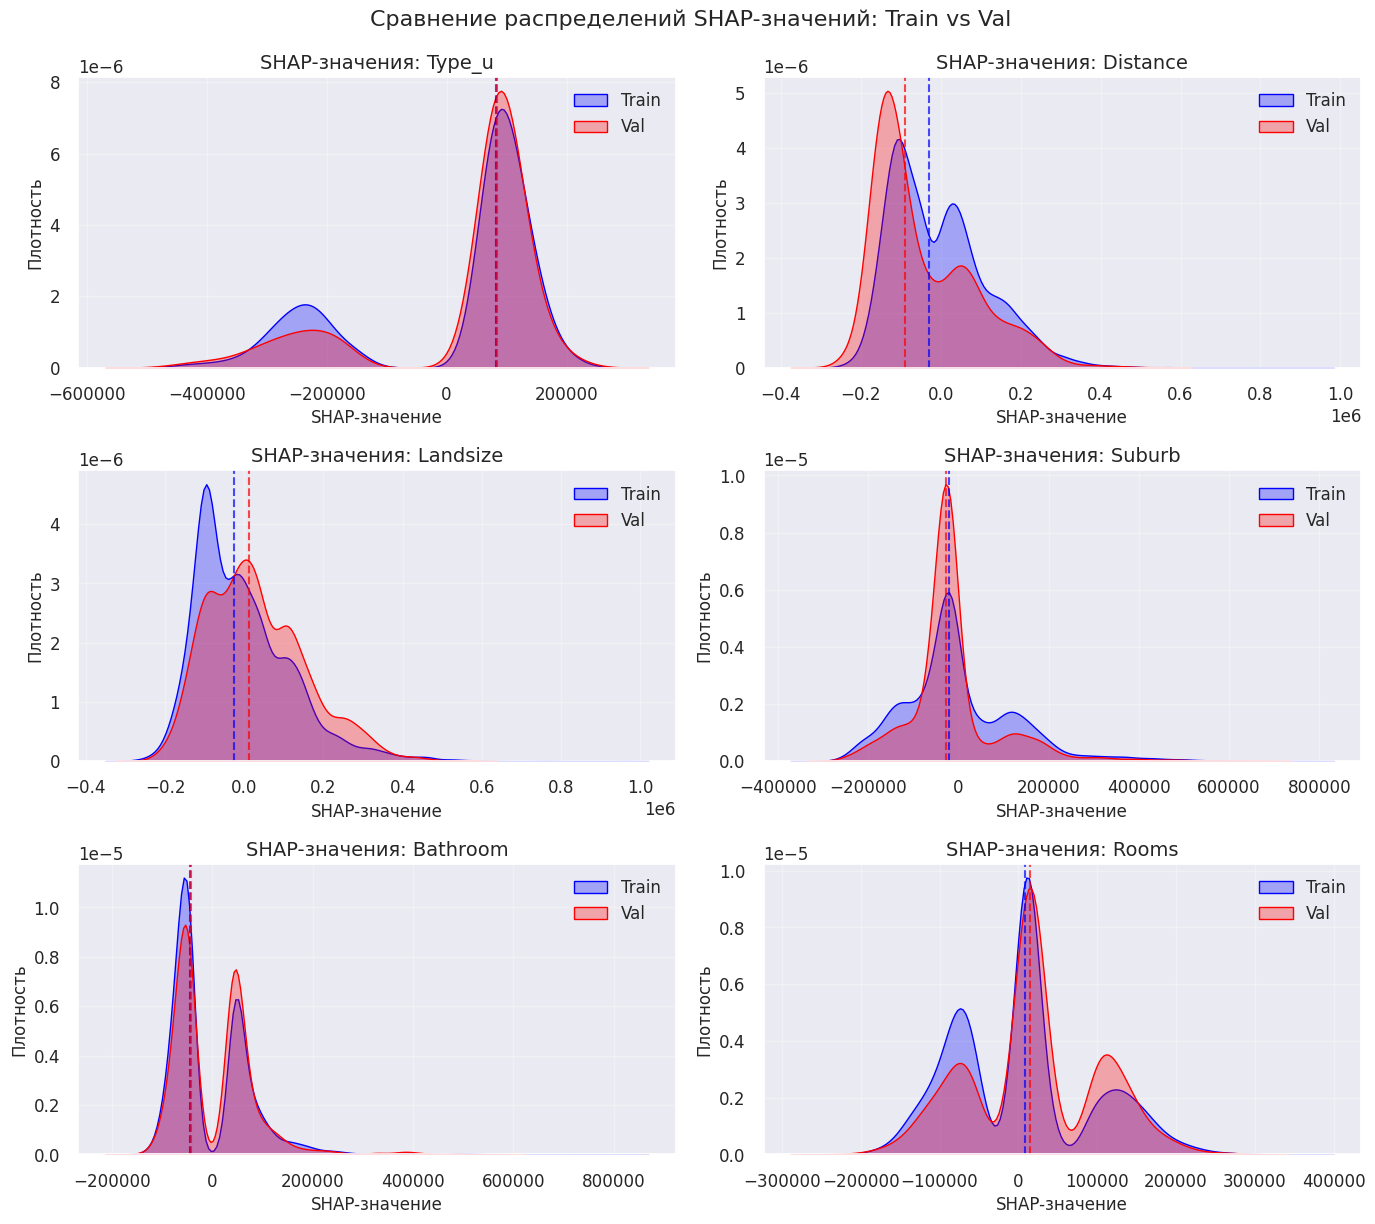

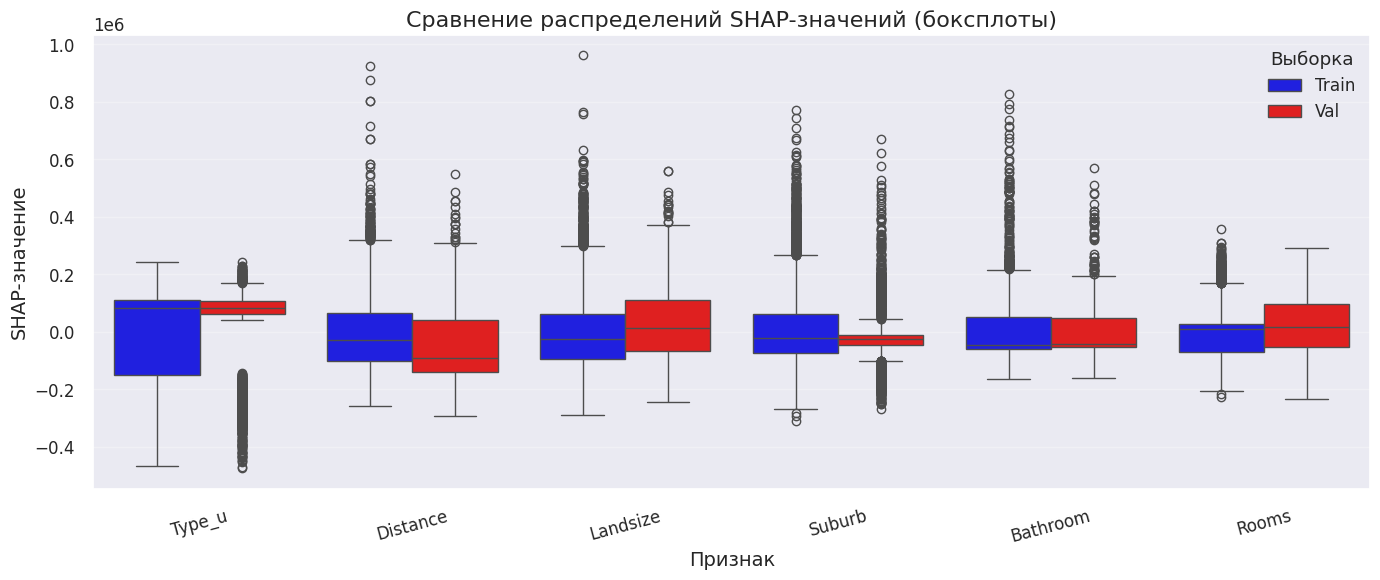

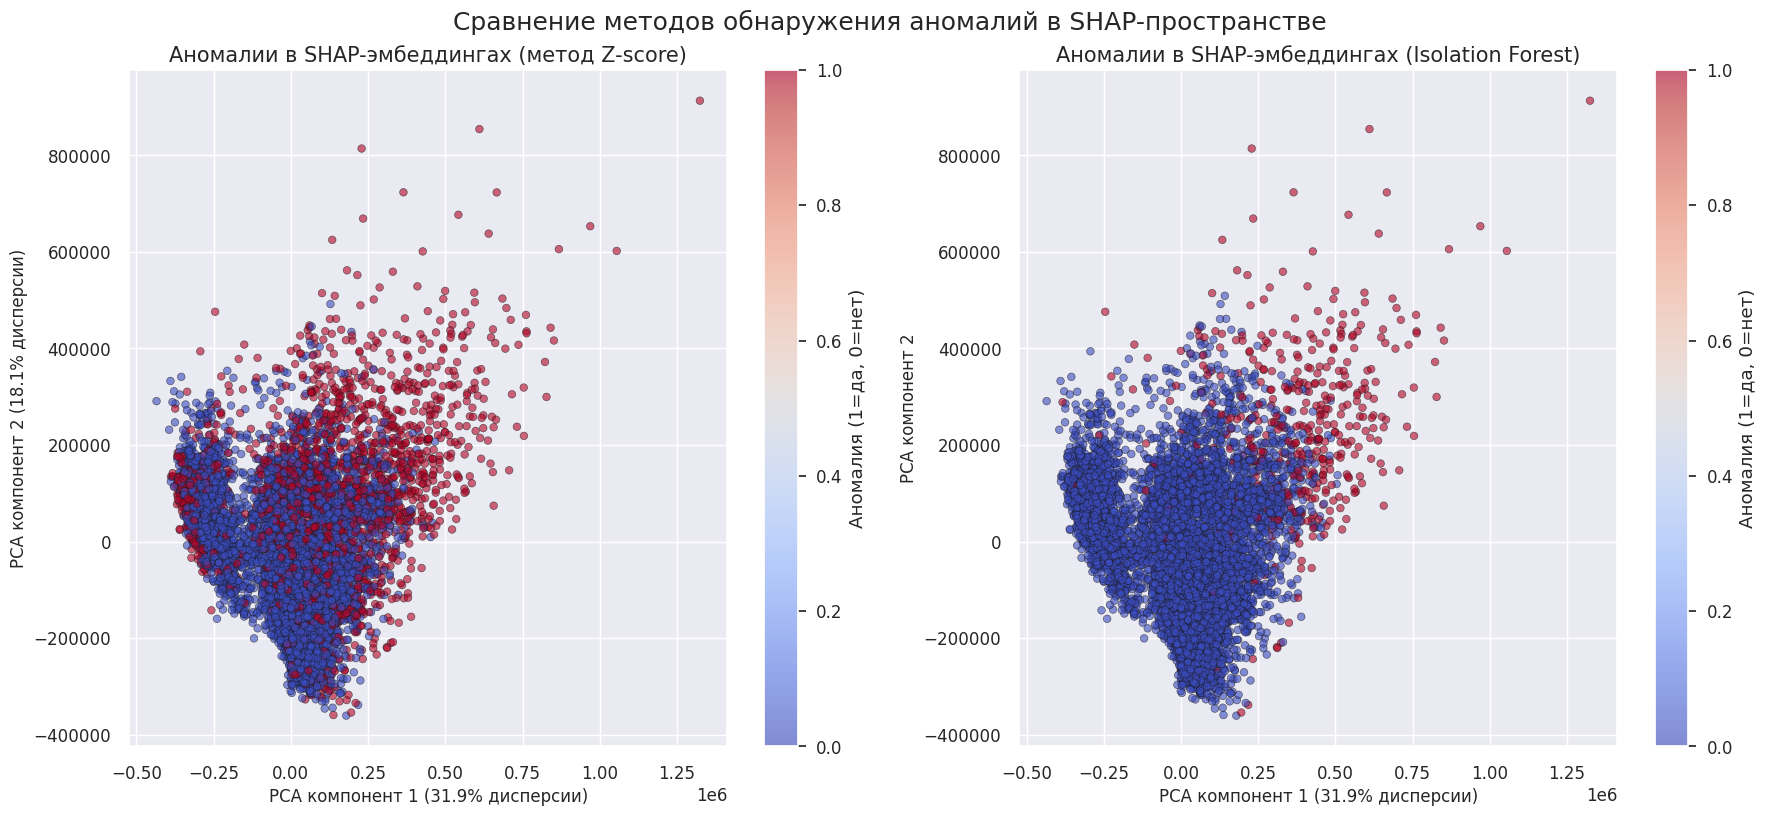

In [238]:
def detect_distribution_shifts(shap_train, shap_val, threshold=0.05):
    shifts = {}

    shap_cols = [col for col in shap_train.columns
                if col.endswith('_shap') and not col.endswith('_shap_abs')]

    for col in shap_cols:
        if col not in shap_val.columns:
            continue

        if shap_train[col].std() == 0 or shap_val[col].std() == 0:
            continue

        ks_stat, p_value = stats.ks_2samp(shap_train[col], shap_val[col])

        if p_value < threshold:
            shifts[col] = {
                'ks_stat': ks_stat,
                'p_value': p_value,
                'mean_train': shap_train[col].mean(),
                'mean_val': shap_val[col].mean(),
                'shift_direction': (
                    'increase'
                    if shap_val[col].mean() > shap_train[col].mean()
                    else 'decrease'
                ),
                'median_train': shap_train[col].median(),
                'median_val': shap_val[col].median()
            }

    return shifts


def detect_anomalies(shap_embeddings, method='zscore', threshold=3):
    anomalies_mask = np.zeros(len(shap_embeddings), dtype=bool)
    shap_cols = [col for col in shap_embeddings.columns
                if col.endswith('_shap') and not col.endswith('_shap_abs')]
    shap_data = shap_embeddings[shap_cols].copy()

    if method == 'zscore':
        scaler = StandardScaler()
        shap_scaled = scaler.fit_transform(shap_data)
        z_scores = np.abs(shap_scaled)
        anomalies_mask = (z_scores > threshold).any(axis=1)

    elif method == 'iqr':
        for col in shap_cols:
            Q1 = shap_data[col].quantile(0.25)
            Q3 = shap_data[col].quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            column_anomalies = (
                (shap_data[col] < lower_bound) |
                (shap_data[col] > upper_bound)
            )
            anomalies_mask |= column_anomalies.values

    elif method == 'isolation_forest':
        model = IsolationForest(contamination=0.05, random_state=42, n_jobs=-1)
        preds = model.fit_predict(shap_data)
        anomalies_mask = (preds == -1)

    else:
        raise ValueError("Поддерживаемые методы: 'zscore', 'iqr', 'isolation_forest'")

    return anomalies_mask



def get_top_shap_features(shap_embeddings, top_n=6):
    shap_cols = [col for col in shap_embeddings.columns
                if col.endswith('_shap') and not col.endswith('_shap_abs')]

    mean_abs_shap = (
        shap_embeddings[shap_cols]
        .abs()
        .mean()
        .sort_values(ascending=False)
    )
    top_cols = mean_abs_shap.head(top_n).index.tolist()
    return [col.replace('_shap', '') for col in top_cols]


def plot_top_shap_distributions(shap_train, shap_val, features):
    shap_cols = [f"{feature}_shap" for feature in features]

    valid_features = []
    for col in shap_cols:
        if col in shap_train.columns and col in shap_val.columns:
            if shap_train[col].std() > 0 or shap_val[col].std() > 0:
                valid_features.append(col)

    if len(valid_features) == 0:
        return

    n_plots = len(valid_features)
    n_cols = 2
    n_rows = int(np.ceil(n_plots / n_cols))

    plt.figure(figsize=(7 * n_cols, 4 * n_rows))

    for i, col in enumerate(valid_features, 1):
        plt.subplot(n_rows, n_cols, i)

        sns.kdeplot(
            shap_train[col] + np.random.normal(0, 0.001, size=len(shap_train)),
            label='Train',
            fill=True,
            alpha=0.3,
            color='blue'
        )
        sns.kdeplot(
            shap_val[col] + np.random.normal(0, 0.001, size=len(shap_val)),
            label='Val',
            fill=True,
            alpha=0.3,
            color='red'
        )

        plt.axvline(shap_train[col].median(), color='blue', linestyle='--', alpha=0.7)
        plt.axvline(shap_val[col].median(), color='red', linestyle='--', alpha=0.7)

        plt.title(f'SHAP-значения: {col.replace("_shap", "")}', fontsize=14)
        plt.xlabel('SHAP-значение', fontsize=12)
        plt.ylabel('Плотность', fontsize=12)
        plt.legend(fontsize=12)
        plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.suptitle('Сравнение распределений SHAP-значений: Train vs Val', fontsize=16, y=1.02)
    plt.show()

    plt.figure(figsize=(14, 6))

    plot_data = []
    for col in valid_features[:min(6, len(valid_features))]:
        feature_name = col.replace('_shap', '')
        for val in shap_train[col].values:
            plot_data.append({'feature': feature_name, 'value': val, 'dataset': 'Train'})
        for val in shap_val[col].values:
            plot_data.append({'feature': feature_name, 'value': val, 'dataset': 'Val'})

    plot_df = pd.DataFrame(plot_data)

    if not plot_df.empty:
        sns.boxplot(x='feature', y='value', hue='dataset', data=plot_df, palette=['blue', 'red'])
        plt.title('Сравнение распределений SHAP-значений (боксплоты)', fontsize=16)
        plt.xlabel('Признак', fontsize=14)
        plt.ylabel('SHAP-значение', fontsize=14)
        plt.xticks(rotation=15)
        plt.grid(axis='y', alpha=0.3)
        plt.legend(title='Выборка')
        plt.tight_layout()
        plt.show()

distribution_shifts = detect_distribution_shifts(
    shap_embeddings_train,
    shap_embeddings_val,
    threshold=0.05
)

anomalies_train = detect_anomalies(
    shap_embeddings_train,
    method='zscore',
    threshold=3
)

top_features = get_top_shap_features(shap_embeddings_train, top_n=6)

plot_top_shap_distributions(
    shap_embeddings_train,
    shap_embeddings_val,
    top_features
)

shap_cols = [col for col in shap_embeddings_train.columns
            if col.endswith('_shap') and not col.endswith('_shap_abs')]
shap_data = shap_embeddings_train[shap_cols].copy()

pca = PCA(n_components=2, random_state=42)
shap_pca = pca.fit_transform(shap_data)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

scatter1 = ax1.scatter(
    shap_pca[:, 0],
    shap_pca[:, 1],
    c=anomalies_train,
    cmap='coolwarm',
    alpha=0.6,
    s=30,
    edgecolors='k',
    linewidth=0.5
)
ax1.set_title('Аномалии в SHAP-эмбеддингах (метод Z-score)', fontsize=15)
ax1.set_xlabel(f'PCA компонент 1 ({pca.explained_variance_ratio_[0]:.1%} дисперсии)', fontsize=12)
ax1.set_ylabel(f'PCA компонент 2 ({pca.explained_variance_ratio_[1]:.1%} дисперсии)', fontsize=12)
fig.colorbar(scatter1, ax=ax1, label='Аномалия (1=да, 0=нет)')

anomalies_if = detect_anomalies(shap_embeddings_train, method='isolation_forest')
scatter2 = ax2.scatter(
    shap_pca[:, 0],
    shap_pca[:, 1],
    c=anomalies_if,
    cmap='coolwarm',
    alpha=0.6,
    s=30,
    edgecolors='k',
    linewidth=0.5
)
ax2.set_title('Аномалии в SHAP-эмбеддингах (Isolation Forest)', fontsize=15)
ax2.set_xlabel(f'PCA компонент 1 ({pca.explained_variance_ratio_[0]:.1%} дисперсии)', fontsize=12)
ax2.set_ylabel('PCA компонент 2', fontsize=12)
fig.colorbar(scatter2, ax=ax2, label='Аномалия (1=да, 0=нет)')

plt.tight_layout()
plt.suptitle('Сравнение методов обнаружения аномалий в SHAP-пространстве', fontsize=18, y=1.02)
plt.show()

In [239]:
clean_X_train = X_train[~anomalies_train].copy()
clean_y_train = y_train[~anomalies_train].copy()

regressor = baseline_model
clean_regressor = CatBoostRegressor(random_state=42)
clean_regressor.fit(clean_X_train, clean_y_train, verbose=100)

res_intermidate_metrics["Catboost_no_log_target"] = predict_and_count_metrics(regressor, X_train, y_train, X_val, y_val, trained_on_log=False)
res_intermidate_metrics["Catboost_no_log_target_on_clean_data"] = predict_and_count_metrics(clean_regressor, clean_X_train, clean_y_train, X_val, y_val, trained_on_log=False)

regressor.save_model("models/catboost_no_log_target.cbm")
clean_regressor.save_model("models/catboost_no_log_target_on_clean_data.cbm")

df_res = pd.DataFrame.from_dict(res_intermidate_metrics, orient='index',
                                columns=ALL_METRICS)
df_res

Learning rate set to 0.054883
0:	learn: 424954.3734488	total: 10.5ms	remaining: 10.5s
100:	learn: 177945.4187114	total: 530ms	remaining: 4.71s
200:	learn: 161111.8022834	total: 928ms	remaining: 3.69s
300:	learn: 149513.6129372	total: 1.38s	remaining: 3.21s
400:	learn: 140264.3017263	total: 1.78s	remaining: 2.67s
500:	learn: 132404.5050230	total: 2.23s	remaining: 2.22s
600:	learn: 125689.3931294	total: 2.66s	remaining: 1.76s
700:	learn: 120467.7120218	total: 3.06s	remaining: 1.3s
800:	learn: 115312.3059686	total: 3.49s	remaining: 868ms
900:	learn: 110656.6405842	total: 3.9s	remaining: 428ms
999:	learn: 106355.7243780	total: 4.35s	remaining: 0us


rmse_train       rmse_val
Catboost_baseline                     203991.248249  269203.054416
Linreg_baseline                       253387.388905  379754.136154
Catboost_manual_fix_outliers          212824.648236  272432.119800
Linreg_manual_fix_outliers            246462.305144  373722.030303
Catboost_outliers_flags               207734.879360  271619.956505
Linreg_outliers_flags                 257496.720964  373138.399268
Catboost_date_feature_encoding        196189.111491  258913.067210
Linreg_date_feature_encoding          259535.346993  368703.648107
Catboost_cat_features_encoding        167803.184637  303859.863377
Linreg_cat_features_encoding          343995.530098  352151.699100
Catboost_neighbor_features            157030.189746  279689.623268
Linreg_neighbor_features              339465.621881  370690.026131
Catboost_context_features             152277.648230  282714.119124
Linreg_context_features               339467.272548  374933.596882
Catboost_top_10_features              200462.481181  322770.908576
Linreg_top_10_features                379442.673735  369881.828484
Catboost_top_15_features              180442.877074  288730.647708
Linreg_top_15_features                355980.311090  350249.998272
Catboost_top_20_features              176092.506760  292178.202419
Linreg_top_20_features                347378.787358  348283.192136
Catboost_top_25_features              162308.210426  287642.626350
Linreg_top_25_features                340856.431019  360978.422976
Catboost_top_30_features              159365.588583  295185.882070
Linreg_top_30_features                340998.815075  365564.099693
Catboost_no_log_target                163764.764662  300112.420172
Catboost_no_log_target_on_clean_data  106355.724378  353868.129655

DBSCAN: найдено кластеров: 0, шума: 8691


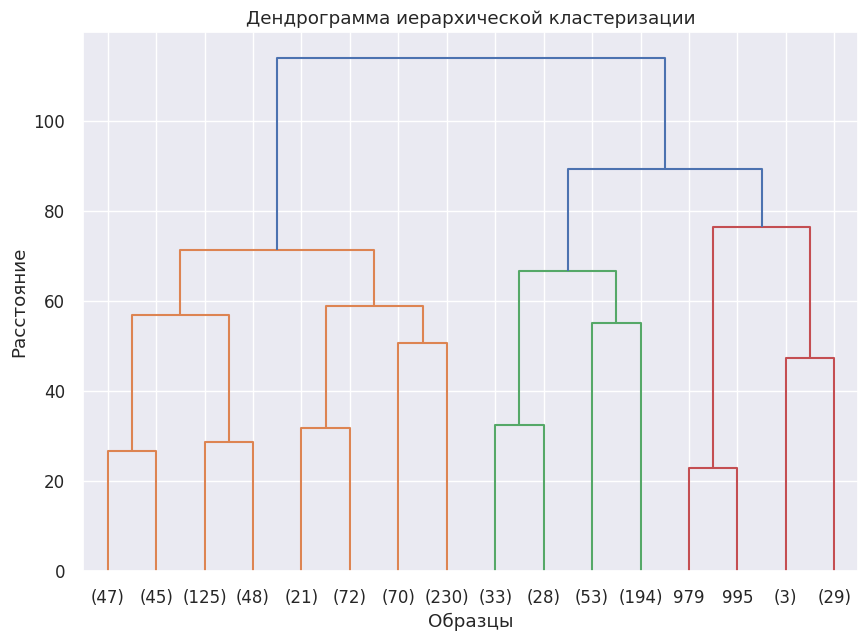

In [240]:
def reduce_dimensions(shap_embeddings, method='umap', n_components=2):
    scaler = StandardScaler()
    shap_scaled = scaler.fit_transform(shap_embeddings)

    if method == 'pca':
        reducer = PCA(n_components=n_components, random_state=42)
    elif method == 'umap':
        reducer = UMAP(n_components=n_components, random_state=42)
    elif method == 'tsne':
        reducer = TSNE(n_components=n_components, random_state=42)

    return reducer.fit_transform(shap_scaled)

reduced_embeddings = reduce_dimensions(shap_embeddings_train, method='umap', n_components=2)
def perform_clustering(shap_embeddings, methods=['kmeans', 'dbscan', 'hierarchical'],
                       n_clusters=4, eps=0.5, min_samples=5):
    results = {}
    scaler = StandardScaler()
    shap_scaled = scaler.fit_transform(shap_embeddings)

    for method in methods:
        if method == 'kmeans':
            model = KMeans(n_clusters=n_clusters, random_state=42)
            labels = model.fit_predict(shap_scaled)
            results['kmeans'] = labels
            results['kmeans_model'] = model
            results['kmeans_scaler'] = scaler

        elif method == 'dbscan':
            model = DBSCAN(eps=eps, min_samples=min_samples)
            labels = model.fit_predict(shap_scaled)
            results['dbscan'] = labels
            results['dbscan_model'] = model
            results['dbscan_scaler'] = scaler
            n_clusters_dbscan = len(set(labels)) - (1 if -1 in labels else 0)
            print(f"DBSCAN: найдено кластеров: {n_clusters_dbscan}, шума: {np.sum(labels == -1)}")

        elif method == 'hierarchical':
            model = AgglomerativeClustering(n_clusters=n_clusters)
            labels = model.fit_predict(shap_scaled)
            results['hierarchical'] = labels
            results['hierarchical_model'] = model
            results['hierarchical_scaler'] = scaler
            if 'hierarchical_dendrogram' not in results:
                linkage_matrix = linkage(shap_scaled[:1000], method='ward')
                plt.figure(figsize=(10, 7))
                dendrogram(linkage_matrix, truncate_mode='level', p=3)
                plt.title('Дендрограмма иерархической кластеризации')
                plt.xlabel('Образцы')
                plt.ylabel('Расстояние')
                plt.show()

    return results

n_clusters = 5
clustering_results = perform_clustering(shap_embeddings_train,
                                         methods=['kmeans', 'dbscan', 'hierarchical'],
                                         n_clusters=n_clusters, eps=0.3, min_samples=10)

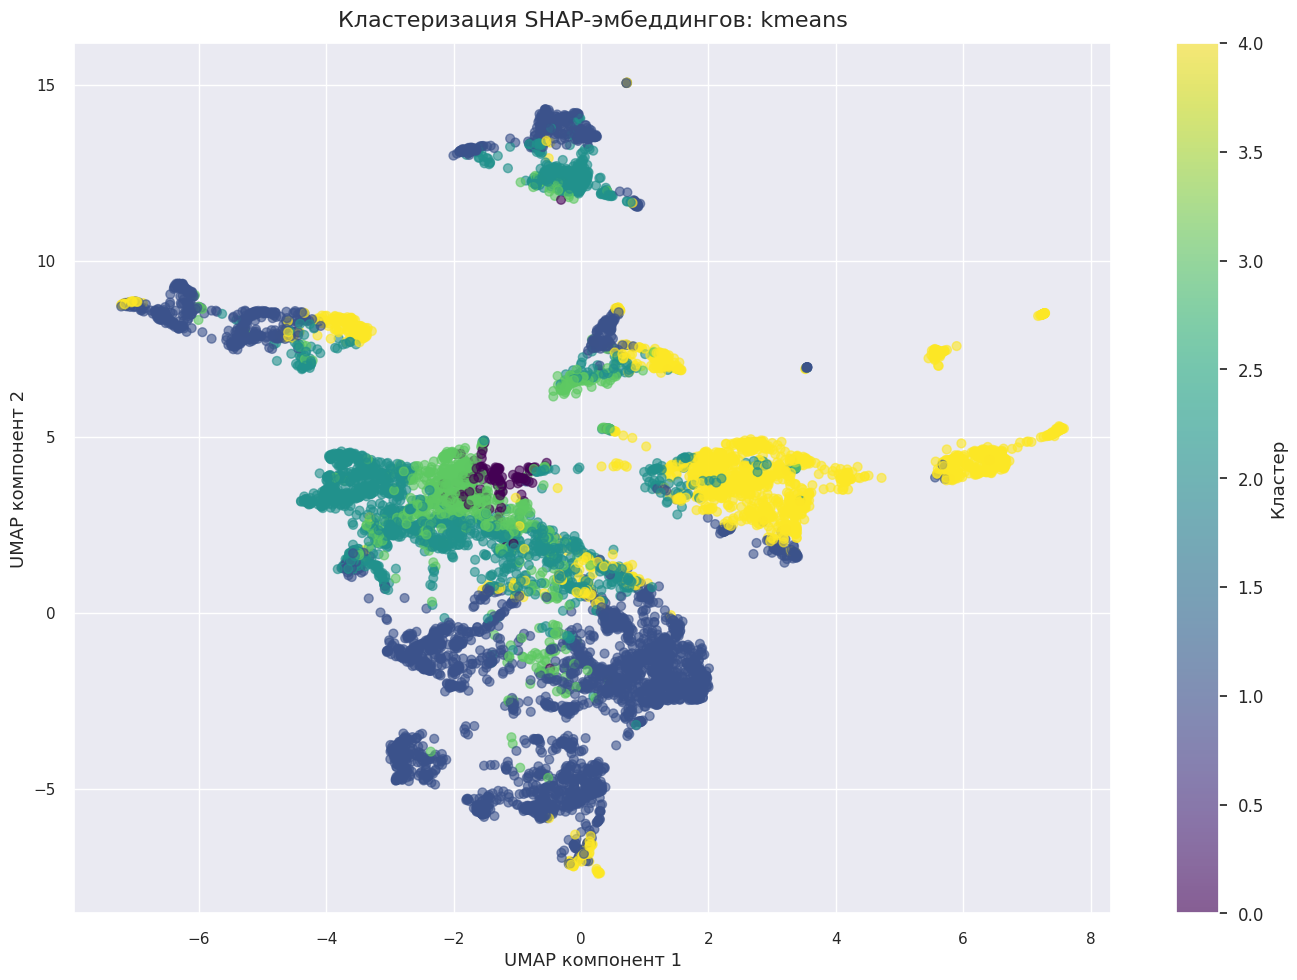

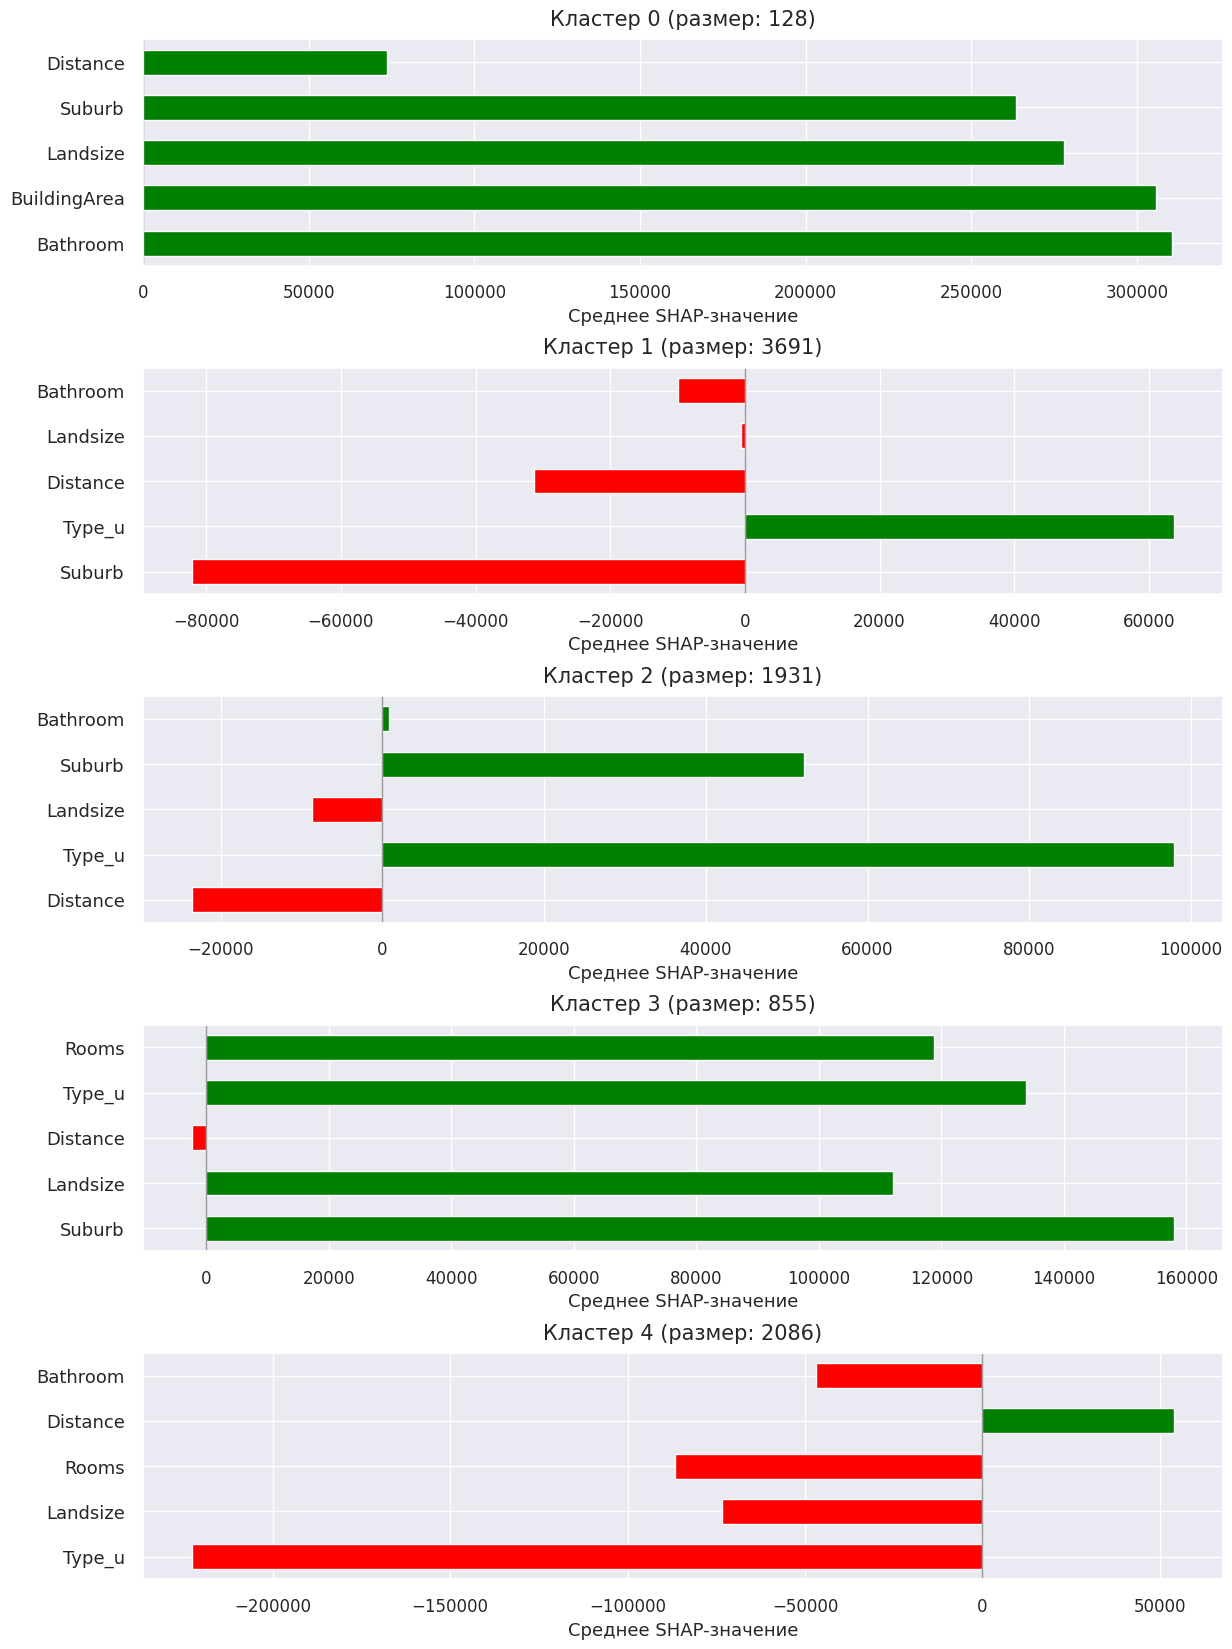

In [241]:
def visualize_clustering(reduced_embeddings, cluster_labels, method_name):
    plt.figure(figsize=(14, 10))

    scatter = plt.scatter(
        reduced_embeddings[:, 0],
        reduced_embeddings[:, 1],
        c=cluster_labels,
        cmap='viridis',
        alpha=0.6,
        s=40
    )

    plt.colorbar(scatter, label='Кластер')
    plt.title(
        f'Кластеризация SHAP-эмбеддингов: {method_name}',
        fontsize=16,
        pad=12
    )
    plt.xlabel('UMAP компонент 1', fontsize=13)
    plt.ylabel('UMAP компонент 2', fontsize=13)

    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.tight_layout()
    plt.show()


for method, labels in clustering_results.items():
    if method == 'kmeans':
        visualize_clustering(reduced_embeddings, labels, method)


def analyze_clusters(shap_embeddings,cluster_labels,n_clusters,top_features=5):
    cluster_df = shap_embeddings.copy()
    cluster_df['cluster'] = cluster_labels

    fig_height = max(4 * n_clusters, 6)

    fig, axes = plt.subplots(
        n_clusters,
        1,
        figsize=(18, fig_height),
        sharex=False
    )

    if n_clusters == 1:
        axes = [axes]

    for cluster_idx in range(n_clusters):
        ax = axes[cluster_idx]

        cluster_data = cluster_df[cluster_df['cluster'] == cluster_idx]

        if cluster_data.empty:
            ax.axis('off')
            continue

        abs_shap_cols = [
            col for col in cluster_data.columns
            if col.endswith('_shap_abs')
        ]

        avg_abs_shap = (
            cluster_data[abs_shap_cols]
            .mean()
            .sort_values(ascending=False)
            .head(top_features)
        )

        feature_names = [
            col.replace('_shap_abs', '')
            for col in avg_abs_shap.index
        ]

        shap_cols = [f"{name}_shap" for name in feature_names]
        avg_shap = cluster_data[shap_cols].mean()

        colors = [
            'green' if val > 0 else 'red'
            for val in avg_shap.values
        ]

        ax.barh(
            feature_names,
            avg_shap.values,
            color=colors,
            height=0.55
        )

        ax.axvline(0, color='black', linewidth=1, alpha=0.4)

        ax.set_title(
            f'Кластер {cluster_idx} (размер: {len(cluster_data)})',
            fontsize=15,
            pad=10
        )

        ax.set_xlabel(
            'Среднее SHAP-значение',
            fontsize=13
        )

        ax.tick_params(axis='y', labelsize=13)
        ax.tick_params(axis='x', labelsize=12)

    plt.subplots_adjust(left=0.30, hspace=0.45)
    plt.show()

n_clusters_kmeans = len(np.unique(clustering_results['kmeans']))

analyze_clusters(
    shap_embeddings=shap_embeddings_train,
    cluster_labels=clustering_results['kmeans'],
    n_clusters=n_clusters_kmeans,
    top_features=5
)


In [242]:
def add_cluster_feature(X, shap_embeddings, clustering_results, method='kmeans'):
    X_with_cluster = X.copy()

    model = clustering_results[f'{method}_model']
    scaler = clustering_results[f'{method}_scaler']

    shap_scaled = scaler.transform(shap_embeddings)

    cluster_labels = model.predict(shap_scaled)

    X_with_cluster[f'cluster_{method}'] = cluster_labels
    cluster_dummies = pd.get_dummies(
        X_with_cluster[f'cluster_{method}'],
        prefix=f'cluster_{method}'
    )
    X_with_cluster = pd.concat([X_with_cluster, cluster_dummies], axis=1)

    return X_with_cluster

X_train_with_cluster = add_cluster_feature(
    X_train,
    shap_embeddings_train,
    clustering_results,
    method='kmeans'
)

X_val_with_cluster = add_cluster_feature(
    X_val,
    shap_embeddings_val,
    clustering_results,
    method='kmeans'
)

In [243]:
cluster_regressor = CatBoostRegressor(random_state=42)
cluster_regressor.fit(X_train_with_cluster, y_train, verbose=100)

res_intermidate_metrics["Catboost_SHAP_clusters"]  = predict_and_count_metrics(cluster_regressor, X_train_with_cluster, y_train,
                                 X_val_with_cluster, y_val, trained_on_log=False)
cluster_regressor.save_model("models/catboost_shap_clusters.cbm")

cluster_df = pd.DataFrame({
    'cluster': clustering_results['kmeans'],
    'target': y_train.values
})

df_res = pd.DataFrame.from_dict(res_intermidate_metrics, orient='index',
                                columns=ALL_METRICS)
df_res

Learning rate set to 0.057617
0:	learn: 629322.6535959	total: 7.47ms	remaining: 7.47s
100:	learn: 240386.3527578	total: 497ms	remaining: 4.42s
200:	learn: 214655.9202795	total: 998ms	remaining: 3.96s
300:	learn: 196869.5630991	total: 1.47s	remaining: 3.42s
400:	learn: 183901.2104146	total: 1.97s	remaining: 2.94s
500:	learn: 173059.9799281	total: 2.45s	remaining: 2.44s
600:	learn: 164624.8147940	total: 2.94s	remaining: 1.96s
700:	learn: 157039.0690609	total: 3.42s	remaining: 1.46s
800:	learn: 150131.7485575	total: 3.95s	remaining: 982ms
900:	learn: 144130.5589083	total: 4.43s	remaining: 486ms
999:	learn: 139176.6987216	total: 4.93s	remaining: 0us


rmse_train       rmse_val
Catboost_baseline                     203991.248249  269203.054416
Linreg_baseline                       253387.388905  379754.136154
Catboost_manual_fix_outliers          212824.648236  272432.119800
Linreg_manual_fix_outliers            246462.305144  373722.030303
Catboost_outliers_flags               207734.879360  271619.956505
Linreg_outliers_flags                 257496.720964  373138.399268
Catboost_date_feature_encoding        196189.111491  258913.067210
Linreg_date_feature_encoding          259535.346993  368703.648107
Catboost_cat_features_encoding        167803.184637  303859.863377
Linreg_cat_features_encoding          343995.530098  352151.699100
Catboost_neighbor_features            157030.189746  279689.623268
Linreg_neighbor_features              339465.621881  370690.026131
Catboost_context_features             152277.648230  282714.119124
Linreg_context_features               339467.272548  374933.596882
Catboost_top_10_features              200462.481181  322770.908576
Linreg_top_10_features                379442.673735  369881.828484
Catboost_top_15_features              180442.877074  288730.647708
Linreg_top_15_features                355980.311090  350249.998272
Catboost_top_20_features              176092.506760  292178.202419
Linreg_top_20_features                347378.787358  348283.192136
Catboost_top_25_features              162308.210426  287642.626350
Linreg_top_25_features                340856.431019  360978.422976
Catboost_top_30_features              159365.588583  295185.882070
Linreg_top_30_features                340998.815075  365564.099693
Catboost_no_log_target                163764.764662  300112.420172
Catboost_no_log_target_on_clean_data  106355.724378  353868.129655
Catboost_SHAP_clusters                139176.698722  298337.063525

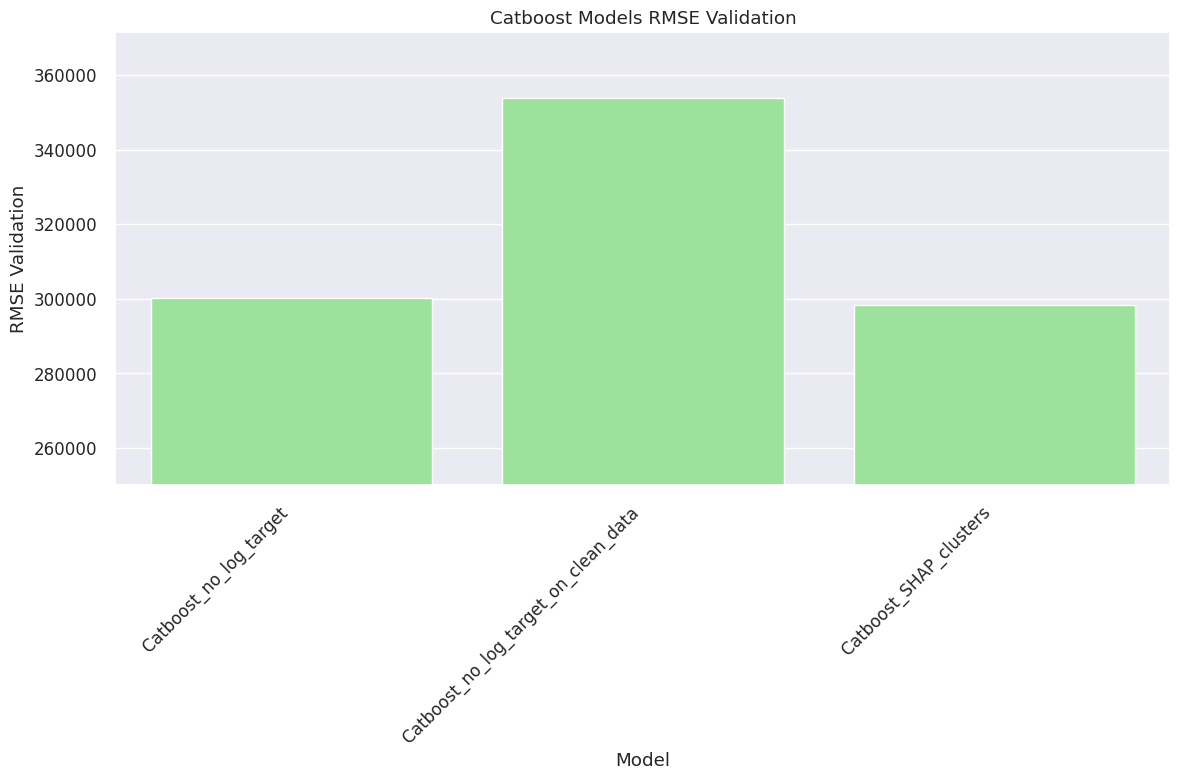

In [244]:
catboost_results = df_res[df_res.index.str.startswith('Catboost')].copy()
catboost_results_filtered = catboost_results.tail(3)

plt.figure(figsize=(12, 8))
sns.barplot(x=catboost_results_filtered.index, y='rmse_val', data=catboost_results_filtered, color="lightgreen")
plt.xticks(rotation=45, ha='right')
plt.title('Catboost Models RMSE Validation')
plt.xlabel('Model')
plt.ylabel('RMSE Validation')
plt.ylim(bottom=250000)
plt.tight_layout()
plt.show()

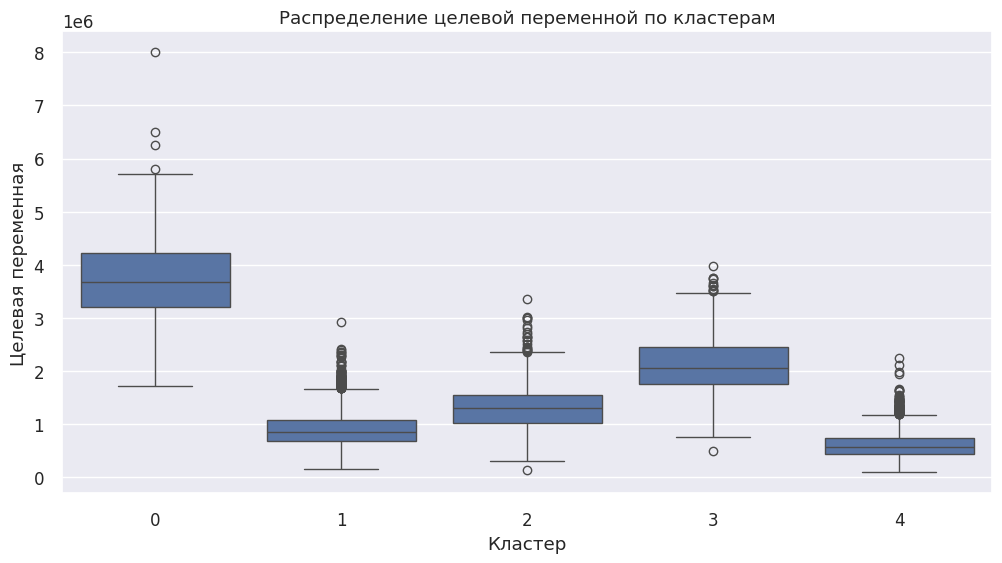

In [245]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='cluster', y='target', data=cluster_df)
plt.title('Распределение целевой переменной по кластерам')
plt.xlabel('Кластер')
plt.ylabel('Целевая переменная')
plt.show()

In [246]:
cluster_stats = cluster_df.groupby('cluster')['target'].agg(['mean', 'std', 'count']).reset_index()
print("Статистика по кластерам:")
print(cluster_stats)

Статистика по кластерам:
   cluster          mean            std  count
0        0  3.748398e+06  940979.227681    128
1        1  8.986838e+05  330785.155112   3691
2        2  1.313672e+06  391996.797304   1931
3        3  2.128271e+06  533496.295015    855
4        4  6.189669e+05  258679.338495   2086


In [247]:
for col in X_train.columns:
    try:
        X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
    except Exception as e:
        print(f"Не удалось преобразовать колонку {col}: {e}")

feature_importance = pd.DataFrame(columns=['feature', 'cluster', 'mean_value', 'std_value'])
top_original_features = [col.replace('_shap', '') for col in shap_embeddings_train.columns if '_shap' in col][:3]

for feature in top_original_features:
    for cluster_id in range(n_clusters_kmeans):
        cluster_mask = (clustering_results['kmeans'] == cluster_id)
        feature_values = X_train.loc[cluster_mask, feature]

        feature_values_numeric = pd.to_numeric(feature_values, errors='coerce')

        feature_values_clean = feature_values_numeric.dropna()

        if len(feature_values_clean) > 0:
            new_row = pd.DataFrame({
                'feature': [feature],
                'cluster': [cluster_id],
                'mean_value': [feature_values_clean.mean()],
                'std_value': [feature_values_clean.std()]
            })
            feature_importance = pd.concat([feature_importance, new_row], ignore_index=True)

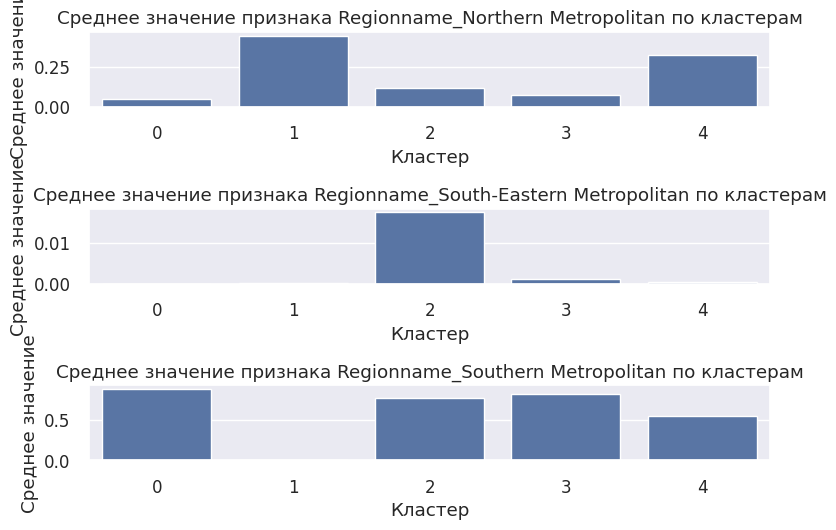

In [248]:
for i, feature in enumerate(top_original_features, 1):
    plt.subplot(len(top_original_features), 1, i)
    sns.barplot(x='cluster', y='mean_value', data=feature_importance[feature_importance['feature'] == feature])
    plt.title(f'Среднее значение признака {feature} по кластерам')
    plt.ylabel('Среднее значение')
    plt.xlabel('Кластер')
plt.tight_layout()
plt.show()

Выводы:

- Эффективное обнаружение аномалий: Методы z-score и Isolation Forest позволили нашей команде идентифицировать аномальные наблюдения в SHAP-пространстве, которые потенциально могли искажать обучение модели.

- Кластеризация SHAP-эмбеддингов позволила выявить группы наблюдений, для которых модель принимает решения на основе схожих паттернов влияния признаков.

- Корреляция кластеров с целевой переменной: Boxplot распределения целевой переменной по кластерам показал статистически значимые различия между кластерами, что подтверждает их информативность.

В дальнейшем можно использовать бизнес-сегментации, что открывает возможности для стратегий в зависимости от характеристик каждого кластера, возможно, это будет полезно для бизнеса.

## Валидация,Shapley Flow
### **Шаг 3. Проведите валидацию, примените Shapley Flow**

1. Проведите кросс-валидацию с SHAP-эмбеддингами:
   - на одной части данных — обучите модель;
   - на другой части — проведите валидацию.

   Сравните два варианта — обучение только на эмбеддингах и на их конкатенации с исходными признаками.
2. Постройте граф взаимосвязей признаков и примените Shapley Flow, повторив шаги, проделанные для SHAP:
   - проведите интерпретацию,
   - проведите кластеризацию,
   - проанализируйте сдвиги.

   Работайте с исходным (неочищенным) датасетом, чтобы корректно сравнить результаты.
3. Оцените:
   - изменился ли характер сдвига или аномалий,
   - изменилась ли структура кластеров,
   - удалось ли улучшить качество модели.


In [249]:
# Используем все данные (train + val) для кросс-валидации
X_full_train = pd.concat([X_train, X_val])
y_full_train = pd.concat([y_train, y_val])

results_shap = {}

cv_splitter = TimeSeriesSplit(n_splits=5)

for train_idx, val_idx in cv_splitter.split(X_full_train, y_full_train):
    X_train_fold, X_val_fold = X_full_train.iloc[train_idx], X_full_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_full_train.iloc[train_idx], y_full_train.iloc[val_idx]

    fold_base_model = type(baseline_model)(**baseline_model.get_params())
    fold_base_model.fit(X_train_fold, y_train_fold, verbose=0)

    explainer_fold = shap.TreeExplainer(fold_base_model)
    shap_train_fold = explainer_fold.shap_values(X_train_fold)
    shap_val_fold = explainer_fold.shap_values(X_val_fold)

    model_emb_only = CatBoostRegressor(iterations=200, random_state=42)
    model_emb_only.fit(shap_train_fold, y_train_fold, verbose=0)
    y_pred_emb = model_emb_only.predict(shap_val_fold)

    results_shap['embeddings_only_rmse'] = results_shap.get("embeddings_only_rmse", []) + [root_mean_squared_error(y_val_fold, y_pred_emb)]
    results_shap['embeddings_only_r2'] = results_shap.get("embeddings_only_r2", []) + [r2_score(y_val_fold, y_pred_emb)]

    X_train_combined = np.hstack([X_train_fold.values, shap_train_fold])
    X_val_combined = np.hstack([X_val_fold.values, shap_val_fold])

    model_combined = CatBoostRegressor(iterations=200, random_state=42)
    model_combined.fit(X_train_combined, y_train_fold, verbose=0)
    y_pred_combined = model_combined.predict(X_val_combined)

    results_shap['embeddings_and_features_rmse'] = results_shap.get("embeddings_and_features_rmse", []) + [root_mean_squared_error(y_val_fold, y_pred_combined)]
    results_shap['embeddings_and_features_r2'] = results_shap.get("embeddings_and_features_r2", []) + [r2_score(y_val_fold, y_pred_combined)]

    print(f"Fold завершен. Результаты фолда:")
    for key, value in results_shap.items():
      print(f"{key}: {value[-1]}")
    print("\n")

print("\n--- Средние результаты по кросс-валидации ---")
for key, value in results_shap.items():
    print(f"Средний {key}: {np.mean(value):.4f} (+/- {np.std(value):.4f})")

Fold завершен. Результаты фолда:
embeddings_only_rmse: 330913.87126747833
embeddings_only_r2: 0.7444165032077577
embeddings_and_features_rmse: 322384.55178069446
embeddings_and_features_r2: 0.7574220571646623


Fold завершен. Результаты фолда:
embeddings_only_rmse: 283361.2864495442
embeddings_only_r2: 0.7656690892109795
embeddings_and_features_rmse: 291644.88240393554
embeddings_and_features_r2: 0.7517682839020021


Fold завершен. Результаты фолда:
embeddings_only_rmse: 309000.2747879713
embeddings_only_r2: 0.7670177150674398
embeddings_and_features_rmse: 303444.80548395385
embeddings_and_features_r2: 0.7753199127784832


Fold завершен. Результаты фолда:
embeddings_only_rmse: 300739.35697638965
embeddings_only_r2: 0.7726187689065072
embeddings_and_features_rmse: 293842.0516607608
embeddings_and_features_r2: 0.7829289158810475


Fold завершен. Результаты фолда:
embeddings_only_rmse: 267088.79696425935
embeddings_only_r2: 0.7990769635349535
embeddings_and_features_rmse: 269875.745205069

Качество модели, обученной только на SHAP-эмбеддингах, не сильно отличается от качества модели, обученной на эмбеддингах и фичах.

In [250]:
def obj_to_numeric(df):
  df_copy = df.copy()

  object_cols = df_copy.select_dtypes(include='object').columns

  for col in object_cols:
    df_copy[col] = pd.to_numeric(df_copy[col])

  return df_copy, object_cols

X_train, categorical_feature_names = obj_to_numeric(X_train)
X_val, _ = obj_to_numeric(X_val)
X_test, _ = obj_to_numeric(X_test)

categorical_feature_names = categorical_feature_names.tolist()

In [251]:
categorical_feature_names = [feature_name for feature_name in categorical_feature_names if
                             feature_name.startswith("Regionname_") or
                             feature_name.startswith("Method_") or
                             feature_name.startswith("Type") or
                             feature_name in ["is_weekend"]]

categorical_feature_names

[]

In [252]:
xgb_train = xgboost.DMatrix(X_train, y_train)
xgb_val = xgboost.DMatrix(X_val, y_val)

params = {
    'objective':'reg:squarederror',
    'seed': 42,
}
model = xgboost.train(params=params, dtrain=xgb_train)

learning dependency for Bathroom:   0%|          | 0/3 [00:00<?, ?it/s]

[0]	test-rmse:0.70228
[100]	test-rmse:0.66297
[200]	test-rmse:0.63511
[300]	test-rmse:0.61571
[400]	test-rmse:0.60232
[499]	test-rmse:0.59307


learning dependency for Bedroom2:  33%|███▎      | 1/3 [00:01<00:02,  1.35s/it]

[0]	test-rmse:0.94297
[100]	test-rmse:0.80149
[200]	test-rmse:0.68988
[300]	test-rmse:0.60294
[400]	test-rmse:0.53614
[499]	test-rmse:0.48578


learning dependency for Distance:  67%|██████▋   | 2/3 [00:02<00:01,  1.10s/it]

[0]	test-rmse:3.65213
[100]	test-rmse:3.29667
[200]	test-rmse:2.99754
[300]	test-rmse:2.73178
[400]	test-rmse:2.49847
[499]	test-rmse:2.29327


learning dependency for Distance: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


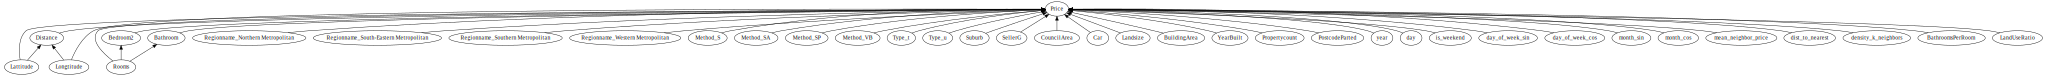

In [253]:
causal_links = CausalLinks()

feature_names = list(X_train.columns)

causal_links.add_causes_effects(feature_names,
                                target,
                                create_xgboost_f(feature_names, model)
                                )

causes = ['Rooms']
effects = ['Bedroom2', 'Bathroom']
causal_links.add_causes_effects(causes, effects)

causes = ['Lattitude', 'Longtitude']
effects = ['Distance']
causal_links.add_causes_effects(causes, effects)

graph = build_feature_graph(X=X_train,
                            causal_links=causal_links,
                            categorical_feature_names=categorical_feature_names,
                            target_name=target
                            )
graph.draw()

learning dependency for Bedroom2:   0%|          | 0/3 [00:00<?, ?it/s]

[0]	test-rmse:0.94297
[100]	test-rmse:0.80149
[200]	test-rmse:0.68988
[300]	test-rmse:0.60294
[400]	test-rmse:0.53614
[499]	test-rmse:0.48578


learning dependency for Distance:  33%|███▎      | 1/3 [00:00<00:01,  1.55it/s]

[0]	test-rmse:3.65213
[100]	test-rmse:3.29667
[200]	test-rmse:2.99754
[300]	test-rmse:2.73178
[400]	test-rmse:2.49847
[499]	test-rmse:2.29327


learning dependency for Bathroom:  67%|██████▋   | 2/3 [00:01<00:00,  1.41it/s]

[0]	test-rmse:0.70228
[100]	test-rmse:0.66297
[200]	test-rmse:0.63511
[300]	test-rmse:0.61571
[400]	test-rmse:0.60232
[499]	test-rmse:0.59307


learning dependency for Bathroom: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


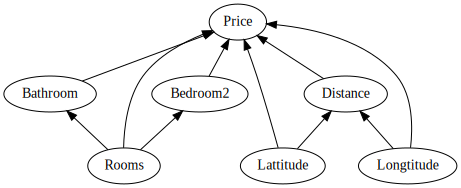

In [254]:
casual_links_visual = CausalLinks()

features_to_visual = ['Rooms'] + ['Bedroom2', 'Bathroom'] + ['Lattitude', 'Longtitude'] + ['Distance']
categorical_feature_names_to_visual = []

casual_links_visual.add_causes_effects(features_to_visual,
                                target,
                                create_xgboost_f(features_to_visual, model)
                                )

causees = ['Rooms']
effects = ['Bedroom2', 'Bathroom']
casual_links_visual.add_causes_effects(causees, effects)

causees = ['Lattitude', 'Longtitude']
effects = ['Distance']
casual_links_visual.add_causes_effects(causees, effects)

graph_to_visual = build_feature_graph(X=X_train[features_to_visual],
                            causal_links=casual_links_visual,
                            categorical_feature_names=categorical_feature_names_to_visual,
                            target_name=target
                            )
graph_to_visual.draw()

In [255]:
# Рассчитаем shap значения.
# В качестве bg выборки используем медиану по X_train,
# т.к. использование большого числа наблюдений сильно замедляет цикл
# Но потенциально этот пайплайн можно использовать для большей bg выборки

bg_sample = X_train.median().to_frame().T
fg_samples = X_val

nruns = 100
all_node_credits_dfs = []

print(f"Начинаем расчет Shapley Flow для {len(fg_samples)} объектов...")
print(f"Используем {len(bg_sample)} объектов в качестве background")

for i in range(len(bg_sample)):
    explainer = GraphExplainer(graph, bg_sample.iloc[i:i+1], nruns=nruns)
    shap_values_flow = explainer.shap_values(fg_samples)

    edge_credit_dict = shap_values_flow.edge_credit
    edge_credit_str_keys_dict = node_dict2str_dict(edge_credit_dict)

    final_contributions = {}
    graph_features = [node.name for node in graph.nodes if node.name != target]

    for feature in graph_features:
        if target in edge_credit_str_keys_dict[feature]:
            final_contributions[feature] = edge_credit_str_keys_dict[feature][target]

    temp_df = pd.DataFrame(final_contributions, index=fg_samples.index)
    all_node_credits_dfs.append(temp_df)

node_credits_df = pd.concat(all_node_credits_dfs).groupby(level=0).mean()
common_columns = [col for col in X_val.columns if col in node_credits_df.columns]
node_credits_df = node_credits_df[common_columns]

Начинаем расчет Shapley Flow для 2173 объектов...
Используем 1 объектов в качестве background


bruteforce sampling: 100%|██████████| 100/100 [01:09<00:00,  1.43it/s]


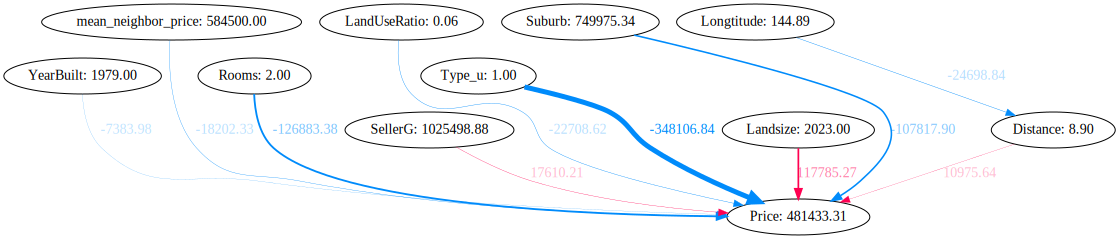

<AGraph <Swig Object of type 'Agraph_t *' at 0x7ec46f578960>>

In [256]:
shap_values_flow.draw(0,
          max_display=10,
          show_fg_val=True,
          )

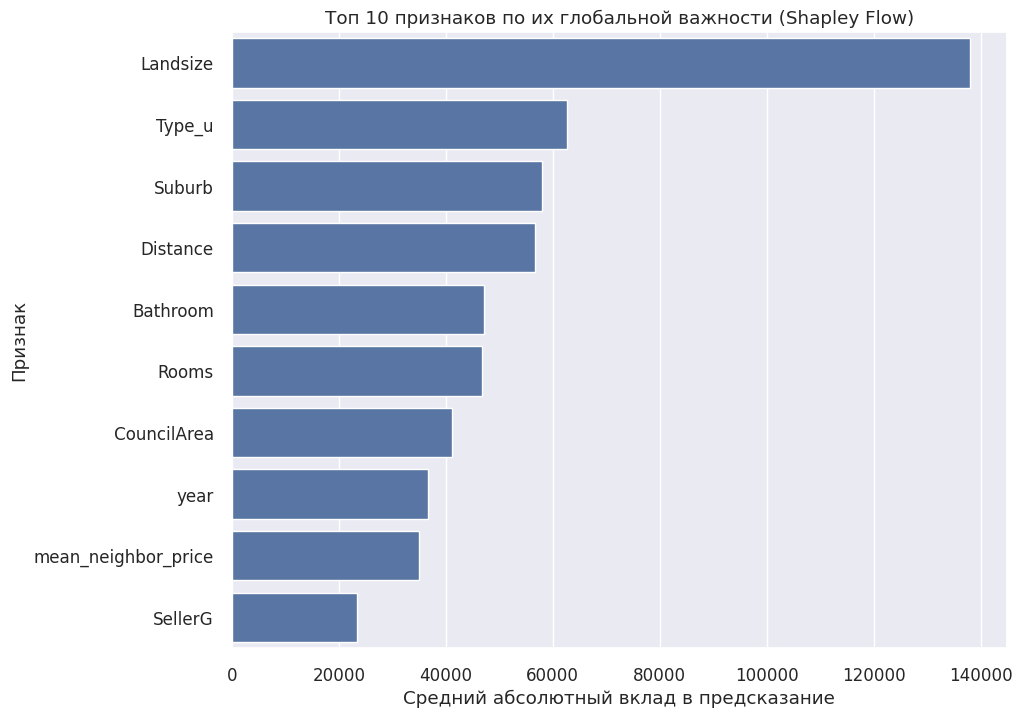

In [257]:
mean_abs_flow = node_credits_df.abs().mean().sort_values(ascending=False)
k_top = 10
top_k_mean_abs_flow = mean_abs_flow[:k_top]

plt.figure(figsize=(10, 8))
sns.barplot(x=top_k_mean_abs_flow.values, y=top_k_mean_abs_flow.index)
plt.title(f'Топ {k_top} признаков по их глобальной важности (Shapley Flow)')
plt.xlabel('Средний абсолютный вклад в предсказание')
plt.ylabel('Признак')
plt.show()

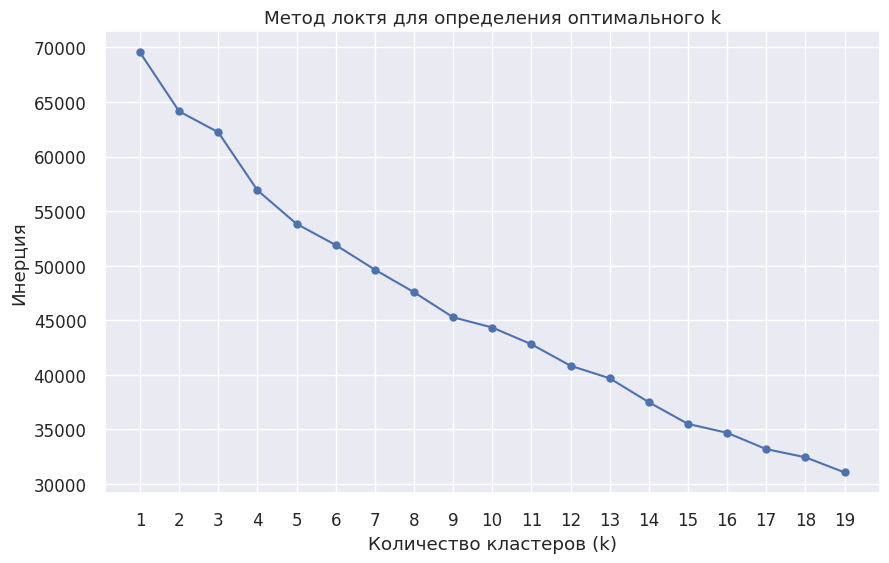

In [258]:
scaler = StandardScaler()
scaled_flow_values = scaler.fit_transform(node_credits_df)

inertia = []

k_range = range(1, 20)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto') # n_init='auto' для подавления Future-предупреждений
    kmeans.fit(scaled_flow_values)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Инерция')
plt.title('Метод локтя для определения оптимального k')
plt.xticks(k_range)
plt.grid(True)
plt.show()

Трудно однозначно сказать, какое число кластеров будет оптимальным для данной задачи. Однако видно, что самые сильные перегибы (самое большое уменьшение инерции) наблюдается при увеличении числа кластеров с 1 до 3, а дальше идет более стабильное уменьшение.

Поэтому давайте остановимся на четырёх кластерах, чтобы можно было дать хорошую интерпретацию для каждого кластера

In [259]:
n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(scaled_flow_values)

X_val_with_clusters = X_val.copy()
X_val_with_clusters['cluster'] = clusters
cluster_mean = X_val_with_clusters.groupby('cluster').mean()

node_credits_df['cluster'] = clusters
cluster_profiles = node_credits_df.groupby('cluster').mean()

In [260]:
top_features = top_k_mean_abs_flow.index
cluster_mean[top_features].style.format('{:.2f}')

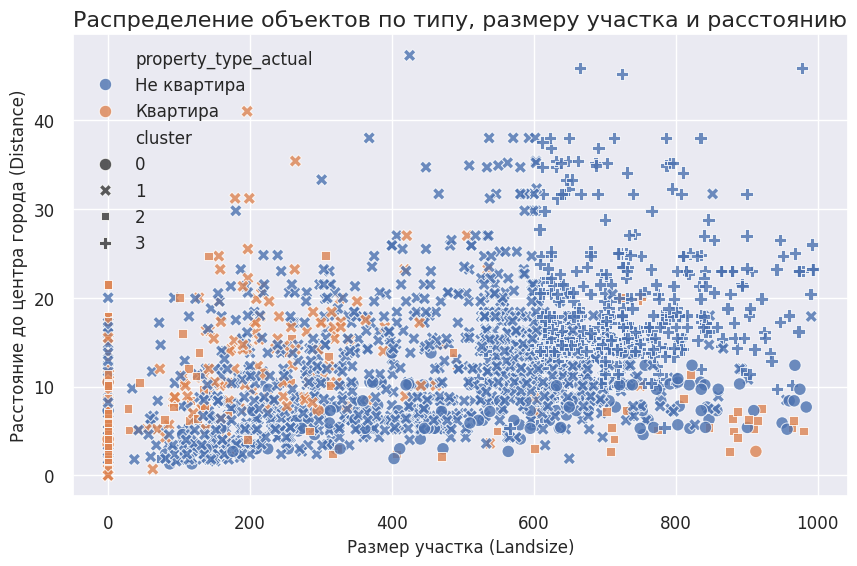

In [261]:
X_val_with_clusters['property_type_actual'] = np.where(
    X_val_with_clusters['Type_u'] == 1,
    'Квартира',
    'Не квартира'
)

plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=X_val_with_clusters[X_val_with_clusters["Landsize"] < 1000],
    x='Landsize',
    y='Distance',
    hue='property_type_actual',
    style='cluster',
    s=80,
    alpha=0.8
)

plt.title('Распределение объектов по типу, размеру участка и расстоянию', fontsize=16)
plt.xlabel('Размер участка (Landsize)', fontsize=12)
plt.ylabel('Расстояние до центра города (Distance)', fontsize=12)

plt.show()

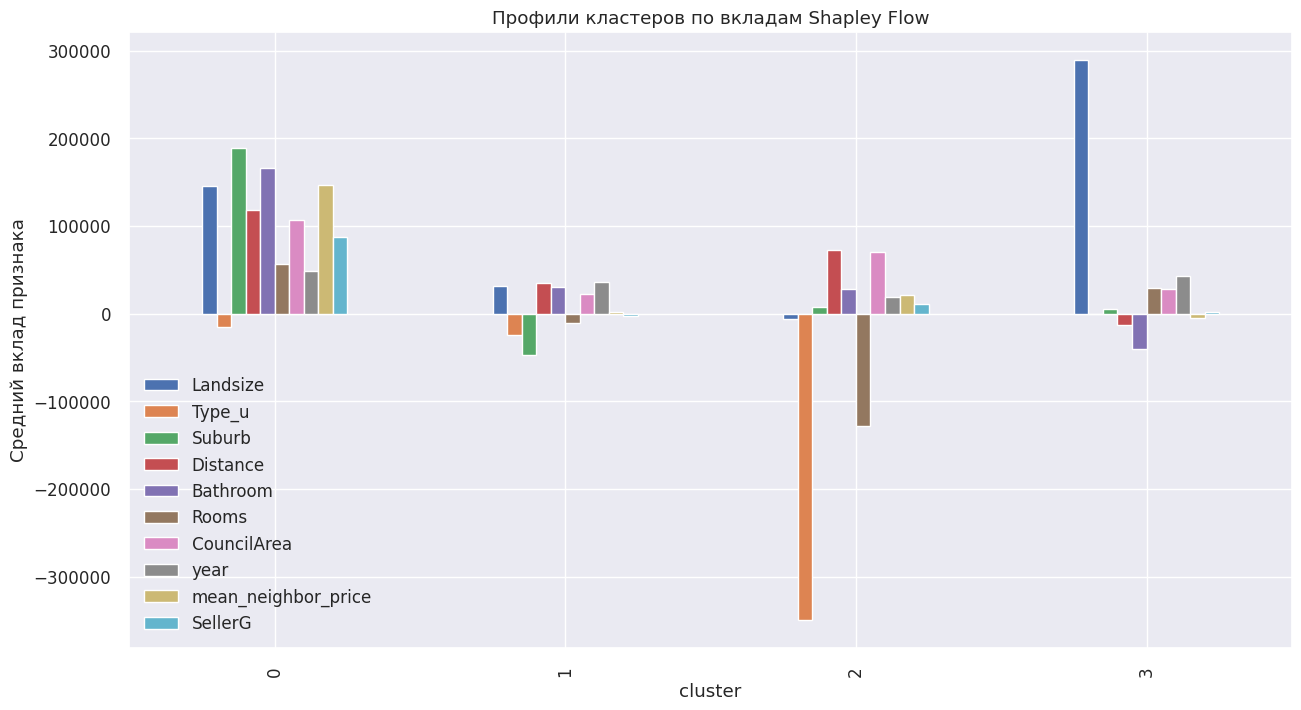

In [262]:
cluster_profiles[top_features].plot(kind='bar', figsize=(15, 8),
                                    title='Профили кластеров по вкладам Shapley Flow')
plt.ylabel('Средний вклад признака')
plt.show()

Кластеризация получилась довольно смешанной, однако некоторые закономерности видны в этих кластерах:

1) В кластере 2 находятся квартиры, так как для них самый важный признак это Type_u. Для этих квартир самыми важными признаками являются Distance, Rooms и CouncilArea.

2) В кластере 3 находятся дома, которые удалены далеко от центра, для них самым важным признаком является Landsize

3) Для кластеров 0 и 1 сложно выделить самые важные признаки, много признаков имеют примерно одинаковый вклад

In [263]:
# Теперь проанализируем сдвиги
# Для анализа сдвигов нужно получить Shapley Flow значения на обучающей выборке

bg_sample = X_train.median().to_frame().T
fg_samples = X_train

nruns = 100
all_node_credits_train = []

print(f"Начинаем расчет Shapley Flow для {len(fg_samples)} объектов...")
print(f"Используем {len(bg_sample)} объектов в качестве background")

for i in range(len(bg_sample)):
    explainer = GraphExplainer(graph, bg_sample.iloc[i:i+1], nruns=nruns)
    shap_values_flow = explainer.shap_values(fg_samples)

    edge_credit_dict = shap_values_flow.edge_credit
    edge_credit_str_keys_dict = node_dict2str_dict(edge_credit_dict)

    final_contributions = {}
    graph_features = [node.name for node in graph.nodes if node.name != target]

    for feature in graph_features:
        if target in edge_credit_str_keys_dict[feature]:
            final_contributions[feature] = edge_credit_str_keys_dict[feature][target]

    temp_df = pd.DataFrame(final_contributions, index=fg_samples.index)
    all_node_credits_train.append(temp_df)
node_credits_df_train = pd.concat(all_node_credits_train).groupby(level=0).mean()

common_columns = [col for col in X_val.columns if col in node_credits_df_train.columns]
node_credits_df_train = node_credits_df_train[common_columns]

Начинаем расчет Shapley Flow для 8691 объектов...
Используем 1 объектов в качестве background


bruteforce sampling: 100%|██████████| 100/100 [02:40<00:00,  1.61s/it]


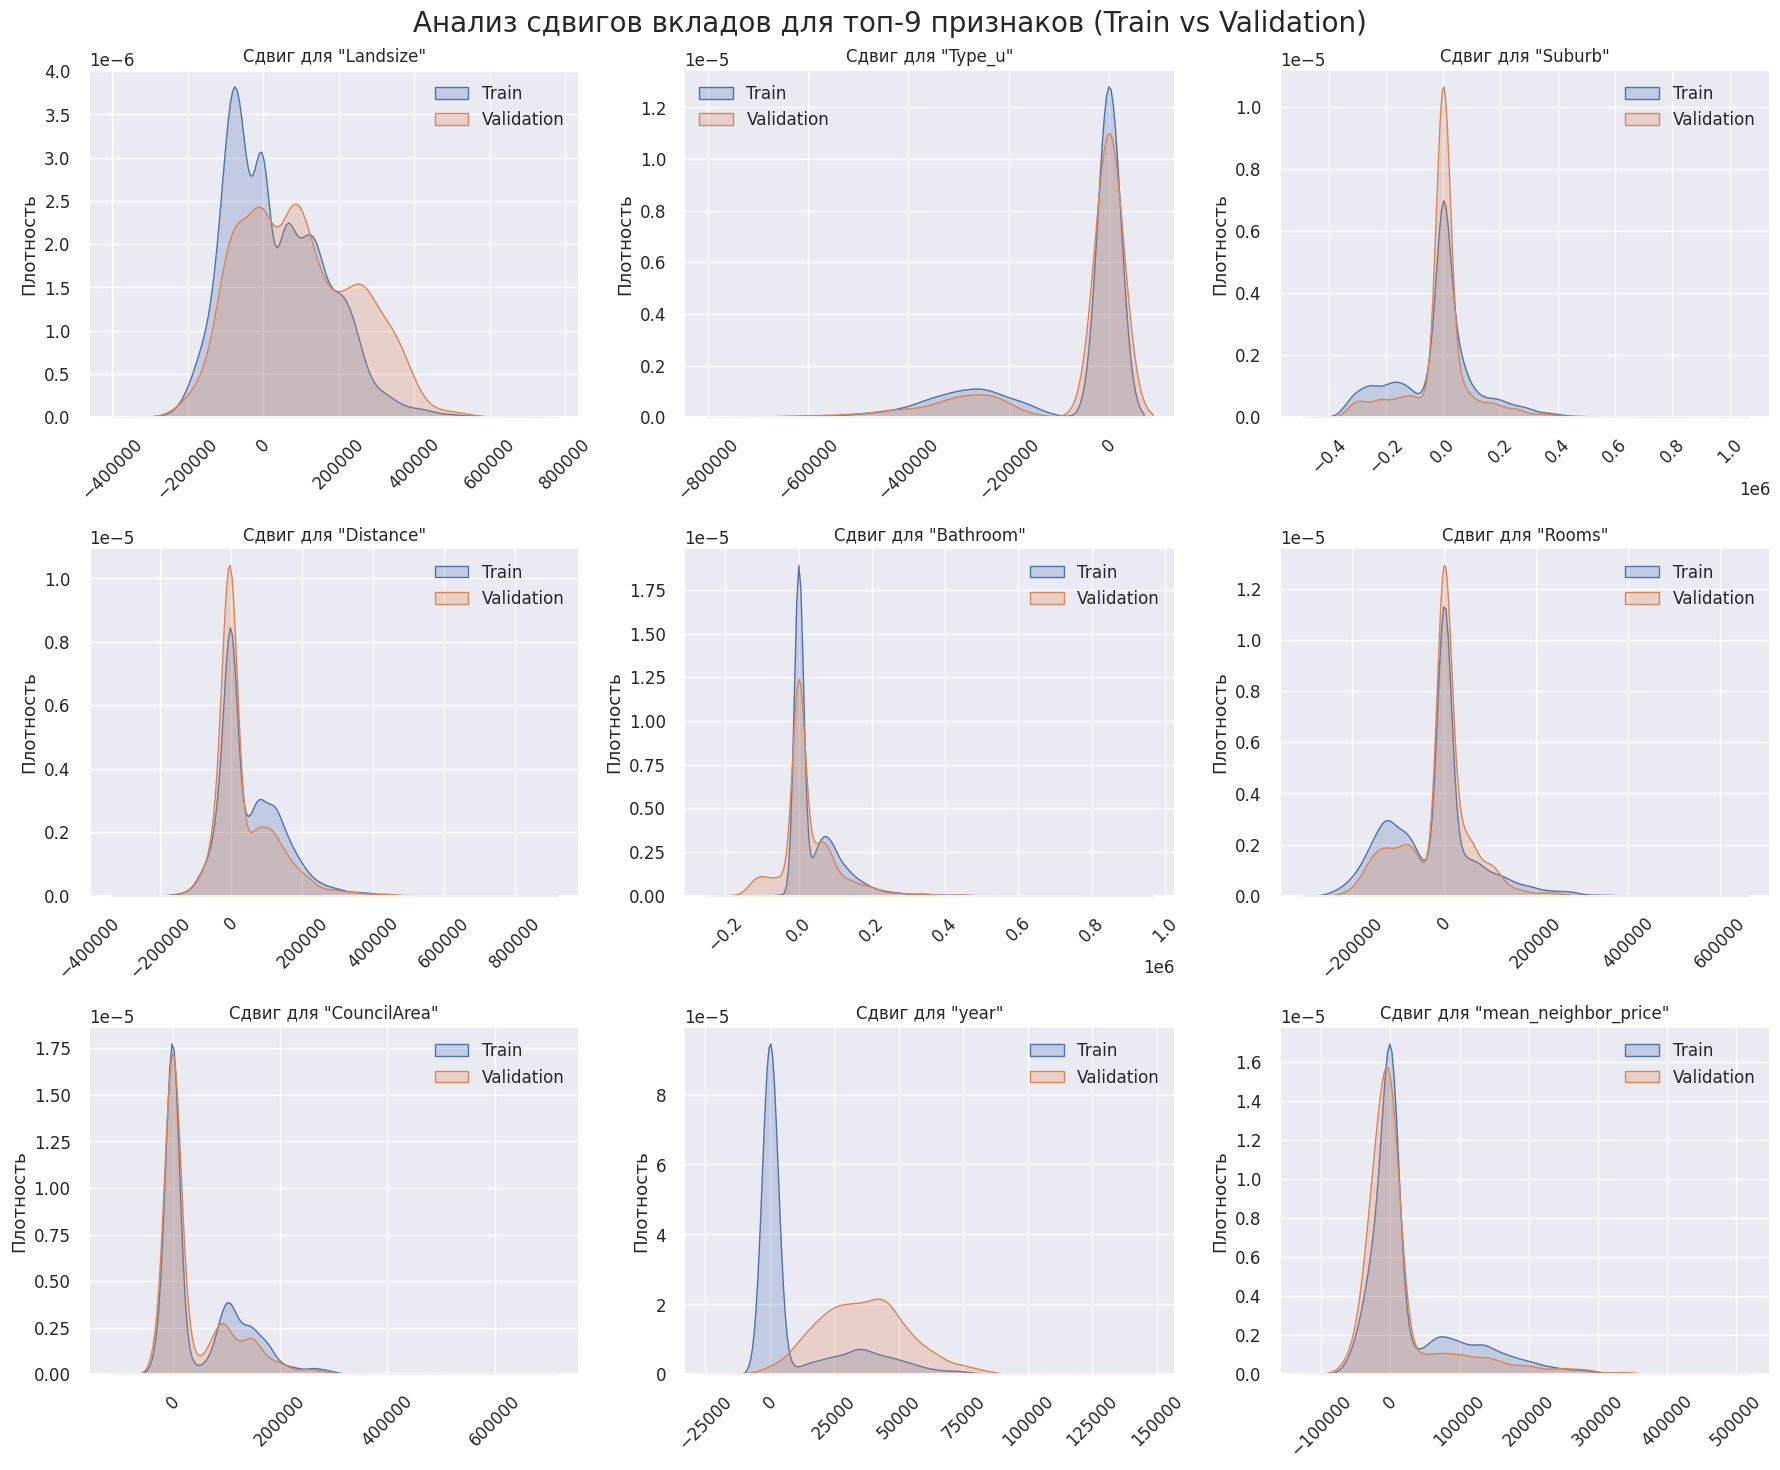

In [264]:
top_9_features = mean_abs_flow.index[:9].tolist()

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('Анализ сдвигов вкладов для топ-9 признаков (Train vs Validation)', fontsize=20)

for feature, ax in zip(top_9_features, axes.flatten()):
    sns.kdeplot(data=node_credits_df_train, x=feature, label='Train', fill=True, ax=ax)
    sns.kdeplot(data=node_credits_df, x=feature, label='Validation', fill=True, ax=ax)

    ax.set_title(f'Сдвиг для "{feature}"', fontsize=12)
    ax.set_xlabel('')
    ax.set_ylabel('Плотность')
    ax.legend()
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

К сожалению, модель показывает не очень высокую стабильность, для самых важных признаков есть сдвиги.

Самые важные сдвиги:

1) `year` - самый сильный сдвиг. Вклады для валидационной выборки смещены вправо, что предсказуемо, так как модель видит больше данных с другим годом продажи.

2) `Landsize`: сдвиг вправо, указывающий на то, что модель на валидационных данных стала активнее вознаграждать объекты с большими участками.